In [8]:
import json
import os

import yaml
import random
import argparse
from functools import partial
from typing import Dict, Any
from itertools import cycle
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

from scipy.stats import linregress
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from adjustText import adjust_text

from sklearn.manifold import TSNE
from scipy.stats import pearsonr
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from matplotlib.projections import register_projection
import plotly.graph_objects as go
from plotly.offline import plot

plt.rcParams['font.family'] = 'Arial' #
sns.reset_defaults()
sns.set_theme(context='paper', style='ticks', font='Arial')

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 9,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 300,
    'figure.dpi': 150,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})

In [9]:
ROOT_DIR = '/mnt/home/floyed/code_for_brain_align'
DATA_DIR = f"{ROOT_DIR}/data"
FIGURES_DIR = f"{ROOT_DIR}/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

In [10]:
language_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/language_all.parquet')
vision_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/vision_all.parquet')
fmri_df = pd.read_parquet(f'{DATA_DIR}/intermediate_results/fmri_alignment.parquet')
language_df = language_df[language_df['relative_src_feature'] < 8]

In [4]:
print(language_df.shape, vision_df.shape, fmri_df.shape)

(18441000, 18) (65626380, 17) (324000, 7)


In [11]:
subject_replace = {
    'subj01': "S01",
    'subj02': "S02",
    'subj05': "S05",
    'subj07': "S07",
}

language_df['tgt_model'] = language_df['tgt_model'].map(subject_replace)
vision_df['tgt_model'] = vision_df['tgt_model'].map(subject_replace)
fmri_df['tgt_model'] = fmri_df['tgt_model'].map(subject_replace)
fmri_df['src_model'] = fmri_df['src_model'].map(subject_replace)

In [12]:
model_category_dict = {
    # CNN Models
    "convnext_atto.d2_in1k": "CNN",
    "convnext_atto_ols.a2_in1k": "CNN",
    "convnext_base.clip_laion2b_augreg_ft_in12k_in1k": "CNN",
    "convnext_base.clip_laion2b_augreg_ft_in12k_in1k_384": "CNN",
    "convnext_base.clip_laion2b_augreg_ft_in1k": "CNN",
    "convnext_base.clip_laiona_augreg_ft_in1k_384": "CNN",
    "convnext_base.fb_in1k": "CNN",
    "convnext_base.fb_in22k_ft_in1k": "CNN",
    "convnext_base.fb_in22k_ft_in1k_384": "CNN",
    "convnext_femto.d1_in1k": "CNN",
    "convnext_femto_ols.d1_in1k": "CNN",
    "convnext_large.fb_in1k": "CNN",
    "convnext_large.fb_in22k_ft_in1k": "CNN",
    "convnext_large.fb_in22k_ft_in1k_384": "CNN",
    "convnext_large_mlp.clip_laion2b_augreg_ft_in1k": "CNN",
    "convnext_large_mlp.clip_laion2b_augreg_ft_in1k_384": "CNN",
    "convnext_large_mlp.clip_laion2b_soup_ft_in12k_in1k_320": "CNN",
    "convnext_large_mlp.clip_laion2b_soup_ft_in12k_in1k_384": "CNN",
    "convnext_nano.d1h_in1k": "CNN",
    "convnext_nano.in12k_ft_in1k": "CNN",
    "convnext_nano_ols.d1h_in1k": "CNN",
    "convnext_pico.d1_in1k": "CNN",
    "convnext_pico_ols.d1_in1k": "CNN",
    "convnext_small.fb_in1k": "CNN",
    "convnext_small.fb_in22k_ft_in1k": "CNN",
    "convnext_small.fb_in22k_ft_in1k_384": "CNN",
    "convnext_small.in12k_ft_in1k": "CNN",
    "convnext_small.in12k_ft_in1k_384": "CNN",
    "convnext_tiny.fb_in1k": "CNN",
    "convnext_tiny.fb_in22k_ft_in1k": "CNN",
    "convnext_tiny.fb_in22k_ft_in1k_384": "CNN",
    "convnext_tiny.in12k_ft_in1k": "CNN",
    "convnext_tiny.in12k_ft_in1k_384": "CNN",
    "convnext_tiny_hnf.a2h_in1k": "CNN",
    "convnext_xlarge.fb_in22k_ft_in1k": "CNN",
    "convnext_xlarge.fb_in22k_ft_in1k_384": "CNN",
    "cs3darknet_focus_l.c2ns_in1k": "CNN",
    "cs3darknet_focus_m.c2ns_in1k": "CNN",
    "cs3darknet_l.c2ns_in1k": "CNN",
    "cs3darknet_m.c2ns_in1k": "CNN",
    "cs3darknet_x.c2ns_in1k": "CNN",
    "cs3edgenet_x.c2_in1k": "CNN",
    "cs3se_edgenet_x.c2ns_in1k": "CNN",
    "cs3sedarknet_l.c2ns_in1k": "CNN",
    "cs3sedarknet_x.c2ns_in1k": "CNN",
    "cspdarknet53.ra_in1k": "CNN",
    "cspresnet50.ra_in1k": "CNN",
    "darknet53.c2ns_in1k": "CNN",
    "darknetaa53.c2ns_in1k": "CNN",
    "densenet121.tv_in1k": "CNN",
    "densenet169.tv_in1k": "CNN",
    "densenetblur121d.ra_in1k": "CNN",
    "dm_nfnet_f0.dm_in1k": "CNN",
    "dm_nfnet_f1.dm_in1k": "CNN",
    "dm_nfnet_f2.dm_in1k": "CNN",
    "dm_nfnet_f3.dm_in1k": "CNN",
    "dm_nfnet_f4.dm_in1k": "CNN",
    "dm_nfnet_f5.dm_in1k": "CNN",
    "dm_nfnet_f6.dm_in1k": "CNN",
    "dpn107.mx_in1k": "CNN",
    "dpn131.mx_in1k": "CNN",
    "dpn68.mx_in1k": "CNN",
    "dpn68b.mx_in1k": "CNN",
    "dpn68b.ra_in1k": "CNN",
    "dpn92.mx_in1k": "CNN",
    "dpn98.mx_in1k": "CNN",
    "efficientnet_b1.ft_in1k": "CNN",
    "efficientnet_b1_pruned.in1k": "CNN",
    "efficientnet_b2.ra_in1k": "CNN",
    "efficientnet_b2_pruned.in1k": "CNN",
    "efficientnet_b3.ra2_in1k": "CNN",
    "efficientnet_b3_pruned.in1k": "CNN",
    "efficientnet_b4.ra2_in1k": "CNN",
    "efficientnet_b5.sw_in12k_ft_in1k": "CNN",
    "efficientnet_el.ra_in1k": "CNN",
    "efficientnet_el_pruned.in1k": "CNN",
    "efficientnet_em.ra2_in1k": "CNN",
    "efficientnet_es.ra_in1k": "CNN",
    "efficientnet_es_pruned.in1k": "CNN",
    "efficientnet_lite0.ra_in1k": "CNN",
    "efficientnetv2_rw_m.agc_in1k": "CNN",
    "efficientnetv2_rw_s.ra2_in1k": "CNN",
    "efficientnetv2_rw_t.ra2_in1k": "CNN",
    "ese_vovnet39b.ra_in1k": "CNN",
    "fbnetc_100.rmsp_in1k": "CNN",
    "fbnetv3_b.ra2_in1k": "CNN",
    "fbnetv3_d.ra2_in1k": "CNN",
    "fbnetv3_g.ra2_in1k": "CNN",
    "gc_efficientnetv2_rw_t.agc_in1k": "CNN",
    "gcresnet33ts.ra2_in1k": "CNN",
    "gcresnet50t.ra2_in1k": "CNN",
    "gcresnext50ts.ch_in1k": "CNN",
    "gernet_m.idstcv_in1k": "CNN",
    "gernet_s.idstcv_in1k": "CNN",
    "ghostnet_100.in1k": "CNN",
    "ghostnetv2_100.in1k": "CNN",
    "ghostnetv2_130.in1k": "CNN",
    "ghostnetv2_160.in1k": "CNN",
    "haloregnetz_b.ra3_in1k": "CNN",
    "hardcorenas_a.miil_green_in1k": "CNN",
    "hardcorenas_b.miil_green_in1k": "CNN",
    "hardcorenas_c.miil_green_in1k": "CNN",
    "hardcorenas_d.miil_green_in1k": "CNN",
    "hardcorenas_e.miil_green_in1k": "CNN",
    "hardcorenas_f.miil_green_in1k": "CNN",
    "inception_v4.tf_in1k": "CNN",
    "lcnet_050.ra2_in1k": "CNN",
    "lcnet_075.ra2_in1k": "CNN",
    "lcnet_100.ra2_in1k": "CNN",
    "mixnet_m.ft_in1k": "CNN",
    "mixnet_s.ft_in1k": "CNN",
    "mixnet_xl.ra_in1k": "CNN",
    "mnasnet_100.rmsp_in1k": "CNN",
    "mnasnet_small.lamb_in1k": "CNN",
    "mobilenetv2_050.lamb_in1k": "CNN",
    "mobilenetv2_100.ra_in1k": "CNN",
    "mobilenetv2_110d.ra_in1k": "CNN",
    "mobilenetv2_120d.ra_in1k": "CNN",
    "mobilenetv2_140.ra_in1k": "CNN",
    "mobilenetv3_large_100.miil_in21k_ft_in1k": "CNN",
    "mobilenetv3_large_100.ra_in1k": "CNN",
    "mobilenetv3_rw.rmsp_in1k": "CNN",
    "mobilenetv3_small_050.lamb_in1k": "CNN",
    "mobilenetv3_small_075.lamb_in1k": "CNN",
    "mobilenetv3_small_100.lamb_in1k": "CNN",
    "mobileone_s0.apple_in1k": "CNN",
    "mobileone_s1.apple_in1k": "CNN",
    "mobileone_s4.apple_in1k": "CNN",
    "nf_resnet50.ra2_in1k": "CNN",
    "nfnet_l0.ra2_in1k": "CNN",
    "regnetz_c16_evos.ch_in1k": "CNN",
    "regnetz_d32.ra3_in1k": "CNN",
    "regnetz_d8.ra3_in1k": "CNN",
    "regnetz_d8_evos.ch_in1k": "CNN",
    "regnetz_e8.ra3_in1k": "CNN",
    "repghostnet_050.in1k": "CNN",
    "repghostnet_058.in1k": "CNN",
    "repghostnet_080.in1k": "CNN",
    "repghostnet_100.in1k": "CNN",
    "repghostnet_111.in1k": "CNN",
    "repghostnet_130.in1k": "CNN",
    "repghostnet_150.in1k": "CNN",
    "resnet51q.ra2_in1k": "CNN",
    "resnet61q.ra2_in1k": "CNN",
    "rexnet_100.nav_in1k": "CNN",
    "rexnet_130.nav_in1k": "CNN",
    "rexnet_150.nav_in1k": "CNN",
    "rexnet_200.nav_in1k": "CNN",
    "sebotnet33ts_256.a1h_in1k": "CNN",
    "sehalonet33ts.ra2_in1k": "CNN",
    "selecsls42b.in1k": "CNN",
    "selecsls60.in1k": "CNN",
    "selecsls60b.in1k": "CNN",
    "semnasnet_075.rmsp_in1k": "CNN",
    "semnasnet_100.rmsp_in1k": "CNN",
    "seresnet33ts.ra2_in1k": "CNN",
    "spnasnet_100.rmsp_in1k": "CNN",
    "tf_efficientnet_b0.aa_in1k": "CNN",
    "tf_efficientnet_b0.ap_in1k": "CNN",
    "tf_efficientnet_b0.in1k": "CNN",
    "tf_efficientnet_b0.ns_jft_in1k": "CNN",
    "tf_efficientnet_b1.aa_in1k": "CNN",
    "tf_efficientnet_b1.ap_in1k": "CNN",
    "tf_efficientnet_b1.in1k": "CNN",
    "tf_efficientnet_b1.ns_jft_in1k": "CNN",
    "tf_efficientnet_b2.aa_in1k": "CNN",
    "tf_efficientnet_b2.ap_in1k": "CNN",
    "tf_efficientnet_b2.in1k": "CNN",
    "tf_efficientnet_b2.ns_jft_in1k": "CNN",
    "tf_efficientnet_b3.aa_in1k": "CNN",
    "tf_efficientnet_b3.ap_in1k": "CNN",
    "tf_efficientnet_b3.in1k": "CNN",
    "tf_efficientnet_b3.ns_jft_in1k": "CNN",
    "tf_efficientnet_b4.aa_in1k": "CNN",
    "tf_efficientnet_b4.ap_in1k": "CNN",
    "tf_efficientnet_b4.in1k": "CNN",
    "tf_efficientnet_b4.ns_jft_in1k": "CNN",
    "tf_efficientnet_b5.aa_in1k": "CNN",
    "tf_efficientnet_b5.ap_in1k": "CNN",
    "tf_efficientnet_b5.in1k": "CNN",
    "tf_efficientnet_b5.ns_jft_in1k": "CNN",
    "tf_efficientnet_b5.ra_in1k": "CNN",
    "tf_efficientnet_b6.aa_in1k": "CNN",
    "tf_efficientnet_b6.ap_in1k": "CNN",
    "tf_efficientnet_b6.ns_jft_in1k": "CNN",
    "tf_efficientnet_b7.aa_in1k": "CNN",
    "tf_efficientnet_b7.ap_in1k": "CNN",
    "tf_efficientnet_b7.ns_jft_in1k": "CNN",
    "tf_efficientnet_b7.ra_in1k": "CNN",
    "tf_efficientnet_b8.ap_in1k": "CNN",
    "tf_efficientnet_b8.ra_in1k": "CNN",
    "tf_efficientnet_cc_b0_4e.in1k": "CNN",
    "tf_efficientnet_cc_b0_8e.in1k": "CNN",
    "tf_efficientnet_cc_b1_8e.in1k": "CNN",
    "tf_efficientnet_el.in1k": "CNN",
    "tf_efficientnet_em.in1k": "CNN",
    "tf_efficientnet_es.in1k": "CNN",
    "tf_efficientnet_l2.ns_jft_in1k_475": "CNN",
    "tf_efficientnet_lite0.in1k": "CNN",
    "tf_efficientnet_lite1.in1k": "CNN",
    "tf_efficientnet_lite2.in1k": "CNN",
    "tf_efficientnet_lite3.in1k": "CNN",
    "tf_efficientnet_lite4.in1k": "CNN",
    "tf_efficientnetv2_b0.in1k": "CNN",
    "tf_efficientnetv2_b1.in1k": "CNN",
    "tf_efficientnetv2_b2.in1k": "CNN",
    "tf_efficientnetv2_b3.in1k": "CNN",
    "tf_efficientnetv2_b3.in21k_ft_in1k": "CNN",
    "tf_efficientnetv2_l.in1k": "CNN",
    "tf_efficientnetv2_l.in21k_ft_in1k": "CNN",
    "tf_efficientnetv2_m.in1k": "CNN",
    "tf_efficientnetv2_m.in21k_ft_in1k": "CNN",
    "tf_efficientnetv2_s.in1k": "CNN",
    "tf_efficientnetv2_s.in21k_ft_in1k": "CNN",
    "tf_efficientnetv2_xl.in21k_ft_in1k": "CNN",
    "tf_mixnet_l.in1k": "CNN",
    "tf_mixnet_m.in1k": "CNN",
    "tf_mixnet_s.in1k": "CNN",
    "tf_mobilenetv3_large_075.in1k": "CNN",
    "tf_mobilenetv3_large_100.in1k": "CNN",
    "tf_mobilenetv3_large_minimal_100.in1k": "CNN",
    "tf_mobilenetv3_small_075.in1k": "CNN",
    "tf_mobilenetv3_small_100.in1k": "CNN",
    "tf_mobilenetv3_small_minimal_100.in1k": "CNN",
    "tinynet_a.in1k": "CNN",
    "tinynet_b.in1k": "CNN",
    "tinynet_c.in1k": "CNN",
    "tinynet_d.in1k": "CNN",
    "tinynet_e.in1k": "CNN",
    "vgg11.tv_in1k": "CNN",
    "vgg11_bn.tv_in1k": "CNN",
    "vgg13.tv_in1k": "CNN",
    "vgg13_bn.tv_in1k": "CNN",
    "vgg16.tv_in1k": "CNN",
    "vgg16_bn.tv_in1k": "CNN",
    "vgg19.tv_in1k": "CNN",
    "vgg19_bn.tv_in1k": "CNN",
    "xception41.tf_in1k": "CNN",
    "xception41p.ra3_in1k": "CNN",
    "xception65.ra3_in1k": "CNN",
    "xception65.tf_in1k": "CNN",
    "xception65p.ra3_in1k": "CNN",
    "xception71.tf_in1k": "CNN",

    # Transformer Models
    "beit_base_patch16_224.in22k_ft_in22k_in1k": "Transformer",
    "beit_base_patch16_384.in22k_ft_in22k_in1k": "Transformer",
    "beit_large_patch16_224.in22k_ft_in22k_in1k": "Transformer",
    "beit_large_patch16_384.in22k_ft_in22k_in1k": "Transformer",
    "beit_large_patch16_512.in22k_ft_in22k_in1k": "Transformer",
    "beitv2_base_patch16_224.in1k_ft_in1k": "Transformer",
    "beitv2_base_patch16_224.in1k_ft_in22k_in1k": "Transformer",
    "beitv2_large_patch16_224.in1k_ft_in1k": "Transformer",
    "beitv2_large_patch16_224.in1k_ft_in22k_in1k": "Transformer",
    "cait_m48_448.fb_dist_in1k": "Transformer",
    "cait_s24_224.fb_dist_in1k": "Transformer",
    "cait_s24_384.fb_dist_in1k": "Transformer",
    "cait_s36_384.fb_dist_in1k": "Transformer",
    "cait_xs24_384.fb_dist_in1k": "Transformer",
    "davit_base.msft_in1k": "Transformer",
    "davit_small.msft_in1k": "Transformer",
    "davit_tiny.msft_in1k": "Transformer",
    "deit3_base_patch16_224.fb_in1k": "Transformer",
    "deit3_base_patch16_224.fb_in22k_ft_in1k": "Transformer",
    "deit3_base_patch16_384.fb_in1k": "Transformer",
    "deit3_base_patch16_384.fb_in22k_ft_in1k": "Transformer",
    "deit3_huge_patch14_224.fb_in1k": "Transformer",
    "deit3_huge_patch14_224.fb_in22k_ft_in1k": "Transformer",
    "deit3_large_patch16_224.fb_in1k": "Transformer",
    "deit3_large_patch16_224.fb_in22k_ft_in1k": "Transformer",
    "deit3_large_patch16_384.fb_in1k": "Transformer",
    "deit3_large_patch16_384.fb_in22k_ft_in1k": "Transformer",
    "deit3_medium_patch16_224.fb_in1k": "Transformer",
    "deit3_medium_patch16_224.fb_in22k_ft_in1k": "Transformer",
    "deit3_small_patch16_224.fb_in1k": "Transformer",
    "deit3_small_patch16_224.fb_in22k_ft_in1k": "Transformer",
    "deit3_small_patch16_384.fb_in1k": "Transformer",
    "deit3_small_patch16_384.fb_in22k_ft_in1k": "Transformer",
    "deit_base_distilled_patch16_224.fb_in1k": "Transformer",
    "deit_base_distilled_patch16_384.fb_in1k": "Transformer",
    "deit_base_patch16_224.fb_in1k": "Transformer",
    "deit_base_patch16_384.fb_in1k": "Transformer",
    "deit_small_distilled_patch16_224.fb_in1k": "Transformer",
    "deit_small_patch16_224.fb_in1k": "Transformer",
    "deit_tiny_distilled_patch16_224.fb_in1k": "Transformer",
    "deit_tiny_patch16_224.fb_in1k": "Transformer",
    "densenet121.ra_in1k": "Transformer",
    "eva02_base_patch14_448.mim_in22k_ft_in1k": "Transformer",
    "eva02_base_patch14_448.mim_in22k_ft_in22k_in1k": "Transformer",
    "eva02_large_patch14_448.mim_in22k_ft_in1k": "Transformer",
    "eva02_large_patch14_448.mim_in22k_ft_in22k_in1k": "Transformer",
    "eva02_large_patch14_448.mim_m38m_ft_in1k": "Transformer",
    "eva02_large_patch14_448.mim_m38m_ft_in22k_in1k": "Transformer",
    "eva02_small_patch14_336.mim_in22k_ft_in1k": "Transformer",
    "eva02_tiny_patch14_336.mim_in22k_ft_in1k": "Transformer",
    "eva_giant_patch14_224.clip_ft_in1k": "Transformer",
    "eva_giant_patch14_336.clip_ft_in1k": "Transformer",
    "eva_giant_patch14_336.m30m_ft_in22k_in1k": "Transformer",
    "eva_giant_patch14_560.m30m_ft_in22k_in1k": "Transformer",
    "eva_large_patch14_196.in22k_ft_in1k": "Transformer",
    "eva_large_patch14_196.in22k_ft_in22k_in1k": "Transformer",
    "eva_large_patch14_336.in22k_ft_in1k": "Transformer",
    "eva_large_patch14_336.in22k_ft_in22k_in1k": "Transformer",
    "flexivit_base.1200ep_in1k": "Transformer",
    "flexivit_base.300ep_in1k": "Transformer",
    "flexivit_base.600ep_in1k": "Transformer",
    "flexivit_large.1200ep_in1k": "Transformer",
    "flexivit_large.300ep_in1k": "Transformer",
    "flexivit_large.600ep_in1k": "Transformer",
    "flexivit_small.1200ep_in1k": "Transformer",
    "flexivit_small.300ep_in1k": "Transformer",
    "flexivit_small.600ep_in1k": "Transformer",
    "focalnet_base_lrf.ms_in1k": "Transformer",
    "focalnet_base_srf.ms_in1k": "Transformer",
    "focalnet_small_lrf.ms_in1k": "Transformer",
    "focalnet_small_srf.ms_in1k": "Transformer",
    "focalnet_tiny_lrf.ms_in1k": "Transformer",
    "focalnet_tiny_srf.ms_in1k": "Transformer",
    "gmlp_s16_224.ra3_in1k": "Transformer",
    "levit_128.fb_dist_in1k": "Transformer",
    "levit_128s.fb_dist_in1k": "Transformer",
    "levit_192.fb_dist_in1k": "Transformer",
    "levit_256.fb_dist_in1k": "Transformer",
    "levit_384.fb_dist_in1k": "Transformer",
    "levit_conv_128.fb_dist_in1k": "Transformer",
    "levit_conv_128s.fb_dist_in1k": "Transformer",
    "levit_conv_192.fb_dist_in1k": "Transformer",
    "levit_conv_256.fb_dist_in1k": "Transformer",
    "levit_conv_384.fb_dist_in1k": "Transformer",
    "maxvit_base_tf_224.in1k": "Transformer",
    "mvitv2_base.fb_in1k": "Transformer",
    "mvitv2_large.fb_in1k": "Transformer",
    "mvitv2_small.fb_in1k": "Transformer",
    "mvitv2_tiny.fb_in1k": "Transformer",
    "nf_regnet_b1.ra2_in1k": "Transformer",
    "poolformer_m36.sail_in1k": "Transformer",
    "poolformer_m48.sail_in1k": "Transformer",
    "poolformer_s12.sail_in1k": "Transformer",
    "poolformer_s24.sail_in1k": "Transformer",
    "poolformer_s36.sail_in1k": "Transformer",
    "poolformerv2_m36.sail_in1k": "Transformer",
    "poolformerv2_m48.sail_in1k": "Transformer",
    "poolformerv2_s12.sail_in1k": "Transformer",
    "poolformerv2_s24.sail_in1k": "Transformer",
    "poolformerv2_s36.sail_in1k": "Transformer",
    "pvt_v2_b0.in1k": "Transformer",
    "pvt_v2_b1.in1k": "Transformer",
    "pvt_v2_b2.in1k": "Transformer",
    "pvt_v2_b2_li.in1k": "Transformer",
    "pvt_v2_b3.in1k": "Transformer",
    "pvt_v2_b4.in1k": "Transformer",
    "pvt_v2_b5.in1k": "Transformer",
    "regnetz_b16.ra3_in1k": "Transformer",
    "regnetz_c16.ra3_in1k": "Transformer",
    "repvit_m0_9.dist_300e_in1k": "Transformer",
    "repvit_m0_9.dist_450e_in1k": "Transformer",
    "repvit_m1.dist_in1k": "Transformer",
    "repvit_m1_0.dist_300e_in1k": "Transformer",
    "repvit_m1_0.dist_450e_in1k": "Transformer",
    "repvit_m1_1.dist_300e_in1k": "Transformer",
    "repvit_m1_1.dist_450e_in1k": "Transformer",
    "repvit_m1_5.dist_300e_in1k": "Transformer",
    "repvit_m1_5.dist_450e_in1k": "Transformer",
    "repvit_m2.dist_in1k": "Transformer",
    "repvit_m2_3.dist_300e_in1k": "Transformer",
    "repvit_m2_3.dist_450e_in1k": "Transformer",
    "repvit_m3.dist_in1k": "Transformer",
    "resmlp_12_224.fb_distilled_in1k": "Transformer",
    "resmlp_12_224.fb_in1k": "Transformer",
    "resmlp_24_224.fb_distilled_in1k": "Transformer",
    "resmlp_24_224.fb_in1k": "Transformer",
    "resmlp_36_224.fb_distilled_in1k": "Transformer",
    "resmlp_36_224.fb_in1k": "Transformer",
    "resnet33ts.ra2_in1k": "Transformer",
    "tiny_vit_11m_224.dist_in22k_ft_in1k": "Transformer",
    "tiny_vit_11m_224.in1k": "Transformer",
    "tiny_vit_21m_224.dist_in22k_ft_in1k": "Transformer",
    "tiny_vit_21m_224.in1k": "Transformer",
    "tiny_vit_21m_384.dist_in22k_ft_in1k": "Transformer",
    "tiny_vit_21m_512.dist_in22k_ft_in1k": "Transformer",
    "tiny_vit_5m_224.dist_in22k_ft_in1k": "Transformer",
    "tiny_vit_5m_224.in1k": "Transformer",
    "vit_base_patch16_224.augreg_in1k": "Transformer",
    "vit_base_patch16_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_base_patch16_224.augreg2_in21k_ft_in1k": "Transformer",
    "vit_base_patch16_224.orig_in21k_ft_in1k": "Transformer",
    "vit_base_patch16_224.sam_in1k": "Transformer",
    "vit_base_patch16_224_miil.in21k_ft_in1k": "Transformer",
    "vit_base_patch16_384.augreg_in1k": "Transformer",
    "vit_base_patch16_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_base_patch16_384.orig_in21k_ft_in1k": "Transformer",
    "vit_base_patch16_clip_224.laion2b_ft_in12k_in1k": "Transformer",
    "vit_base_patch16_clip_224.laion2b_ft_in1k": "Transformer",
    "vit_base_patch16_clip_224.openai_ft_in12k_in1k": "Transformer",
    "vit_base_patch16_clip_224.openai_ft_in1k": "Transformer",
    "vit_base_patch16_clip_384.laion2b_ft_in12k_in1k": "Transformer",
    "vit_base_patch16_clip_384.laion2b_ft_in1k": "Transformer",
    "vit_base_patch16_clip_384.openai_ft_in12k_in1k": "Transformer",
    "vit_base_patch16_clip_384.openai_ft_in1k": "Transformer",
    "vit_base_patch16_rpn_224.sw_in1k": "Transformer",
    "vit_base_patch32_224.augreg_in1k": "Transformer",
    "vit_base_patch32_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_base_patch32_224.sam_in1k": "Transformer",
    "vit_base_patch32_384.augreg_in1k": "Transformer",
    "vit_base_patch32_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_base_patch32_clip_224.laion2b_ft_in12k_in1k": "Transformer",
    "vit_base_patch32_clip_224.laion2b_ft_in1k": "Transformer",
    "vit_base_patch32_clip_224.openai_ft_in1k": "Transformer",
    "vit_base_patch32_clip_384.laion2b_ft_in12k_in1k": "Transformer",
    "vit_base_patch32_clip_384.openai_ft_in12k_in1k": "Transformer",
    "vit_base_patch32_clip_448.laion2b_ft_in12k_in1k": "Transformer",
    "vit_base_patch8_224.augreg2_in21k_ft_in1k": "Transformer",
    "vit_base_patch8_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_base_r50_s16_384.orig_in21k_ft_in1k": "Transformer",
    "vit_huge_patch14_clip_224.laion2b_ft_in12k_in1k": "Transformer",
    "vit_huge_patch14_clip_224.laion2b_ft_in1k": "Transformer",
    "vit_huge_patch14_clip_336.laion2b_ft_in12k_in1k": "Transformer",
    "vit_large_patch14_clip_224.laion2b_ft_in12k_in1k": "Transformer",
    "vit_large_patch14_clip_224.laion2b_ft_in1k": "Transformer",
    "vit_large_patch14_clip_224.openai_ft_in12k_in1k": "Transformer",
    "vit_large_patch14_clip_224.openai_ft_in1k": "Transformer",
    "vit_large_patch14_clip_336.laion2b_ft_in12k_in1k": "Transformer",
    "vit_large_patch14_clip_336.laion2b_ft_in1k": "Transformer",
    "vit_large_patch14_clip_336.openai_ft_in12k_in1k": "Transformer",
    "vit_large_patch16_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_large_patch16_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_large_r50_s32_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_large_r50_s32_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_medium_patch16_gap_256.sw_in12k_ft_in1k": "Transformer",
    "vit_medium_patch16_gap_384.sw_in12k_ft_in1k": "Transformer",
    "vit_relpos_base_patch16_224.sw_in1k": "Transformer",
    "vit_relpos_base_patch16_clsgap_224.sw_in1k": "Transformer",
    "vit_relpos_medium_patch16_224.sw_in1k": "Transformer",
    "vit_relpos_medium_patch16_cls_224.sw_in1k": "Transformer",
    "vit_relpos_medium_patch16_rpn_224.sw_in1k": "Transformer",
    "vit_relpos_small_patch16_224.sw_in1k": "Transformer",
    "vit_small_patch16_224.augreg_in1k": "Transformer",
    "vit_small_patch16_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_small_patch16_384.augreg_in1k": "Transformer",
    "vit_small_patch16_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_small_patch32_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_small_patch32_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_small_r26_s32_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_small_r26_s32_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_srelpos_medium_patch16_224.sw_in1k": "Transformer",
    "vit_srelpos_small_patch16_224.sw_in1k": "Transformer",
    "vit_tiny_patch16_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_tiny_patch16_384.augreg_in21k_ft_in1k": "Transformer",
    "vit_tiny_r_s16_p8_224.augreg_in21k_ft_in1k": "Transformer",
    "vit_tiny_r_s16_p8_384.augreg_in21k_ft_in1k": "Transformer",

    # Hybrid Models
    "caformer_b36.sail_in1k": "Hybrid",
    "caformer_b36.sail_in1k_384": "Hybrid",
    "caformer_b36.sail_in22k_ft_in1k": "Hybrid",
    "caformer_b36.sail_in22k_ft_in1k_384": "Hybrid",
    "caformer_m36.sail_in1k": "Hybrid",
    "caformer_m36.sail_in1k_384": "Hybrid",
    "caformer_m36.sail_in22k_ft_in1k": "Hybrid",
    "caformer_m36.sail_in22k_ft_in1k_384": "Hybrid",
    "caformer_s18.sail_in1k": "Hybrid",
    "caformer_s18.sail_in1k_384": "Hybrid",
    "caformer_s18.sail_in22k_ft_in1k": "Hybrid",
    "caformer_s18.sail_in22k_ft_in1k_384": "Hybrid",
    "caformer_s36.sail_in1k": "Hybrid",
    "caformer_s36.sail_in1k_384": "Hybrid",
    "caformer_s36.sail_in22k_ft_in1k": "Hybrid",
    "caformer_s36.sail_in22k_ft_in1k_384": "Hybrid",
    "cait_m36_384.fb_dist_in1k": "Hybrid",
    "coatnet_0_rw_224.sw_in1k": "Hybrid",
    "coatnet_1_rw_224.sw_in1k": "Hybrid",
    "coatnet_2_rw_224.sw_in12k_ft_in1k": "Hybrid",
    "coatnet_bn_0_rw_224.sw_in1k": "Hybrid",
    "coatnet_nano_rw_224.sw_in1k": "Hybrid",
    "coatnet_rmlp_1_rw2_224.sw_in12k_ft_in1k": "Hybrid",
    "coatnet_rmlp_1_rw_224.sw_in1k": "Hybrid",
    "coatnet_rmlp_2_rw_224.sw_in12k_ft_in1k": "Hybrid",
    "coatnet_rmlp_2_rw_224.sw_in1k": "Hybrid",
    "coatnet_rmlp_2_rw_384.sw_in12k_ft_in1k": "Hybrid",
    "coatnet_rmlp_nano_rw_224.sw_in1k": "Hybrid",
    "coatnext_nano_rw_224.sw_in1k": "Hybrid",
    "convformer_b36.sail_in1k": "Hybrid",
    "convformer_b36.sail_in1k_384": "Hybrid",
    "convformer_b36.sail_in22k_ft_in1k": "Hybrid",
    "convformer_b36.sail_in22k_ft_in1k_384": "Hybrid",
    "convformer_m36.sail_in1k": "Hybrid",
    "convformer_m36.sail_in1k_384": "Hybrid",
    "convformer_m36.sail_in22k_ft_in1k": "Hybrid",
    "convformer_m36.sail_in22k_ft_in1k_384": "Hybrid",
    "convformer_s18.sail_in1k": "Hybrid",
    "convformer_s18.sail_in1k_384": "Hybrid",
    "convformer_s18.sail_in22k_ft_in1k": "Hybrid",
    "convformer_s18.sail_in22k_ft_in1k_384": "Hybrid",
    "convformer_s36.sail_in1k": "Hybrid",
    "convformer_s36.sail_in1k_384": "Hybrid",
    "convformer_s36.sail_in22k_ft_in1k": "Hybrid",
    "convformer_s36.sail_in22k_ft_in1k_384": "Hybrid",
    "convit_base.fb_in1k": "Hybrid",
    "convit_small.fb_in1k": "Hybrid",
    "convit_tiny.fb_in1k": "Hybrid",
    "edgenext_base.in21k_ft_in1k": "Hybrid",
    "edgenext_base.usi_in1k": "Hybrid",
    "edgenext_small.usi_in1k": "Hybrid",
    "edgenext_small_rw.sw_in1k": "Hybrid",
    "edgenext_x_small.in1k": "Hybrid",
    "edgenext_xx_small.in1k": "Hybrid",
    "efficientformer_l1.snap_dist_in1k": "Hybrid",
    "efficientformer_l3.snap_dist_in1k": "Hybrid",
    "efficientformer_l7.snap_dist_in1k": "Hybrid",
    "efficientformerv2_l.snap_dist_in1k": "Hybrid",
    "efficientformerv2_s0.snap_dist_in1k": "Hybrid",
    "efficientformerv2_s1.snap_dist_in1k": "Hybrid",
    "efficientformerv2_s2.snap_dist_in1k": "Hybrid",
    "efficientnet_b0.ra_in1k": "Hybrid",
    "efficientvit_b0.r224_in1k": "Hybrid",
    "efficientvit_b1.r224_in1k": "Hybrid",
    "efficientvit_b1.r256_in1k": "Hybrid",
    "efficientvit_b1.r288_in1k": "Hybrid",
    "efficientvit_b2.r224_in1k": "Hybrid",
    "efficientvit_b2.r256_in1k": "Hybrid",
    "efficientvit_b2.r288_in1k": "Hybrid",
    "efficientvit_b3.r224_in1k": "Hybrid",
    "efficientvit_b3.r256_in1k": "Hybrid",
    "efficientvit_b3.r288_in1k": "Hybrid",
    "efficientvit_m0.r224_in1k": "Hybrid",
    "efficientvit_m1.r224_in1k": "Hybrid",
    "efficientvit_m2.r224_in1k": "Hybrid",
    "efficientvit_m3.r224_in1k": "Hybrid",
    "efficientvit_m4.r224_in1k": "Hybrid",
    "efficientvit_m5.r224_in1k": "Hybrid",
    "ese_vovnet19b_dw.ra_in1k": "Hybrid",
    "fastvit_ma36.apple_dist_in1k": "Hybrid",
    "fastvit_ma36.apple_in1k": "Hybrid",
    "fastvit_s12.apple_dist_in1k": "Hybrid",
    "fastvit_s12.apple_in1k": "Hybrid",
    "fastvit_sa12.apple_dist_in1k": "Hybrid",
    "fastvit_sa12.apple_in1k": "Hybrid",
    "fastvit_sa24.apple_dist_in1k": "Hybrid",
    "fastvit_sa24.apple_in1k": "Hybrid",
    "fastvit_sa36.apple_dist_in1k": "Hybrid",
    "fastvit_sa36.apple_in1k": "Hybrid",
    "fastvit_t12.apple_dist_in1k": "Hybrid",
    "fastvit_t12.apple_in1k": "Hybrid",
    "fastvit_t8.apple_dist_in1k": "Hybrid",
    "fastvit_t8.apple_in1k": "Hybrid",
    "gcvit_base.in1k": "Hybrid",
    "gcvit_small.in1k": "Hybrid",
    "gcvit_tiny.in1k": "Hybrid",
    "gcvit_xtiny.in1k": "Hybrid",
    "gcvit_xxtiny.in1k": "Hybrid",
    "gernet_l.idstcv_in1k": "Hybrid",
    "inception_next_base.sail_in1k": "Hybrid",
    "inception_next_base.sail_in1k_384": "Hybrid",
    "inception_next_small.sail_in1k": "Hybrid",
    "inception_next_tiny.sail_in1k": "Hybrid",
    "maxvit_base_tf_384.in1k": "Hybrid",
    "maxvit_base_tf_384.in21k_ft_in1k": "Hybrid",
    "maxvit_base_tf_512.in1k": "Hybrid",
    "maxvit_base_tf_512.in21k_ft_in1k": "Hybrid",
    "maxvit_large_tf_224.in1k": "Hybrid",
    "maxvit_large_tf_384.in1k": "Hybrid",
    "maxvit_large_tf_384.in21k_ft_in1k": "Hybrid",
    "maxvit_large_tf_512.in1k": "Hybrid",
    "maxvit_large_tf_512.in21k_ft_in1k": "Hybrid",
    "maxvit_nano_rw_256.sw_in1k": "Hybrid",
    "maxvit_rmlp_base_rw_224.sw_in12k_ft_in1k": "Hybrid",
    "maxvit_rmlp_base_rw_384.sw_in12k_ft_in1k": "Hybrid",
    "maxvit_rmlp_nano_rw_256.sw_in1k": "Hybrid",
    "maxvit_rmlp_pico_rw_256.sw_in1k": "Hybrid",
    "maxvit_rmlp_small_rw_224.sw_in1k": "Hybrid",
    "maxvit_rmlp_tiny_rw_256.sw_in1k": "Hybrid",
    "maxvit_small_tf_224.in1k": "Hybrid",
    "maxvit_small_tf_384.in1k": "Hybrid",
    "maxvit_small_tf_512.in1k": "Hybrid",
    "maxvit_tiny_rw_224.sw_in1k": "Hybrid",
    "maxvit_tiny_tf_224.in1k": "Hybrid",
    "maxvit_tiny_tf_384.in1k": "Hybrid",
    "maxvit_tiny_tf_512.in1k": "Hybrid",
    "maxvit_xlarge_tf_384.in21k_ft_in1k": "Hybrid",
    "maxvit_xlarge_tf_512.in21k_ft_in1k": "Hybrid",
    "maxxvit_rmlp_nano_rw_256.sw_in1k": "Hybrid",
    "maxxvit_rmlp_small_rw_256.sw_in1k": "Hybrid",
    "maxxvitv2_nano_rw_256.sw_in1k": "Hybrid",
    "maxxvitv2_rmlp_base_rw_224.sw_in12k_ft_in1k": "Hybrid",
    "maxxvitv2_rmlp_base_rw_384.sw_in12k_ft_in1k": "Hybrid",
    "mixnet_l.ft_in1k": "Hybrid",
    "mobilevitv2_075.cvnets_in1k": "Hybrid",
    "mobilevitv2_100.cvnets_in1k": "Hybrid",
    "mobilevitv2_125.cvnets_in1k": "Hybrid",
    "mobilevitv2_150.cvnets_in1k": "Hybrid",
    "mobilevitv2_150.cvnets_in22k_ft_in1k": "Hybrid",
    "mobilevitv2_150.cvnets_in22k_ft_in1k_384": "Hybrid",
    "mobilevitv2_175.cvnets_in1k": "Hybrid",
    "mobilevitv2_175.cvnets_in22k_ft_in1k": "Hybrid",
    "mobilevitv2_175.cvnets_in22k_ft_in1k_384": "Hybrid",
    "mobilevitv2_200.cvnets_in1k": "Hybrid",
    "mobilevitv2_200.cvnets_in22k_ft_in1k": "Hybrid",
    "mobilevitv2_200.cvnets_in22k_ft_in1k_384": "Hybrid"
}

# Function to determine model category
def get_model_category(model_name, modality='vision'):
    if modality == 'language':
        return 'Language'

    if modality == 'fmri':
        return 'Bio'

    # For vision models, try to find a match in the dictionary
    for key, category in model_category_dict.items():
        if model_name.lower().startswith(key.lower()):
            return category
        # if key.lower() in model_name.lower():
        #     return category

    # Default category if no match is found
    print(f"{model_name} is not a valid model")
    return 'Other'

cats = [get_model_category(model) for model in vision_df['src_model'].unique().tolist()]

## Performance

Processing sigma=36


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


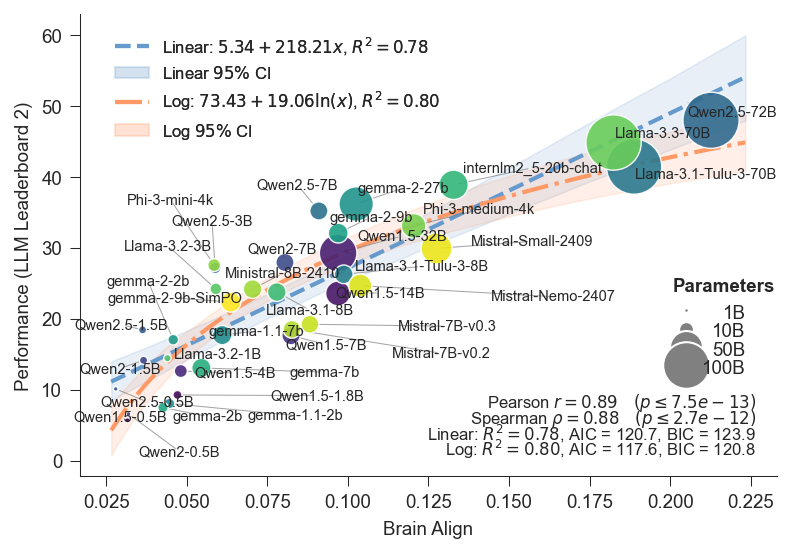

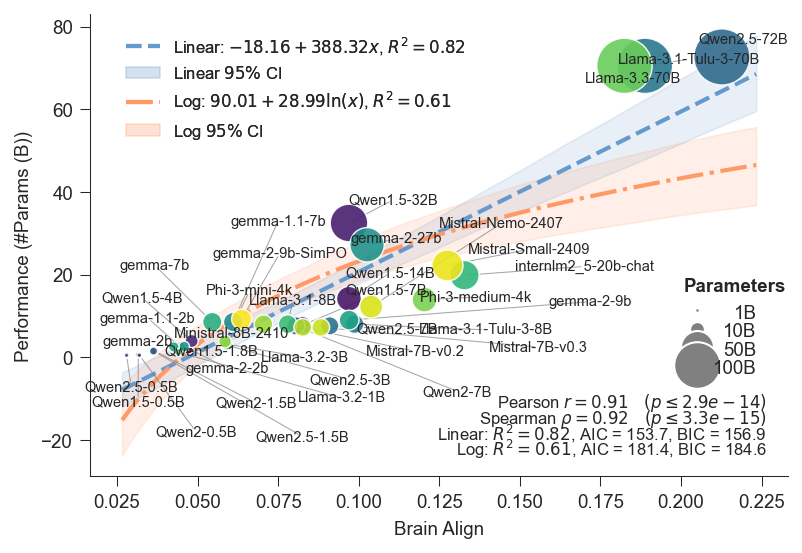

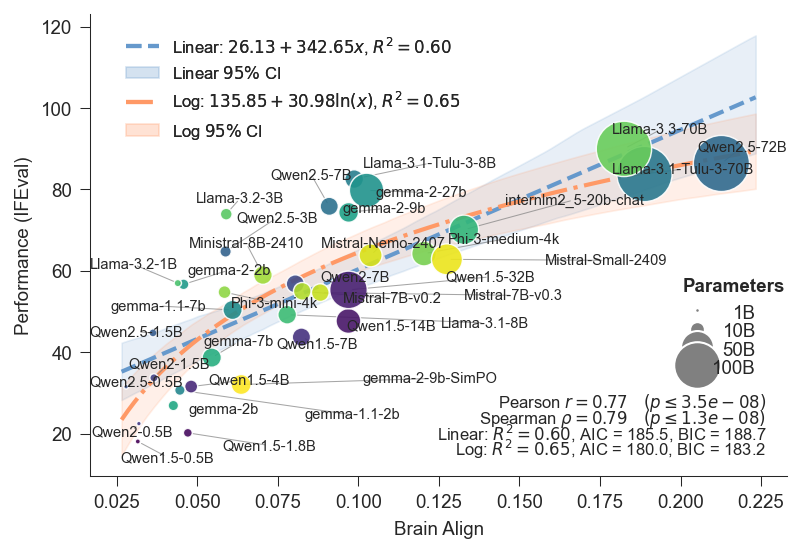

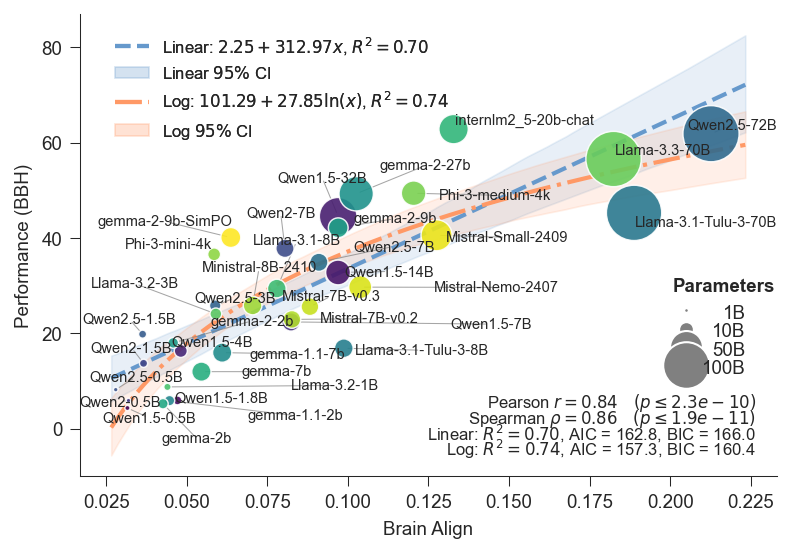

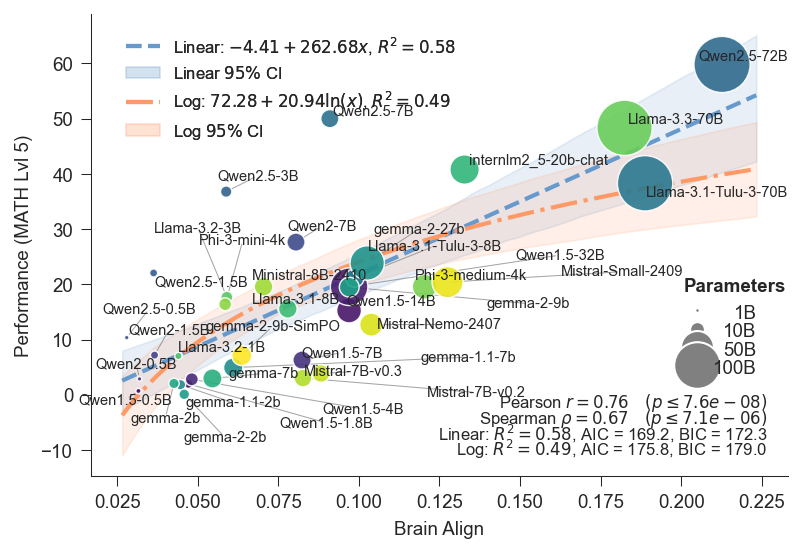

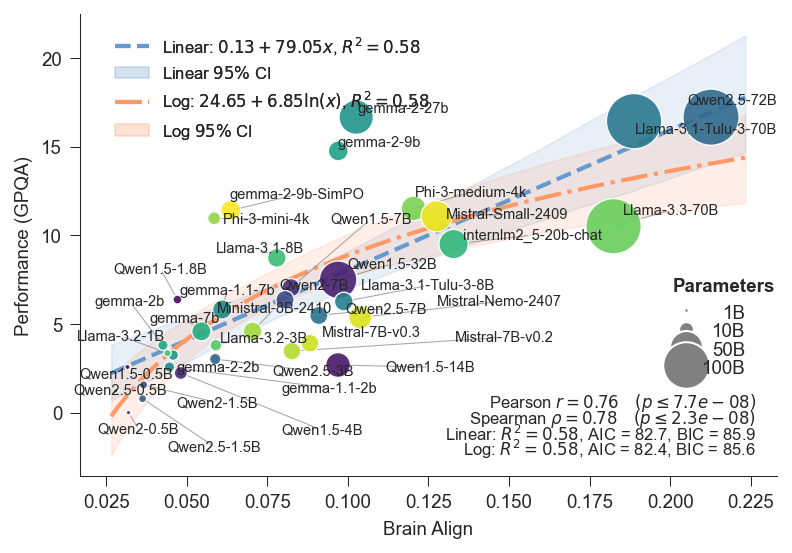

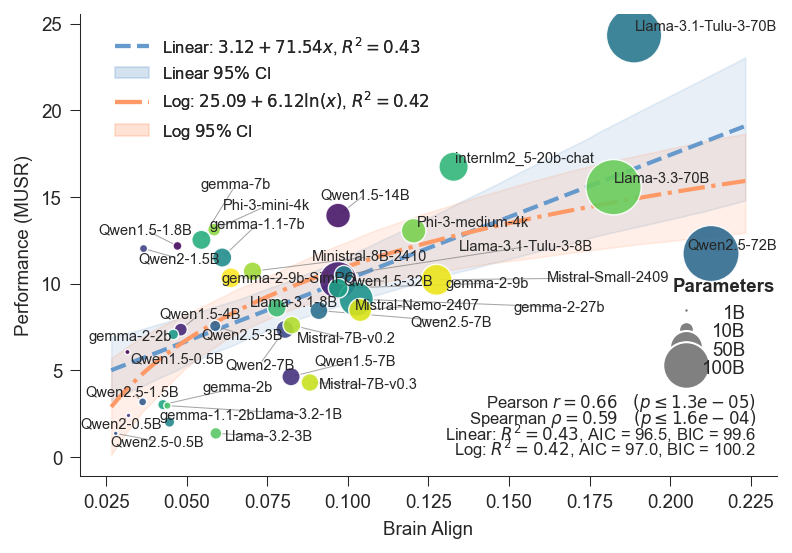

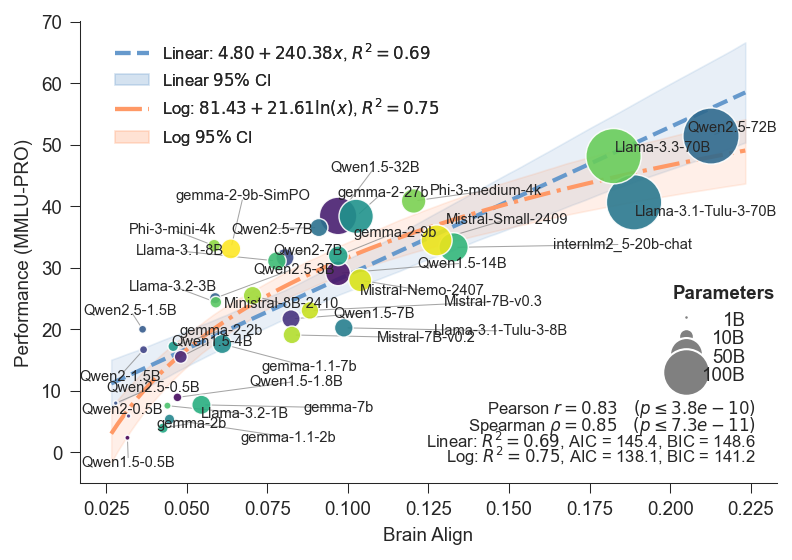

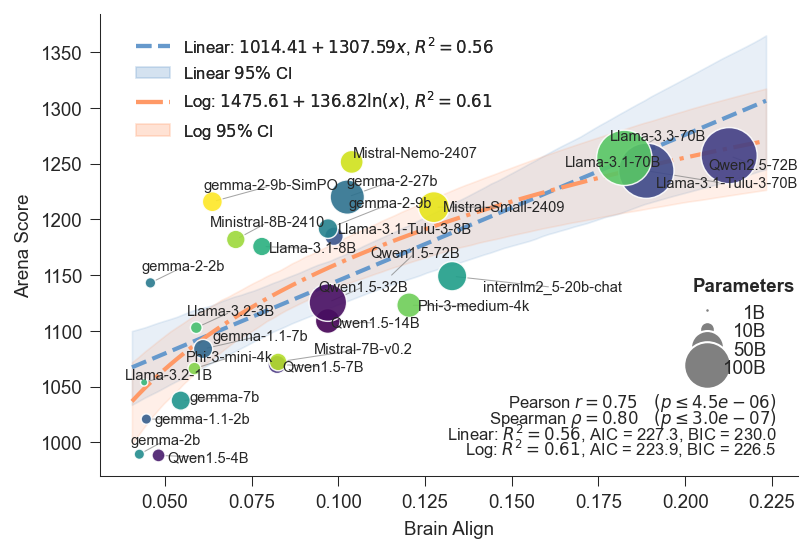

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

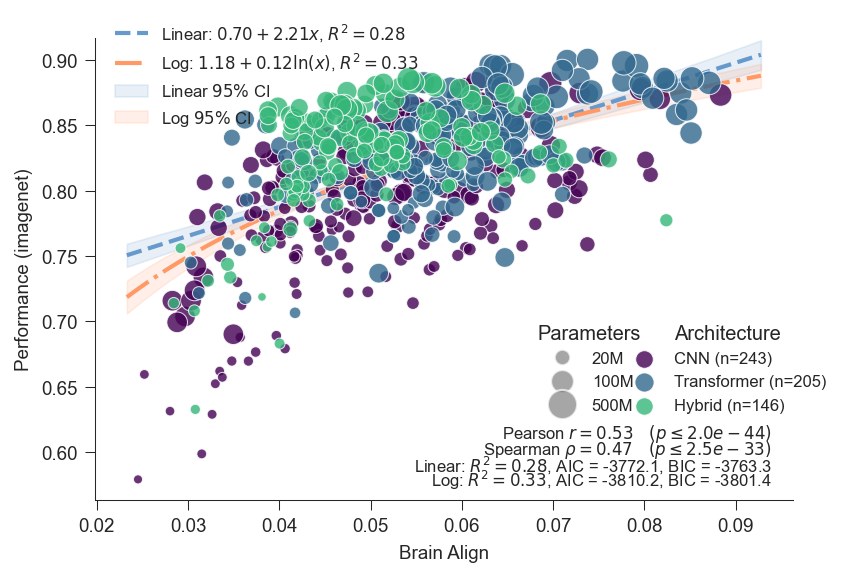

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

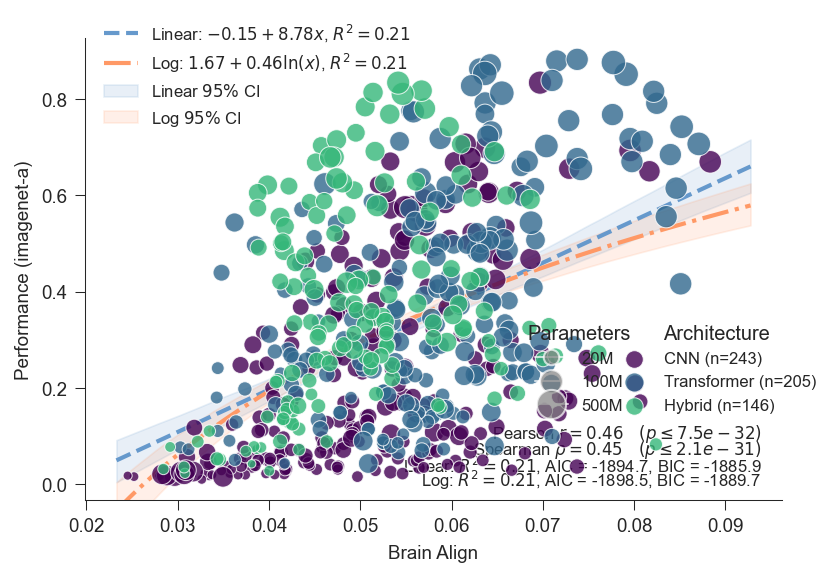

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

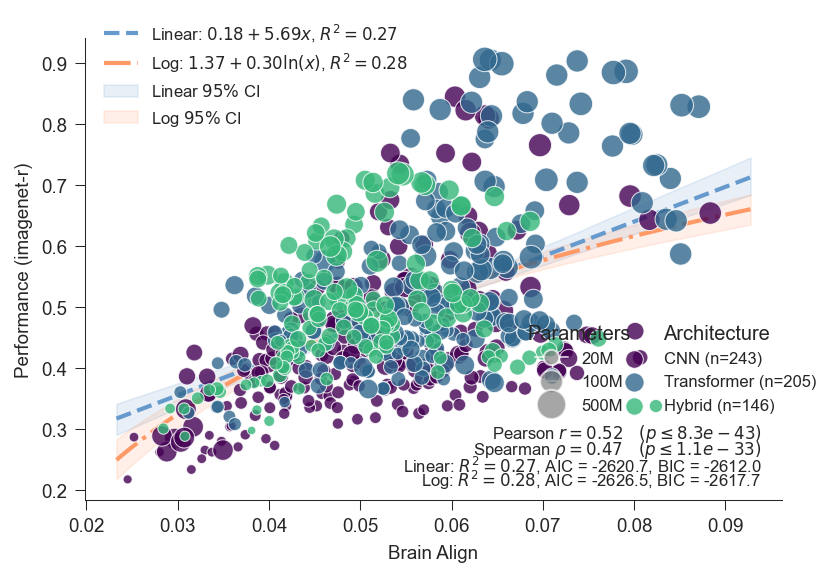

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

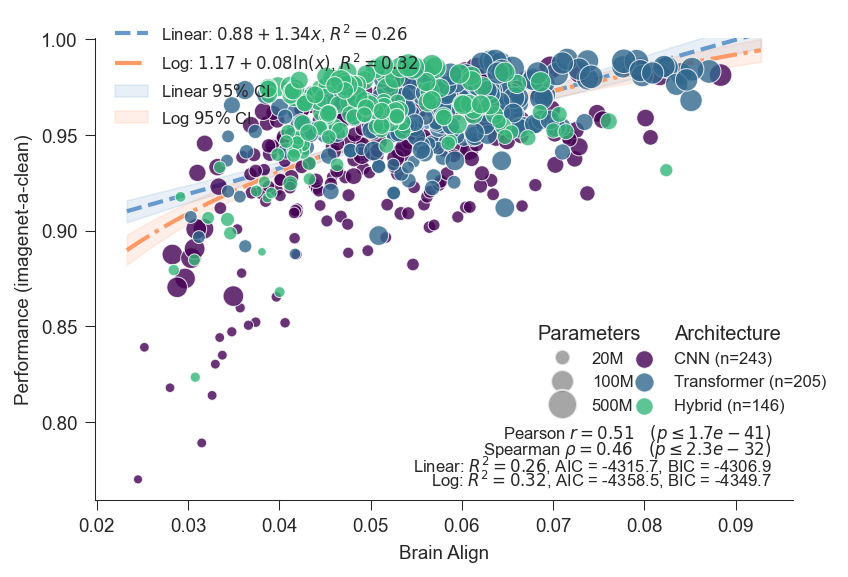

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

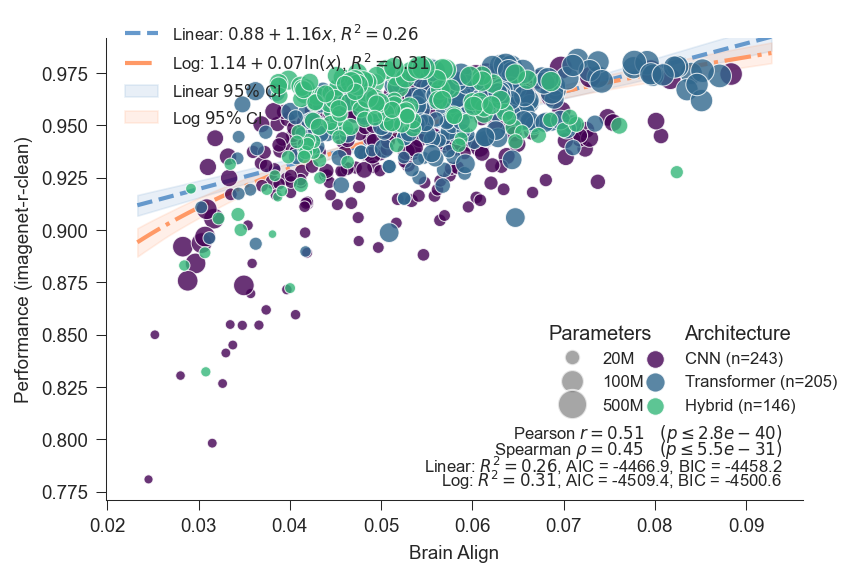

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

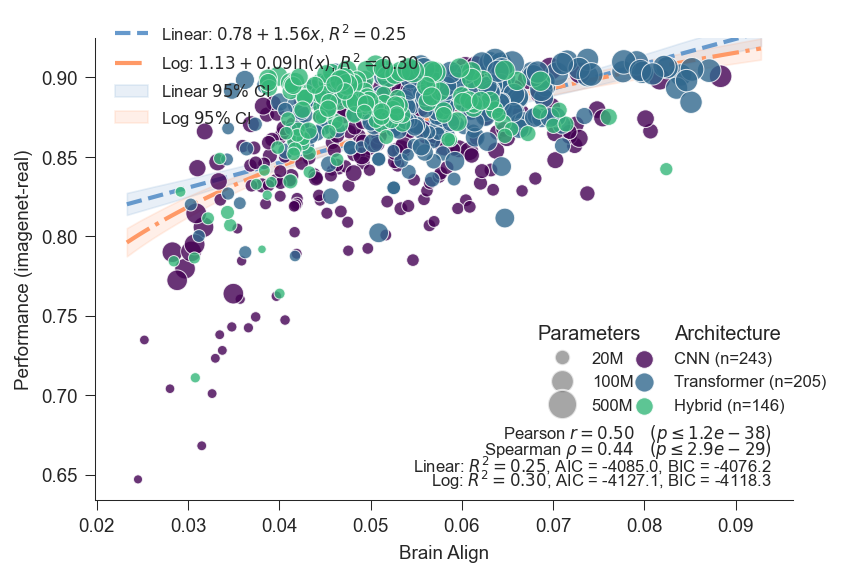

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

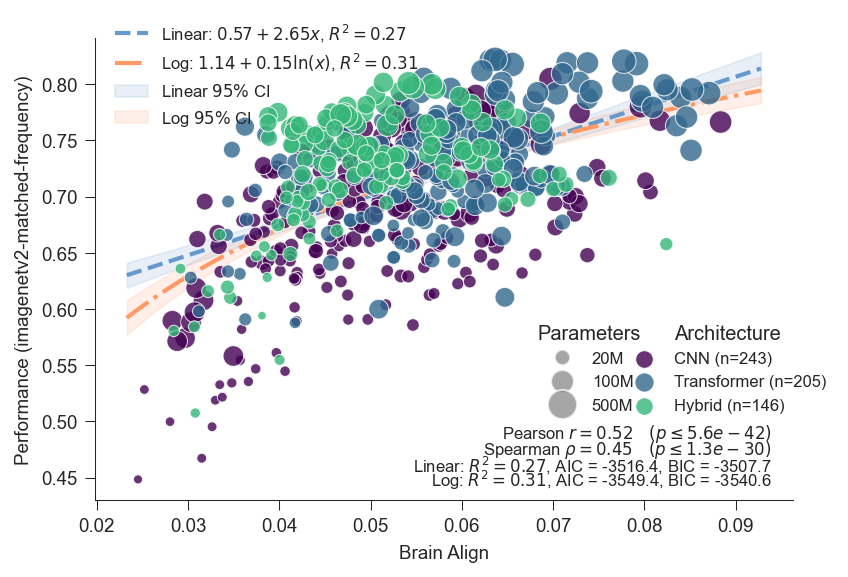

/tmp/ipykernel_213228/3367963126.py:594: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



Cats: {'CNN': 243, 'Transformer': 205, 'Hybrid': 146}


<Figure size 900x600 with 0 Axes>

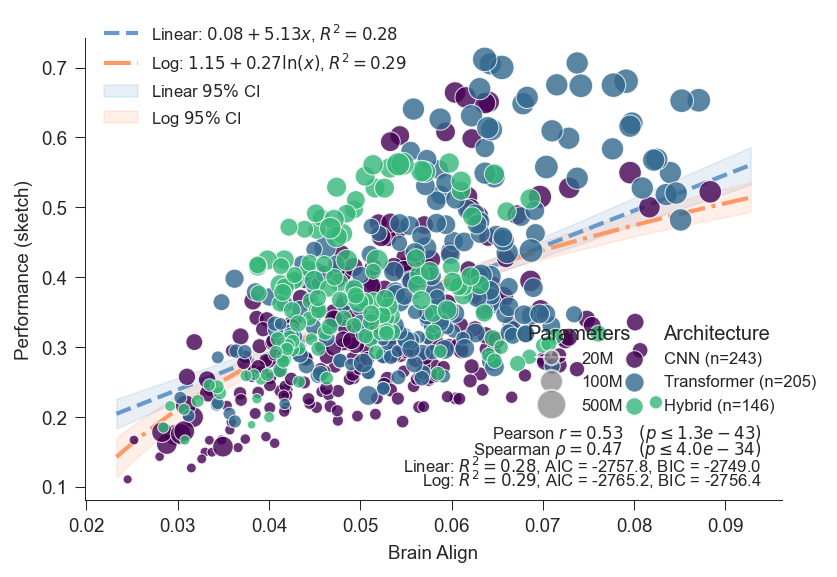

In [7]:
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 9,
    'axes.labelsize': 9, # 8
    'axes.titlesize': 9,
    'xtick.labelsize': 9, # 8
    'ytick.labelsize': 9, # 8
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 300,
    'figure.dpi': 150,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})


for sigma in [36]:  # 20, 28, 44, 52, 60, 68, 76, 84, 92, 100, change this
    print(f"Processing sigma={sigma}")
    sub_language_df = language_df[
        (language_df['metric'] == f'cka_{sigma}')
    ]

    sub_leaderboard_df = sub_language_df.dropna(subset=['BBH'])


    sub_arena_df = sub_language_df.dropna(subset=['elo'])


    arena_max_region_avg_subj_df = sub_arena_df.groupby(
        [
            'relative_src_feature',
            'tgt_feature',
            'src_model'
        ],
        as_index=False
    )[['score', 'Average ⬆️', '#Params (B)', 'elo']].mean()
    # arena_max_region_avg_subj_df = arena_max_region_avg_subj_df.groupby(
    #     [
    #         'src_model'
    #     ],
    #     as_index=False
    # )[['score', 'Average ⬆️', '#Params (B)', 'elo']].mean()
    arena_max_region_avg_subj_df = (
        arena_max_region_avg_subj_df.groupby(
            [
                'src_model'
            ],
            as_index=False
        )[["score", "Average ⬆️", "#Params (B)", "elo"]]
        .apply(lambda x: x.nlargest(5, "score").mean())
        .reset_index(drop=True)
    )

    leaderboard_max_region_avg_subj_df = sub_leaderboard_df.groupby(
        [
            'relative_src_feature',
            'tgt_feature',
            'src_model'
        ],
        as_index=False
    )[[
        'score',
        'Average ⬆️',
        '#Params (B)',
        'elo',
        'IFEval',
        'BBH',
        'MATH Lvl 5',
        'GPQA',
        'MUSR',
        'MMLU-PRO'
    ]].mean()
    leaderboard_max_region_avg_subj_df = (
        leaderboard_max_region_avg_subj_df.groupby(
            [
                'src_model'
            ],
            as_index=False
        )[[
            'score',
            'Average ⬆️',
            '#Params (B)',
            'elo',
            'IFEval',
            'BBH',
            'MATH Lvl 5',
            'GPQA',
            'MUSR',
            'MMLU-PRO'
        ]]
        .apply(lambda x: x.nlargest(5, "score").mean())
        .reset_index(drop=True)
    )

    # Define linear function for fitting
    def linear_func(x, a, b):
        """Linear function: a + b*x"""
        return a + b * x

    # Define logarithmic function for fitting
    def log_func(x, a, b):
        """Logarithmic function: a + b*log(x)"""
        return a + b * np.log(x)


    for benchmark in [
        'Average ⬆️',
        '#Params (B)',
        'IFEval',
        'BBH',
        'MATH Lvl 5',
        'GPQA',
        'MUSR',
        'MMLU-PRO'
    ]:
        # Create the figure for the leaderboard plot only
        plt.figure(figsize=(6, 4))  # Increased figure size for better readability
        ax = plt.gca()
        benchmark_name = 'LLM Leaderboard 2' if 'Average' in benchmark else benchmark
        # Get data
        x = leaderboard_max_region_avg_subj_df['score']
        y = leaderboard_max_region_avg_subj_df[benchmark]
        model_names = leaderboard_max_region_avg_subj_df['src_model']
        param_sizes = leaderboard_max_region_avg_subj_df['#Params (B)']

        # Calculate correlation statistics first
        corr, p_value = pearsonr(x, y)
        spearman_corr, sp_p_value = stats.spearmanr(x, y)

        # Fit models
        try:
            # Generate points for the fit
            x_fit = np.linspace(min(x)*0.95, max(x)*1.05, 100)

            # ---------------- Linear Model Fitting ----------------
            # Fit linear model
            linear_params, linear_cov = curve_fit(linear_func, x, y)

            # Generate predictions
            y_linear = linear_func(x_fit, *linear_params)

            # Calculate predictions on original data points
            y_linear_pred = linear_func(x, *linear_params)

            # Calculate residuals and model statistics
            residuals_linear = y - y_linear_pred

            # Calculate R-squared
            ss_total = np.sum((y - np.mean(y)) ** 2)
            rss_linear = np.sum(residuals_linear ** 2)
            r2_linear = 1 - (rss_linear / ss_total)

            # Calculate AIC and BIC for linear model
            n = len(x)
            k_linear = 2  # Number of parameters in the linear model
            aic_linear = n * np.log(rss_linear/n) + 2 * k_linear
            bic_linear = n * np.log(rss_linear/n) + k_linear * np.log(n)

            # Plot linear model
            ax.plot(x_fit, y_linear, '--', color='#6699CC', linewidth=2,
                    label=f'Linear: ${linear_params[0]:.2f} + {linear_params[1]:.2f}x$, $R^2={r2_linear:.2f}$')

            # Calculate linear confidence intervals
            # Extract error in parameters
            perr_linear = np.sqrt(np.diag(linear_cov))
            # Monte Carlo for linear CI
            n_samples = 1000
            y_samples_linear = np.zeros((n_samples, len(x_fit)))
            linear_param_samples = np.random.multivariate_normal(linear_params, linear_cov, size=n_samples)
            for i, params in enumerate(linear_param_samples):
                y_samples_linear[i, :] = linear_func(x_fit, *params)
            y_lower_linear = np.percentile(y_samples_linear, 2.5, axis=0)
            y_upper_linear = np.percentile(y_samples_linear, 97.5, axis=0)
            ax.fill_between(x_fit, y_lower_linear, y_upper_linear, color='#6699CC', alpha=0.15, label='Linear $95\\%$ CI')

            # ---------------- Logarithmic Model Fitting ----------------
            # Fit logarithmic model
            log_params, log_cov = curve_fit(log_func, x, y)

            # Generate predictions
            y_log = log_func(x_fit, *log_params)

            # Calculate predictions on original data points
            y_log_pred = log_func(x, *log_params)

            # Calculate residuals and model statistics
            residuals_log = y - y_log_pred

            # Calculate R-squared
            rss_log = np.sum(residuals_log ** 2)
            r2_log = 1 - (rss_log / ss_total)

            # Calculate AIC and BIC for logarithmic model
            k_log = 2  # Number of parameters in the log model
            aic_log = n * np.log(rss_log/n) + 2 * k_log
            bic_log = n * np.log(rss_log/n) + k_log * np.log(n)

            # Plot logarithmic model with a different color
            ax.plot(x_fit, y_log, '-.', color='#FF9966', linewidth=2,
                    label=f'Log: ${log_params[0]:.2f} + {log_params[1]:.2f}\ln(x)$, $R^2={r2_log:.2f}$')

            # Calculate logarithmic confidence intervals
            # Extract error in parameters
            perr_log = np.sqrt(np.diag(log_cov))
            # Monte Carlo for log CI
            y_samples_log = np.zeros((n_samples, len(x_fit)))
            log_param_samples = np.random.multivariate_normal(log_params, log_cov, size=n_samples)
            for i, params in enumerate(log_param_samples):
                y_samples_log[i, :] = log_func(x_fit, *params)
            y_lower_log = np.percentile(y_samples_log, 2.5, axis=0)
            y_upper_log = np.percentile(y_samples_log, 97.5, axis=0)
            ax.fill_between(x_fit, y_lower_log, y_upper_log, color='#FF9966', alpha=0.15, label='Log $95\\%$ CI')

        except Exception as e:
            print(f"Model fitting failed: {e}")

        # Add scatter points with moderate size and improved visibility
        scatter = ax.scatter(
            x, y,
            s=param_sizes*10,  # Reduced size scaling
            c=range(len(x)),   # Use range for sequential coloring
            cmap='viridis',    # Use a nice colormap
            alpha=0.9,
            edgecolor='white',
            linewidth=0.7,
            zorder=5  # Ensure points are above the confidence intervals
        )

        # Add text for ALL points (including smaller models)
        texts = []
        for i in range(len(x)):
            name = '_'.join(model_names[i].split('_')[1:]).replace('-Instruct', '').replace('-Chat', '').replace('-it', '').replace('-instruct', '')
            # Set zorder to a high value (higher than scatter points) to ensure text is on top
            texts.append(ax.text(x[i], y[i], name, fontsize=7, zorder=10))

        # Use adjust_text with better parameters for text placement
        adjust_text(texts,
                    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.7),
                    force_text=(0.8, 0.8),  # Increased force to spread labels more
                    force_points=(0.2, 0.2),  # Add some force to move text away from points
                    expand_points=(1.7, 1.7),  # Expand the area around points
                    expand_text=(1.2, 1.2),    # Expand the area around text
                    zorder=11)                  # Ensure the connecting lines are also on top

        # Improve plot appearance
        # ax.set_title('Model Score vs Average Performance', fontweight='bold')
        ax.set_xlabel('Brain Align')
        ax.set_ylabel(f'Performance ({benchmark_name})')

        sns.despine(ax=ax)

        # Create the model fit legend in the top left
        fit_handles, fit_labels = ax.get_legend_handles_labels()
        fit_legend = ax.legend(fit_handles, fit_labels, loc='upper left', frameon=False, fontsize=8, bbox_to_anchor=(0.03, 0.99), )
        plt.gca().add_artist(fit_legend)  # Add to canvas and keep ax for more legends

        # Create size legend elements below the fit legend
        size_values = [1.0, 10.0, 50.0, 100.]  # Size values
        size_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                                 markersize=np.sqrt(s*5), alpha=0.7) for s in size_values]
        size_labels = [f"{s:.0f}B" for s in size_values]

        # Calculate position below the fit legend
        fit_bbox = fit_legend.get_window_extent(renderer=plt.gcf().canvas.get_renderer())
        fit_height = fit_bbox.height / plt.gcf().dpi * 72  # Convert to points
        # y_pos = 1.0 - (fit_height / plt.gcf().get_figheight() / 72) - 0.1  # Small gap
        y_pos = 0.4

        # Add parameters title
        ax.text(0.85, y_pos, "Parameters", transform=ax.transAxes, fontweight='bold')

        # Add size markers manually with proper alignment
        for i, (handle, label) in enumerate(zip(size_handles, size_labels)):
            y = y_pos - 0.04*(i+1)  # Adjust vertical spacing
            # Add the marker and label
            ax.plot(0.87, y, marker='o', markersize=handle.get_markersize(),
                    markerfacecolor='gray', markeredgecolor='white',
                    transform=ax.transAxes, linestyle='none')
            ax.text(0.955, y-0.007, label, transform=ax.transAxes, va='center', ha='right')

        # Create statistics legend in the bottom right
        stats_entries = [
            f"Pearson $r = {corr:.2f} \quad (p \leq {p_value:.1e})$",
            f"Spearman $\\rho = {spearman_corr:.2f} \quad (p \leq {sp_p_value:.1e})$",
            f"Linear: $R^2 = {r2_linear:.2f}$, AIC = {aic_linear:.1f}, BIC = {bic_linear:.1f}",
            f"Log: $R^2 = {r2_log:.2f}$, AIC = {aic_log:.1f}, BIC = {bic_log:.1f}"
        ]

        # Add model comparison information
        if r2_log > r2_linear:
            better_model = "Log"
            improvement = ((r2_log - r2_linear) / r2_linear) * 100
        else:
            better_model = "Linear"
            improvement = ((r2_linear - r2_log) / r2_log) * 100


        stats_y_start = 0.15  # Adjusted starting position for more text
        for i, entry in enumerate(stats_entries):
            ax.text(0.97, stats_y_start - 0.035*(i), entry, transform=ax.transAxes, ha='right', fontsize=8)

        # Adjust layout and save
        # plt.tight_layout()
        benchmark_name = benchmark_name.replace(' ', '_')
        os.makedirs(f"{FIGURES_DIR}/performance/{sigma}", exist_ok=True)
        plt.savefig(f"{FIGURES_DIR}/performance/{sigma}/{benchmark_name}.pdf", bbox_inches='tight')
        plt.show()

    # Create the figure for the leaderboard plot only
    plt.figure(figsize=(6, 4))  # Increased figure size for better readability
    ax = plt.gca()

    # Get data
    x = arena_max_region_avg_subj_df['score']
    y = arena_max_region_avg_subj_df['elo']
    model_names = arena_max_region_avg_subj_df['src_model']
    param_sizes = arena_max_region_avg_subj_df['#Params (B)']

    # Calculate correlation statistics first
    corr, p_value = pearsonr(x, y)
    spearman_corr, sp_p_value = stats.spearmanr(x, y)

    # Fit models
    try:
        # Generate points for the fit
        x_fit = np.linspace(min(x)*0.95, max(x)*1.05, 100)

        # ---------------- Linear Model Fitting ----------------
        # Fit linear model
        linear_params, linear_cov = curve_fit(linear_func, x, y)

        # Generate predictions
        y_linear = linear_func(x_fit, *linear_params)

        # Calculate predictions on original data points
        y_linear_pred = linear_func(x, *linear_params)

        # Calculate residuals and model statistics
        residuals_linear = y - y_linear_pred

        # Calculate R-squared
        ss_total = np.sum((y - np.mean(y)) ** 2)
        rss_linear = np.sum(residuals_linear ** 2)
        r2_linear = 1 - (rss_linear / ss_total)

        # Calculate AIC and BIC for linear model
        n = len(x)
        k_linear = 2  # Number of parameters in the linear model
        aic_linear = n * np.log(rss_linear/n) + 2 * k_linear
        bic_linear = n * np.log(rss_linear/n) + k_linear * np.log(n)

        # Plot linear model
        ax.plot(x_fit, y_linear, '--', color='#6699CC', linewidth=2,
                label=f'Linear: ${linear_params[0]:.2f} + {linear_params[1]:.2f}x$, $R^2={r2_linear:.2f}$')

        # Calculate linear confidence intervals
        # Extract error in parameters
        perr_linear = np.sqrt(np.diag(linear_cov))
        # Monte Carlo for linear CI
        n_samples = 1000
        y_samples_linear = np.zeros((n_samples, len(x_fit)))
        linear_param_samples = np.random.multivariate_normal(linear_params, linear_cov, size=n_samples)
        for i, params in enumerate(linear_param_samples):
            y_samples_linear[i, :] = linear_func(x_fit, *params)
        y_lower_linear = np.percentile(y_samples_linear, 2.5, axis=0)
        y_upper_linear = np.percentile(y_samples_linear, 97.5, axis=0)
        ax.fill_between(x_fit, y_lower_linear, y_upper_linear, color='#6699CC', alpha=0.15, label='Linear $95\\%$ CI')

        # ---------------- Logarithmic Model Fitting ----------------
        # Fit logarithmic model
        log_params, log_cov = curve_fit(log_func, x, y)

        # Generate predictions
        y_log = log_func(x_fit, *log_params)

        # Calculate predictions on original data points
        y_log_pred = log_func(x, *log_params)

        # Calculate residuals and model statistics
        residuals_log = y - y_log_pred

        # Calculate R-squared
        rss_log = np.sum(residuals_log ** 2)
        r2_log = 1 - (rss_log / ss_total)

        # Calculate AIC and BIC for logarithmic model
        k_log = 2  # Number of parameters in the log model
        aic_log = n * np.log(rss_log/n) + 2 * k_log
        bic_log = n * np.log(rss_log/n) + k_log * np.log(n)

        # Plot logarithmic model with a different color
        ax.plot(x_fit, y_log, '-.', color='#FF9966', linewidth=2,
                label=f'Log: ${log_params[0]:.2f} + {log_params[1]:.2f}\ln(x)$, $R^2={r2_log:.2f}$')

        # Calculate logarithmic confidence intervals
        # Extract error in parameters
        perr_log = np.sqrt(np.diag(log_cov))
        # Monte Carlo for log CI
        y_samples_log = np.zeros((n_samples, len(x_fit)))
        log_param_samples = np.random.multivariate_normal(log_params, log_cov, size=n_samples)
        for i, params in enumerate(log_param_samples):
            y_samples_log[i, :] = log_func(x_fit, *params)
        y_lower_log = np.percentile(y_samples_log, 2.5, axis=0)
        y_upper_log = np.percentile(y_samples_log, 97.5, axis=0)
        ax.fill_between(x_fit, y_lower_log, y_upper_log, color='#FF9966', alpha=0.15, label='Log $95\\%$ CI')

    except Exception as e:
        print(f"Model fitting failed: {e}")

    # Add scatter points with moderate size and improved visibility
    scatter = ax.scatter(
        x, y,
        s=param_sizes*10,  # Reduced size scaling
        c=range(len(x)),   # Use range for sequential coloring
        cmap='viridis',    # Use a nice colormap
        alpha=0.9,
        edgecolor='white',
        linewidth=0.7,
        zorder=5  # Ensure points are above the confidence intervals
    )

    # Add text for ALL points (including smaller models)
    texts = []
    for i in range(len(x)):
        name = '_'.join(model_names[i].split('_')[1:]).replace('-Instruct', '').replace('-Chat', '').replace('-it', '').replace('-instruct', '')
        # Set zorder to a high value (higher than scatter points) to ensure text is on top
        texts.append(ax.text(x[i], y[i], name, fontsize=7, zorder=10))

    # Use adjust_text with better parameters for text placement
    adjust_text(texts,
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.7),
                force_text=(0.8, 0.8),  # Increased force to spread labels more
                force_points=(0.2, 0.2),  # Add some force to move text away from points
                expand_points=(1.7, 1.7),  # Expand the area around points
                expand_text=(1.2, 1.2),    # Expand the area around text
                zorder=11)                  # Ensure the connecting lines are also on top

    # Improve plot appearance
    # ax.set_title('Model Score vs Average Performance', fontweight='bold')
    ax.set_xlabel('Brain Align')
    ax.set_ylabel('Arena Score')

    # ax.set_xlim(0.03, 0.25)
    # ax.set_ylim(0, 62)
    # ax.grid(True, linestyle='--', alpha=0.3)
    sns.despine(ax=ax)

    # Create the model fit legend in the top left
    fit_handles, fit_labels = ax.get_legend_handles_labels()
    fit_legend = ax.legend(fit_handles, fit_labels, loc='upper left', frameon=False, fontsize=8, bbox_to_anchor=(0.03, 0.99), )
    plt.gca().add_artist(fit_legend)  # Add to canvas and keep ax for more legends

    # Create size legend elements below the fit legend
    size_values = [1.0, 10.0, 50.0, 100.]  # Size values
    size_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                             markersize=np.sqrt(s*5), alpha=0.7) for s in size_values]
    size_labels = [f"{s:.0f}B" for s in size_values]

    # Calculate position below the fit legend
    fit_bbox = fit_legend.get_window_extent(renderer=plt.gcf().canvas.get_renderer())
    fit_height = fit_bbox.height / plt.gcf().dpi * 72  # Convert to points
    # y_pos = 1.0 - (fit_height / plt.gcf().get_figheight() / 72) - 0.1  # Small gap
    y_pos = 0.4

    # Add parameters title
    ax.text(0.85, y_pos, "Parameters", transform=ax.transAxes, fontweight='bold')

    # Add size markers manually with proper alignment
    for i, (handle, label) in enumerate(zip(size_handles, size_labels)):
        y = y_pos - 0.04*(i+1)  # Adjust vertical spacing
        # Add the marker and label
        ax.plot(0.87, y, marker='o', markersize=handle.get_markersize(),
                markerfacecolor='gray', markeredgecolor='white',
                transform=ax.transAxes, linestyle='none')
        ax.text(0.955, y-0.007, label, transform=ax.transAxes, va='center', ha='right')

    # Create statistics legend in the bottom right
    stats_entries = [
        f"Pearson $r = {corr:.2f} \quad (p \leq {p_value:.1e})$",
        f"Spearman $\\rho = {spearman_corr:.2f} \quad (p \leq {sp_p_value:.1e})$",
        f"Linear: $R^2 = {r2_linear:.2f}$, AIC = {aic_linear:.1f}, BIC = {bic_linear:.1f}",
        f"Log: $R^2 = {r2_log:.2f}$, AIC = {aic_log:.1f}, BIC = {bic_log:.1f}"
    ]

    # Add model comparison information
    if r2_log > r2_linear:
        better_model = "Log"
        improvement = ((r2_log - r2_linear) / r2_linear) * 100
    else:
        better_model = "Linear"
        improvement = ((r2_linear - r2_log) / r2_log) * 100


    stats_y_start = 0.15  # Adjusted starting position for more text
    for i, entry in enumerate(stats_entries):
        ax.text(0.97, stats_y_start - 0.035*(i), entry, transform=ax.transAxes, ha='right', fontsize=8)

    # Adjust layout and save
    # plt.tight_layout()
    os.makedirs(f"{FIGURES_DIR}/performance/{sigma}", exist_ok=True)
    plt.savefig(f"{FIGURES_DIR}/performance/{sigma}/arena.pdf", bbox_inches='tight', dpi=300)
    plt.show()



    sub_vision_df = vision_df[
        (vision_df['metric'] == f'cka_{sigma}')
    ]

    vision_max_region_avg_subj_df = sub_vision_df.groupby(
        [
            'relative_src_feature',
            'tgt_feature',
            'src_model'
        ],
        as_index=False
    )[[
        'score',
        '#Params (M)',
        'imagenet',
        'imagenet-a',
        'imagenet-a-clean',
        'imagenet-r',
        'imagenet-r-clean',
        'imagenet-real',
        'imagenetv2-matched-frequency',
        'sketch'
    ]].mean()

    vision_max_region_avg_subj_df = (
        vision_max_region_avg_subj_df.groupby(
            [
                'src_model'
            ],
            as_index=False
        )[[
            'score',
            '#Params (M)',
            'imagenet',
            'imagenet-a',
            'imagenet-a-clean',
            'imagenet-r',
            'imagenet-r-clean',
            'imagenet-real',
            'imagenetv2-matched-frequency',
            'sketch'
        ]].apply(lambda x: x.nlargest(5, "score").mean()).reset_index(drop=True)
    )

    vision_max_region_avg_subj_df['src_cls'] = vision_max_region_avg_subj_df['src_model']# .apply(lambda row: row.split('_')[0].split('.')[0])

    # Define linear function for fitting
    def linear_func(x, a, b):
        """Linear function: a + b*x"""
        return a + b * x

    # Define logarithmic function for fitting
    def log_func(x, a, b):
        """Logarithmic function: a + b*log(x)"""
        return a + b * np.log(x)


    for metric in [
        "imagenet",
        "imagenet-a",
        "imagenet-r",
        "imagenet-a-clean",
        "imagenet-r-clean",
        "imagenet-real",
        "imagenetv2-matched-frequency",
        "sketch"
    ]:
        # Create the figure for the vision model plot
        plt.figure(figsize=(6, 4))
        fig, ax = plt.subplots(figsize=(6, 4))

        # Get data
        x = vision_max_region_avg_subj_df['score']
        y = vision_max_region_avg_subj_df[metric]
        model_names = vision_max_region_avg_subj_df['src_model']
        param_sizes = vision_max_region_avg_subj_df['#Params (M)']

        vision_max_region_avg_subj_df['simplified_category'] = [
            get_model_category(model) for model in vision_max_region_avg_subj_df['src_cls']
        ]
        model_categories = vision_max_region_avg_subj_df['simplified_category']


        viridis = cm.get_cmap('viridis', 4)
        category_colors = {
            'CNN': mcolors.rgb2hex(viridis(0)),
            'Transformer': mcolors.rgb2hex(viridis(1)),
            'Hybrid': mcolors.rgb2hex(viridis(2)),
        }

        category_counts = vision_max_region_avg_subj_df['simplified_category'].value_counts()
        print(f"Cats: {category_counts.to_dict()}")

        # Calculate correlation statistics first
        corr, p_value = pearsonr(x, y)
        spearman_corr, sp_p_value = stats.spearmanr(x, y)

        x_fit = np.linspace(min(x)*0.95, max(x)*1.05, 100)

        # ---------------- Linear Model Fitting ----------------
        # Fit linear model
        linear_params, linear_cov = curve_fit(linear_func, x, y)

        # Generate predictions
        y_linear = linear_func(x_fit, *linear_params)

        # Calculate predictions on original data points
        y_linear_pred = linear_func(x, *linear_params)

        # Calculate residuals and model statistics
        residuals_linear = y - y_linear_pred

        # Calculate R-squared
        ss_total = np.sum((y - np.mean(y)) ** 2)
        rss_linear = np.sum(residuals_linear ** 2)
        r2_linear = 1 - (rss_linear / ss_total)

        # Calculate AIC and BIC for linear model
        n = len(x)
        k_linear = 2  # Number of parameters in the linear model
        aic_linear = n * np.log(rss_linear/n) + 2 * k_linear
        bic_linear = n * np.log(rss_linear/n) + k_linear * np.log(n)

        # Plot linear model
        line1, = ax.plot(x_fit, y_linear, '--', color='#6699CC', linewidth=2,
                   label=f'Linear: ${linear_params[0]:.2f} + {linear_params[1]:.2f}x$, $R^2={r2_linear:.2f}$')

        # Calculate linear confidence intervals
        # Monte Carlo for linear CI
        n_samples = 1000
        y_samples_linear = np.zeros((n_samples, len(x_fit)))
        linear_param_samples = np.random.multivariate_normal(linear_params, linear_cov, size=n_samples)
        for i, params in enumerate(linear_param_samples):
            y_samples_linear[i, :] = linear_func(x_fit, *params)
        y_lower_linear = np.percentile(y_samples_linear, 2.5, axis=0)
        y_upper_linear = np.percentile(y_samples_linear, 97.5, axis=0)
        ci1 = ax.fill_between(x_fit, y_lower_linear, y_upper_linear, color='#6699CC', alpha=0.15, label='Linear $95\\%$ CI')

        # ---------------- Logarithmic Model Fitting ----------------
        # Fit logarithmic model
        log_params, log_cov = curve_fit(log_func, x, y)

        # Generate predictions
        y_log = log_func(x_fit, *log_params)

        # Calculate predictions on original data points
        y_log_pred = log_func(x, *log_params)

        # Calculate residuals and model statistics
        residuals_log = y - y_log_pred

        # Calculate R-squared
        rss_log = np.sum(residuals_log ** 2)
        r2_log = 1 - (rss_log / ss_total)

        # Calculate AIC and BIC for logarithmic model
        k_log = 2  # Number of parameters in the log model
        aic_log = n * np.log(rss_log/n) + 2 * k_log
        bic_log = n * np.log(rss_log/n) + k_log * np.log(n)

        # Plot logarithmic model with a different color
        line2, = ax.plot(x_fit, y_log, '-.', color='#FF9966', linewidth=2,
                   label=f'Log: ${log_params[0]:.2f} + {log_params[1]:.2f}\ln(x)$, $R^2={r2_log:.2f}$')

        # Calculate logarithmic confidence intervals
        # Monte Carlo for log CI
        y_samples_log = np.zeros((n_samples, len(x_fit)))
        log_param_samples = np.random.multivariate_normal(log_params, log_cov, size=n_samples)
        for i, params in enumerate(log_param_samples):
            y_samples_log[i, :] = log_func(x_fit, *params)
        y_lower_log = np.percentile(y_samples_log, 2.5, axis=0)
        y_upper_log = np.percentile(y_samples_log, 97.5, axis=0)
        ci2 = ax.fill_between(x_fit, y_lower_log, y_upper_log, color='#FF9966', alpha=0.15, label='Log $95\\%$ CI')

        scatter_plots = {}

        for category in ['CNN', 'Transformer', 'Hybrid']:
            mask = model_categories == category
            if sum(mask) > 0:

                log_sizes = np.log(param_sizes[mask] + 1) * 20  # +1 avoid log(0) && scaling x20
                sc = ax.scatter(
                    x[mask], y[mask],
                    s=log_sizes,
                    c=category_colors[category],
                    label=f"{category} (n={sum(mask)})",
                    alpha=0.8,
                    edgecolor='white',
                    linewidth=0.5,
                    marker='o',
                    zorder=5
                )
                scatter_plots[category] = sc


        # Improve plot appearance
        ax.set_xlabel('Brain Align')
        ax.set_ylabel(f'Performance ({metric})')

        # Set y-axis limits based on data range with some padding
        y_range = max(y) - min(y)
        ax.set_ylim(min(y) - 0.05*y_range, max(y) + 0.05*y_range)

        sns.despine(ax=ax)

        # Create size legend elements with logarithmic scaling
        size_values = [20.0, 100.0, 500.0]  # Size values in million parameters
        # Calculate marker sizes using the same logarithmic scaling as in the scatter plot
        log_marker_sizes = np.log(.1 * np.array(size_values) + 1) * 50
        size_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                                 markersize=np.sqrt(s), alpha=0.7) for s in log_marker_sizes]
        size_labels = [f"{int(s)}M" for s in size_values]


        size_legend = fig.legend(
            size_handles, size_labels,
            title="Parameters",
            loc='center left',

            bbox_to_anchor=(0.60, 0.33),
            frameon=False,
            # fontsize=8
        )

        fit_handles = [line1, line2, ci1, ci2]
        fit_labels = [
            f'Linear: ${linear_params[0]:.2f} + {linear_params[1]:.2f}x$, $R^2={r2_linear:.2f}$',
            f'Log: ${log_params[0]:.2f} + {log_params[1]:.2f}\ln(x)$, $R^2={r2_log:.2f}$',
            'Linear $95\\%$ CI',
            'Log $95\\%$ CI'
        ]
        fit_legend = fig.legend(
            fit_handles, fit_labels,
            loc='center left',
            frameon=False,
            bbox_to_anchor=(0.13, 0.82),

        )

        class_handles = []
        class_labels = []
        for category in ['CNN', 'Transformer', 'Hybrid']:
            if category in scatter_plots:
                class_handles.append(scatter_plots[category])
                count = sum(model_categories == category)
                class_labels.append(f"{category} (n={count})")

        class_legend = fig.legend(
            class_handles, class_labels,
            title="Architecture",
            loc='center left',
            bbox_to_anchor=(0.70, 0.33),
            frameon=False,
            # fontsize=8
        )

        # Create statistics legend in the bottom right
        stats_entries = [
            f"Pearson $r = {corr:.2f} \quad (p \leq {p_value:.1e})$",
            f"Spearman $\\rho = {spearman_corr:.2f} \quad (p \leq {sp_p_value:.1e})$",
            f"Linear: $R^2 = {r2_linear:.2f}$, AIC = {aic_linear:.1f}, BIC = {bic_linear:.1f}",
            f"Log: $R^2 = {r2_log:.2f}$, AIC = {aic_log:.1f}, BIC = {bic_log:.1f}"
        ]


        # Add statistics title and entries in bottom right
        stats_y_start = 0.135  # Adjusted starting position
        for i, entry in enumerate(stats_entries):
            ax.text(0.97, stats_y_start - 0.035*(i), entry, transform=ax.transAxes, ha='right', fontsize=8)


        # Save figures
        os.makedirs(f"{FIGURES_DIR}/performance/{sigma}", exist_ok=True)
        plt.savefig(f"{FIGURES_DIR}/performance/{sigma}/{metric}.pdf", bbox_inches='tight')
        plt.show()



## Statistical analysis

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests

import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Function to calculate correlation statistics with confidence intervals
def calculate_correlation_stats(df, x_col, y_col):
    """Calculate comprehensive correlation statistics between two columns"""
    # Remove any rows with NaN values
    df_clean = df.dropna(subset=[x_col, y_col])

    # Calculate Pearson correlation
    pearson_r, pearson_p = pearsonr(df_clean[x_col], df_clean[y_col])

    # Calculate Spearman correlation
    spearman_rho, spearman_p = stats.spearmanr(df_clean[x_col], df_clean[y_col])

    # Calculate 95% confidence intervals for Pearson correlation using Fisher's Z transformation
    z = 0.5 * np.log((1 + pearson_r) / (1 - pearson_r))
    se = 1 / np.sqrt(df_clean.shape[0] - 3)
    z_lower = z - 1.96 * se
    z_upper = z + 1.96 * se

    # Convert back to correlation coefficient
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)

    # Calculate 95% confidence intervals for Spearman using approximate method
    n = df_clean.shape[0]
    spearman_se = 0.6325 / np.sqrt(n - 1)  # Approximate SE for Spearman
    spearman_lower = spearman_rho - 1.96 * spearman_se
    spearman_upper = spearman_rho + 1.96 * spearman_se

    return {
        'n': df_clean.shape[0],
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'pearson_ci_lower': r_lower,
        'pearson_ci_upper': r_upper,
        'spearman_rho': spearman_rho,
        'spearman_p': spearman_p,
        'spearman_ci_lower': spearman_lower,
        'spearman_ci_upper': spearman_upper
    }

# Create Table 1: Model performance vs. brain Align correlation analysis
def create_correlation_table(leaderboard_df, vision_df, sim='score'):
    """
    Create a correlation analysis table using language and vision model dataframes

    Parameters:
    - leaderboard_df: DataFrame containing language model data
    - vision_df: DataFrame containing vision model data

    Returns:
    - DataFrame containing the correlation analysis table
    """
    # Language model metrics
    language_metrics = ['IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️', '#Params (B)', 'score', 'elo']

    # Vision model metrics
    vision_metrics = [
        "imagenet",
        "imagenet-a",
        "imagenet-r",
        "imagenet-a-clean",
        "imagenet-r-clean",
        "imagenet-real",
        "imagenetv2-matched-frequency",
        "sketch",
        '#Params (M)',
        'score'
    ]

    # Create empty lists to store results
    all_stats = []
    all_p_values = []

    # Calculate correlation statistics for each language metric
    language_stats_list = []
    for metric in language_metrics:
        if metric in leaderboard_df.columns:
            # Ensure there are sufficient non-NA values for correlation
            valid_data = leaderboard_df.dropna(subset=[sim, metric])
            if len(valid_data) >= 3:  # Minimum for correlation calculation
                stats = calculate_correlation_stats(leaderboard_df, sim, metric)
                stats['metric'] = metric
                stats['category'] = 'Language Models'
                language_stats_list.append(stats)
                all_p_values.extend([stats['pearson_p'], stats['spearman_p']])
                all_stats.append(stats)

    # Calculate correlation statistics for each vision metric
    vision_stats_list = []
    for metric in vision_metrics:
        if metric in vision_df.columns:
            # Ensure there are sufficient non-NA values for correlation
            valid_data = vision_df.dropna(subset=[sim, metric])
            if len(valid_data) >= 3:  # Minimum for correlation calculation
                stats = calculate_correlation_stats(vision_df, sim, metric)
                stats['metric'] = metric
                stats['category'] = 'Vision Models'
                vision_stats_list.append(stats)
                all_p_values.extend([stats['pearson_p'], stats['spearman_p']])
                all_stats.append(stats)

    # Average vision metrics results if multiple metrics are available
    if vision_stats_list:
        vision_stats_avg = {
            'n': np.mean([stat['n'] for stat in vision_stats_list]),
            'pearson_r': np.mean([stat['pearson_r'] for stat in vision_stats_list]),
            'pearson_p': np.mean([stat['pearson_p'] for stat in vision_stats_list]),
            'pearson_ci_lower': np.mean([stat['pearson_ci_lower'] for stat in vision_stats_list]),
            'pearson_ci_upper': np.mean([stat['pearson_ci_upper'] for stat in vision_stats_list]),
            'spearman_rho': np.mean([stat['spearman_rho'] for stat in vision_stats_list]),
            'spearman_p': np.mean([stat['spearman_p'] for stat in vision_stats_list]),
            'spearman_ci_lower': np.mean([stat['spearman_ci_lower'] for stat in vision_stats_list]),
            'spearman_ci_upper': np.mean([stat['spearman_ci_upper'] for stat in vision_stats_list]),
            'metric': 'Average',
            'category': 'Vision Models (Average)'
        }
        all_stats.append(vision_stats_avg)

    # Create standardized merged dataframe for cross-modality comparison
    # First add modality columns
    language_df_copy = leaderboard_df.copy()
    vision_df_copy = vision_df.copy()

    language_df_copy['modality'] = 'language'
    vision_df_copy['modality'] = 'vision'

    # Standardize scores within each modality
    language_df_copy['score_std'] = (language_df_copy[sim] - language_df_copy[sim].mean()) / language_df_copy[sim].std()
    vision_df_copy['score_std'] = (vision_df_copy[sim] - vision_df_copy[sim].mean()) / vision_df_copy[sim].std()

    # Create performance columns for combined analysis
    # For language models, use the average of available metrics
    available_lang_metrics = [m for m in language_metrics if m in language_df_copy.columns]
    if available_lang_metrics:
        language_df_copy['performance'] = language_df_copy[available_lang_metrics].mean(axis=1)
    else:
        # Fallback to Average ⬆️ if none of the specified metrics are available
        language_df_copy['performance'] = language_df_copy['Average ⬆️'] if 'Average ⬆️' in language_df_copy.columns else np.nan

    # For vision models, use imagenet as primary or average if multiple are available
    if 'imagenet' in vision_df_copy.columns:
        vision_df_copy['performance'] = vision_df_copy['imagenet']
    else:
        available_vision_metrics = [m for m in vision_metrics if m in vision_df_copy.columns]
        if available_vision_metrics:
            vision_df_copy['performance'] = vision_df_copy[available_vision_metrics].mean(axis=1)
        else:
            vision_df_copy['performance'] = np.nan

    # Standardize performance
    language_df_copy['performance_std'] = (language_df_copy['performance'] - language_df_copy['performance'].mean()) / language_df_copy['performance'].std()
    vision_df_copy['performance_std'] = (vision_df_copy['performance'] - vision_df_copy['performance'].mean()) / vision_df_copy['performance'].std()

    # Combine dataframes
    merged_df = pd.concat([language_df_copy, vision_df_copy], ignore_index=True)

    # Calculate stats for merged data if we have enough valid data
    valid_merged_data = merged_df.dropna(subset=['score_std', 'performance_std'])
    if len(valid_merged_data) >= 3:  # Minimum for correlation calculation
        merged_stats = calculate_correlation_stats(merged_df, 'score_std', 'performance_std')
        merged_stats['metric'] = 'Combined'
        merged_stats['category'] = 'Combined (Standardized)'
        all_stats.append(merged_stats)
        all_p_values.extend([merged_stats['pearson_p'], merged_stats['spearman_p']])

    # Apply FDR correction to p-values
    # First, make sure all_p_values has the correct number of entries
    if len(all_p_values) > 0:
        # Check if the length matches what we expect (2 p-values per stats entry)
        expected_length = len(all_stats) * 2
        if len(all_p_values) != expected_length:
            # If not, rebuild the all_p_values list to ensure correct ordering
            all_p_values = []
            for stats in all_stats:
                all_p_values.append(stats['pearson_p'])
                all_p_values.append(stats['spearman_p'])

        # Apply the FDR correction
        rejected, p_corrected, _, _ = multipletests(all_p_values, method='fdr_bh')

        # Assign corrected p-values back to the stats
        p_idx = 0
        for stats in all_stats:
            if p_idx < len(p_corrected):
                stats['pearson_p_fdr'] = p_corrected[p_idx]
                p_idx += 1

            if p_idx < len(p_corrected):
                stats['spearman_p_fdr'] = p_corrected[p_idx]
                p_idx += 1

            # Fallback in case the indexing is still off
            if 'pearson_p_fdr' not in stats:
                stats['pearson_p_fdr'] = stats['pearson_p']  # Use uncorrected value as fallback
            if 'spearman_p_fdr' not in stats:
                stats['spearman_p_fdr'] = stats['spearman_p']  # Use uncorrected value as fallback
    else:
        # If no p-values were collected, use the uncorrected values
        for stats in all_stats:
            stats['pearson_p_fdr'] = stats['pearson_p']
            stats['spearman_p_fdr'] = stats['spearman_p']

    # Build the table
    table1_data = {
        'Model Category': [],
        'Metric': [],
        'Model Count': [],
        'Pearson r': [],
        '95% CI': [],
        'p-value': [],
        'FDR p-value': [],
        'Spearman ρ': [],
        'Spearman 95% CI': [],
        'Spearman p-value': [],
        'Spearman FDR p-value': []
    }

    # Add data for each stat
    for stats in all_stats:
        table1_data['Model Category'].append(stats['category'])
        table1_data['Metric'].append(stats['metric'])
        table1_data['Model Count'].append(stats['n'])
        table1_data['Pearson r'].append(stats['pearson_r'])
        table1_data['95% CI'].append(f"[{stats['pearson_ci_lower']:.2f}, {stats['pearson_ci_upper']:.2f}]")
        table1_data['p-value'].append(stats['pearson_p'])
        table1_data['FDR p-value'].append(stats['pearson_p_fdr'])
        table1_data['Spearman ρ'].append(stats['spearman_rho'])
        table1_data['Spearman 95% CI'].append(f"[{stats['spearman_ci_lower']:.2f}, {stats['spearman_ci_upper']:.2f}]")
        table1_data['Spearman p-value'].append(stats['spearman_p'])
        table1_data['Spearman FDR p-value'].append(stats['spearman_p_fdr'])

    # Create the table
    table1 = pd.DataFrame(table1_data)

    # Format the table nicely for display
    def format_p_value(p):
        if p < 0.001:
            return f"<{p:.1e}"
        else:
            return f"{p:.3f}"

    table1['p-value'] = table1['p-value'].apply(format_p_value)
    table1['FDR p-value'] = table1['FDR p-value'].apply(format_p_value)
    table1['Spearman p-value'] = table1['Spearman p-value'].apply(format_p_value)
    table1['Spearman FDR p-value'] = table1['Spearman FDR p-value'].apply(format_p_value)
    table1['Pearson r'] = table1['Pearson r'].apply(lambda x: f"{x:.2f}")
    table1['Spearman ρ'] = table1['Spearman ρ'].apply(lambda x: f"{x:.2f}")

    return table1


def create_architecture_comparison_table(leaderboard_df, vision_df, sub_language_df, sub_vision_df):

    def categorize_vision_model(model_name):
        for key, category in model_category_dict.items():
            if model_name.lower().startswith(key.lower()):
                return category

        print(f"Model type not recognised {model_name}")
        return 'Transformer'

    def categorize_language_model(model_name, param_count):
        if param_count < 10:
            return 'LLM Small'
        elif param_count < 40:
            return 'LLM Medium'
        else:
            return 'LLM Large'

    # Make copies to avoid modifying original dataframes
    vision_df_copy = vision_df.copy()
    language_df_copy = leaderboard_df.copy()

    # Add architecture categorization
    vision_df_copy['architecture'] = vision_df_copy['src_model'].apply(categorize_vision_model)
    language_df_copy['architecture'] = [categorize_language_model(m, p) for m, p in
                                       zip(language_df_copy['src_model'], language_df_copy['#Params (B)'])]

    # Function to extract key layer information from sub dataframes
    def get_key_layer(arch_type, sub_df):
        # Group by architecture and relative_src_feature
        try:
            if 'architecture' not in sub_df.columns:
                # Add architecture column based on src_model
                if 'Qwen' in sub_df['src_model'].iloc[0] or 'llama' in sub_df['src_model'].iloc[0].lower():
                    sub_df['architecture'] = sub_df['src_model'].apply(
                        lambda m: categorize_language_model(m,
                                                          float(m.split('-')[-1].replace('B', ''))
                                                          if '-' in m and m.split('-')[-1].replace('B', '').isdigit()
                                                          else 7.0)
                    )
                else:
                    sub_df['architecture'] = sub_df['src_model'].apply(categorize_vision_model)

            arch_df = sub_df[sub_df['architecture'] == arch_type]
            if arch_df.empty:
                return 'N/A'

            # Group by layer and get average score
            layer_scores = arch_df.groupby('relative_src_feature')['score'].mean()
            # Find the layer with the highest score
            best_layer = layer_scores.idxmax()
            # Convert to fraction
            return f"{best_layer}/8 depth"
        except:
            return 'N/A'

    # Calculate architecture statistics
    def get_arch_stats(df, sub_df, score_col='score', is_language=True):
        arch_groups = df.groupby('architecture')

        stats = []
        for arch, group in arch_groups:
            # Calculate parameter range
            if is_language:
                param_min = group['#Params (B)'].min()
                param_max = group['#Params (B)'].max()
                param_range = f"{param_min:.1f}-{param_max:.1f}B"
            else:
                param_min = group['#Params (M)'].min() / 1000  # Convert to billions
                param_max = group['#Params (M)'].max() / 1000
                param_range = f"{param_min:.3f}-{param_max:.3f}B"

            # Get key layer
            key_layer = get_key_layer(arch, sub_df)

            stats.append({
                'Architecture Type': arch,
                'Avg Brain Align': group[score_col].mean(),
                'Std Dev': group[score_col].std(),
                'Param Range': param_range,
                'Sample Size': len(group),
                'Best Model': group.loc[group[score_col].idxmax(), 'src_model'] if not group.empty else 'N/A',
                'Worst Model': group.loc[group[score_col].idxmin(), 'src_model'] if not group.empty else 'N/A',
                'Key Layer': key_layer
            })

        return pd.DataFrame(stats)

    # Calculate statistics for both modalities
    vision_arch_stats = get_arch_stats(vision_df_copy, sub_vision_df, is_language=False)
    language_arch_stats = get_arch_stats(language_df_copy, sub_language_df)

    # Combine the statistics
    arch_stats_combined = pd.concat([vision_arch_stats, language_arch_stats], ignore_index=True)

    # Sort by average brain Align (descending)
    arch_stats_combined = arch_stats_combined.sort_values('Avg Brain Align', ascending=False)

    # Format the numeric columns
    arch_stats_combined['Avg Brain Align'] = arch_stats_combined['Avg Brain Align'].apply(lambda x: f"{x:.3f}")
    arch_stats_combined['Std Dev'] = arch_stats_combined['Std Dev'].apply(lambda x: f"±{x:.3f}")

    return arch_stats_combined



In [16]:
tables = []
for sigma in [36]:  # 20, 28, 44, 52, 60, 68, 76, 84, 92, 100
    # Example usage (assuming you have these dataframes from your notebook):
    sub_language_df = language_df[
        (language_df['metric'] == f'cka_{sigma}')
    ]
    sub_leaderboard_df = sub_language_df.dropna(subset=['BBH'])

    sub_arena_df = sub_language_df.dropna(subset=['elo'])

    arena_max_region_avg_subj_df = sub_arena_df.groupby(
        [
            'relative_src_feature',
            'tgt_feature',
            'src_model'
        ],
        as_index=False
    )[['score', 'Average ⬆️', '#Params (B)', 'elo']].mean()

    arena_max_region_avg_subj_df = (
        arena_max_region_avg_subj_df.groupby(
            [
                'src_model'
            ],
            as_index=False
        )[["score", "Average ⬆️", "#Params (B)", "elo"]]
        .apply(lambda x: x.nlargest(5, "score").mean())
        .reset_index(drop=True)
    )

    leaderboard_max_region_avg_subj_df = sub_leaderboard_df.groupby(
        [
            'relative_src_feature',
            'tgt_feature',
            'src_model'
        ],
        as_index=False
    )[[
        'score',
        'Average ⬆️',
        '#Params (B)',
        'elo',
        'IFEval',
        'BBH',
        'MATH Lvl 5',
        'GPQA',
        'MUSR',
        'MMLU-PRO'
    ]].mean()
    leaderboard_max_region_avg_subj_df = (
        leaderboard_max_region_avg_subj_df.groupby(
            [
                'src_model'
            ],
            as_index=False
        )[[
            'score',
            'Average ⬆️',
            '#Params (B)',
            'elo',
            'IFEval',
            'BBH',
            'MATH Lvl 5',
            'GPQA',
            'MUSR',
            'MMLU-PRO'
        ]]
        .apply(lambda x: x.nlargest(5, "score").mean())
        .reset_index(drop=True)
    )

    sub_vision_df = vision_df[
        (vision_df['metric'] == f'cka_{sigma}')
    ]

    vision_max_region_avg_subj_df = sub_vision_df.groupby(
        [
            'relative_src_feature',
            'tgt_feature',
            'src_model'
        ],
        as_index=False
    )[[
        'score',
        '#Params (M)',
        'imagenet',
        'imagenet-a',
        'imagenet-a-clean',
        'imagenet-r',
        'imagenet-r-clean',
        'imagenet-real',
        'imagenetv2-matched-frequency',
        'sketch'
    ]].mean()

    vision_max_region_avg_subj_df = (
        vision_max_region_avg_subj_df.groupby(
            [
                'src_model'
            ],
            as_index=False
        )[[
            'score',
            '#Params (M)',
            'imagenet',
            'imagenet-a',
            'imagenet-a-clean',
            'imagenet-r',
            'imagenet-r-clean',
            'imagenet-real',
            'imagenetv2-matched-frequency',
            'sketch'
        ]].apply(lambda x: x.nlargest(5, "score").mean()).reset_index(drop=True)
    )
    table1 = create_correlation_table(leaderboard_max_region_avg_subj_df, vision_max_region_avg_subj_df)
    # table1 = create_correlation_table(arena_max_region_avg_subj_df, vision_max_region_avg_subj_df)
    table1['kernel_size'] = sigma
    tables.append(table1)
    print("Table 1: Model Performance and Brain Align Correlation Analysis")

os.makedirs(f"{FIGURES_DIR}/statistic", exist_ok=True)
tables = pd.concat(tables)
tables.to_csv(f"{FIGURES_DIR}/statistic/correlation_{sigma}.csv")
# table1

Table 1: Model Performance and Brain Align Correlation Analysis


/tmp/ipykernel_426806/3974763094.py:26: RuntimeWarning:

divide by zero encountered in scalar divide

/tmp/ipykernel_426806/3974763094.py:32: RuntimeWarning:

invalid value encountered in scalar divide

/tmp/ipykernel_426806/3974763094.py:33: RuntimeWarning:

invalid value encountered in scalar divide



In [15]:
tables

Model Category                        Metric  Model Count  \
0           Language Models                        IFEval         36.0   
1           Language Models                           BBH         36.0   
2           Language Models                    MATH Lvl 5         36.0   
3           Language Models                          GPQA         36.0   
4           Language Models                          MUSR         36.0   
5           Language Models                      MMLU-PRO         36.0   
6           Language Models                    Average ⬆️         36.0   
7           Language Models                   #Params (B)         36.0   
8           Language Models                         score         36.0   
9           Language Models                           elo         26.0   
10            Vision Models                      imagenet        594.0   
11            Vision Models                    imagenet-a        594.0   
12            Vision Models                    imagenet-r        594.0   
13            Vision Models              imagenet-a-clean        594.0   
14            Vision Models              imagenet-r-clean        594.0   
15            Vision Models                 imagenet-real        594.0   
16            Vision Models  imagenetv2-matched-frequency        594.0   
17            Vision Models                        sketch        594.0   
18            Vision Models                   #Params (M)        594.0   
19            Vision Models                         score        594.0   
20  Vision Models (Average)                       Average        594.0   
21  Combined (Standardized)                      Combined        630.0   

   Pearson r        95% CI   p-value FDR p-value Spearman ρ Spearman 95% CI  \
0       0.77  [0.59, 0.88]  <3.5e-08    <4.1e-08       0.79    [0.58, 1.00]   
1       0.84  [0.70, 0.91]  <2.3e-10    <3.0e-10       0.86    [0.65, 1.07]   
2       0.76  [0.58, 0.87]  <7.6e-08    <8.7e-08       0.67    [0.46, 0.88]   
3       0.76  [0.57, 0.87]  <7.7e-08    <8.7e-08       0.78    [0.57, 0.99]   
4       0.66  [0.42, 0.81]  <1.3e-05    <1.3e-05       0.59    [0.38, 0.80]   
5       0.83  [0.69, 0.91]  <3.8e-10    <5.0e-10       0.85    [0.64, 1.06]   
6       0.89  [0.79, 0.94]  <7.5e-13    <1.1e-12       0.88    [0.67, 1.09]   
7       0.91  [0.82, 0.95]  <2.9e-14    <4.6e-14       0.92    [0.71, 1.13]   
8       1.00  [1.00, 1.00]  <0.0e+00    <0.0e+00       1.00    [0.79, 1.21]   
9       0.73  [0.48, 0.87]  <2.3e-05    <2.4e-05       0.80    [0.55, 1.05]   
10      0.53  [0.47, 0.59]  <2.0e-44    <1.5e-43       0.47    [0.41, 0.52]   
11      0.46  [0.39, 0.52]  <7.5e-32    <1.7e-31       0.45    [0.40, 0.50]   
12      0.52  [0.46, 0.58]  <8.3e-43    <4.6e-42       0.47    [0.42, 0.52]   
13      0.51  [0.45, 0.57]  <1.7e-41    <7.0e-41       0.46    [0.41, 0.51]   
14      0.51  [0.45, 0.57]  <2.8e-40    <1.0e-39       0.45    [0.40, 0.50]   
15      0.50  [0.44, 0.56]  <1.2e-38    <4.0e-38       0.44    [0.39, 0.49]   
16      0.52  [0.46, 0.57]  <5.6e-42    <2.4e-41       0.45    [0.40, 0.50]   
17      0.53  [0.47, 0.58]  <1.3e-43    <8.2e-43       0.47    [0.42, 0.52]   
18      0.45  [0.38, 0.51]  <7.4e-31    <1.4e-30       0.52    [0.47, 0.57]   
19      1.00    [nan, nan]  <0.0e+00    <0.0e+00       1.00    [0.95, 1.05]   
20      0.55    [nan, nan]  <8.2e-32    <1.8e-31       0.52    [0.47, 0.57]   
21      0.53  [0.48, 0.59]  <9.4e-48    <8.2e-47       0.48    [0.43, 0.53]   

   Spearman p-value Spearman FDR p-value  kernel_size  
0          <1.3e-08             <1.6e-08           36  
1          <1.9e-11             <2.7e-11           36  
2          <7.1e-06             <7.6e-06           36  
3          <2.3e-08             <2.8e-08           36  
4          <1.6e-04             <1.6e-04           36  
5          <7.3e-11             <1.0e-10           36  
6          <2.7e-12             <4.0e-12           36  
7          <3.3e-15             <5.3e-15    

### Consistency of Metrics

In [8]:
sub_leaderboard_df = language_df[language_df['tgt_model'] == 'S01'].dropna(subset=['BBH'])


leaderboard_max_region_avg_subj_df = sub_leaderboard_df.groupby(
    [
        'relative_src_feature',
        'tgt_feature',
        'src_model',
        'metric',
    ],
    as_index=False
)[[
    'score',
    'Average ⬆️',
    '#Params (B)',
    'elo',
    'IFEval',
    'BBH',
    'MATH Lvl 5',
    'GPQA',
    'MUSR',
    'MMLU-PRO'
]].mean()

leaderboard_max_region_avg_subj_df = (
    leaderboard_max_region_avg_subj_df.groupby(
        [
            'src_model',
            'metric',
        ],
        as_index=False
    )[[
        'score',
        'Average ⬆️',
        '#Params (B)',
        'elo',
        'IFEval',
        'BBH',
        'MATH Lvl 5',
        'GPQA',
        'MUSR',
        'MMLU-PRO'
    ]]
    .apply(lambda x: x.nlargest(5, "score").mean())
    .reset_index(drop=True)
)


vision_max_region_avg_subj_df = vision_df[vision_df['tgt_model'] == 'S01'].groupby(
    [
        'relative_src_feature',
        'tgt_feature',
        'src_model',
        'metric'
    ],
    as_index=False
)[[
    'score',
    '#Params (M)',
    'imagenet',
    'imagenet-a',
    'imagenet-a-clean',
    'imagenet-r',
    'imagenet-r-clean',
    'imagenet-real',
    'imagenetv2-matched-frequency',
    'sketch'
]].mean()

vision_max_region_avg_subj_df = (
    vision_max_region_avg_subj_df.groupby(
        [
            'src_model',
            'metric'
        ],
        as_index=False
    )[[
        'score',
        '#Params (M)',
        'imagenet',
        'imagenet-a',
        'imagenet-a-clean',
        'imagenet-r',
        'imagenet-r-clean',
        'imagenet-real',
        'imagenetv2-matched-frequency',
        'sketch'
    ]].apply(lambda x: x.nlargest(5, "score").mean()).reset_index(drop=True)
)

vision_max_region_avg_subj_df['src_cls'] = vision_max_region_avg_subj_df['src_model']

In [9]:
replace_dict = {
    **{f'cka_{x}': f'CKA ($\sigma$ = {x})' for x in [12, 20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100]},
    'cknna_10': 'CKNNA (k = 10)',
    'cknna': 'CKNNA (k = 20)',
    'cknna_50': 'CKNNA (k = 50)',
    'mutual_knn_20': 'Mutual k-NN (k = 20)',
    'mutual_knn_40': 'Mutual k-NN (k = 40)',
    'mutual_knn_60': 'Mutual k-NN (k = 60)',
    'mutual_knn_80': 'Mutual k-NN (k = 80)',
    'mutual_knn_200': 'Mutual k-NN (k = 200)',
    'mutual_knn_400': 'Mutual k-NN (k = 400)',
    'cycle_knn_40': 'Cycle k-NN (k = 40)',
    'cycle_knn_60': 'Cycle k-NN (k = 60)',
    'cycle_knn_80': 'Cycle k-NN (k = 80)',
    'cycle_knn_100': 'Cycle k-NN (k = 100)',
    'cycle_knn_200': 'Cycle k-NN (k = 200)',
    'cycle_knn_400': 'Cycle k-NN (k = 400)',
}

In [10]:
leaderboard_max_region_avg_subj_df['metric'] = leaderboard_max_region_avg_subj_df['metric'].replace(replace_dict)
vision_max_region_avg_subj_df['metric'] = vision_max_region_avg_subj_df['metric'].replace(replace_dict)

In [11]:
from scipy.stats import spearmanr, pearsonr

os.makedirs(f'{FIGURES_DIR}/statistic/metric', exist_ok=True)

# Calculate correlation between model rankings for different kernel sizes
def calculate_kernel_consistency(df, model_col='src_model', metric_col='metric', score_col='score'):
    # Get unique kernel sizes
    # kernel_sizes = df[metric_col].unique()
    kernel_sizes = replace_dict.values()
    # Create empty dataframes with numeric dtype to store results
    pearson_results = pd.DataFrame(index=kernel_sizes, columns=kernel_sizes, dtype=float)
    spearman_results = pd.DataFrame(index=kernel_sizes, columns=kernel_sizes, dtype=float)

    # For each pair of kernel sizes
    for k1 in kernel_sizes:
        for k2 in kernel_sizes:
            # Get scores for all models with these kernel sizes
            df1 = df[df[metric_col] == k1][[model_col, score_col]].set_index(model_col)
            df2 = df[df[metric_col] == k2][[model_col, score_col]].set_index(model_col)

            # Merge to get only models that have both kernel sizes
            common_df = df1.join(df2, how='inner', lsuffix='_k1', rsuffix='_k2')

            if not common_df.empty and len(common_df) > 1:  # Need at least 2 points for correlation
                try:
                    # Calculate correlations
                    pearson, _ = pearsonr(common_df[f'{score_col}_k1'], common_df[f'{score_col}_k2'])
                    spearman, _ = spearmanr(common_df[f'{score_col}_k1'], common_df[f'{score_col}_k2'])

                    # if 'CKNNA' in k1 or 'CKNNA' in k2:
                    #     pearson = np.sqrt(abs(pearson))
                    #     spearman = np.sqrt(abs(spearman))
                    #
                    # if 'Mutual' in k1 or 'Mutual' in k2:
                    #     pearson = np.sqrt(abs(pearson))
                    #     spearman = np.sqrt(abs(spearman))

                    pearson_results.loc[k1, k2] = pearson * 100
                    spearman_results.loc[k1, k2] = spearman * 100
                except Exception as e:
                    print(f"Error calculating correlation for kernels {k1} and {k2}: {e}")
                    pearson_results.loc[k1, k2] = np.nan
                    spearman_results.loc[k1, k2] = np.nan
            else:
                # Not enough data, set to NaN
                pearson_results.loc[k1, k2] = np.nan
                spearman_results.loc[k1, k2] = np.nan

    # Fill diagonal with 1.0 (correlation of a kernel size with itself)
    for k in kernel_sizes:
        pearson_results.loc[k, k] = 100.0
        spearman_results.loc[k, k] = 100.0

    # Ensure all data is numeric
    pearson_results = pearson_results.astype(float)
    spearman_results = spearman_results.astype(float)

    return pearson_results, spearman_results


print("Calculating language model consistency...")
language_pearson, language_spearman = calculate_kernel_consistency(
    leaderboard_max_region_avg_subj_df
)

print("Calculating vision model consistency...")
vision_pearson, vision_spearman = calculate_kernel_consistency(
    vision_max_region_avg_subj_df
)


Calculating language model consistency...
Calculating vision model consistency...


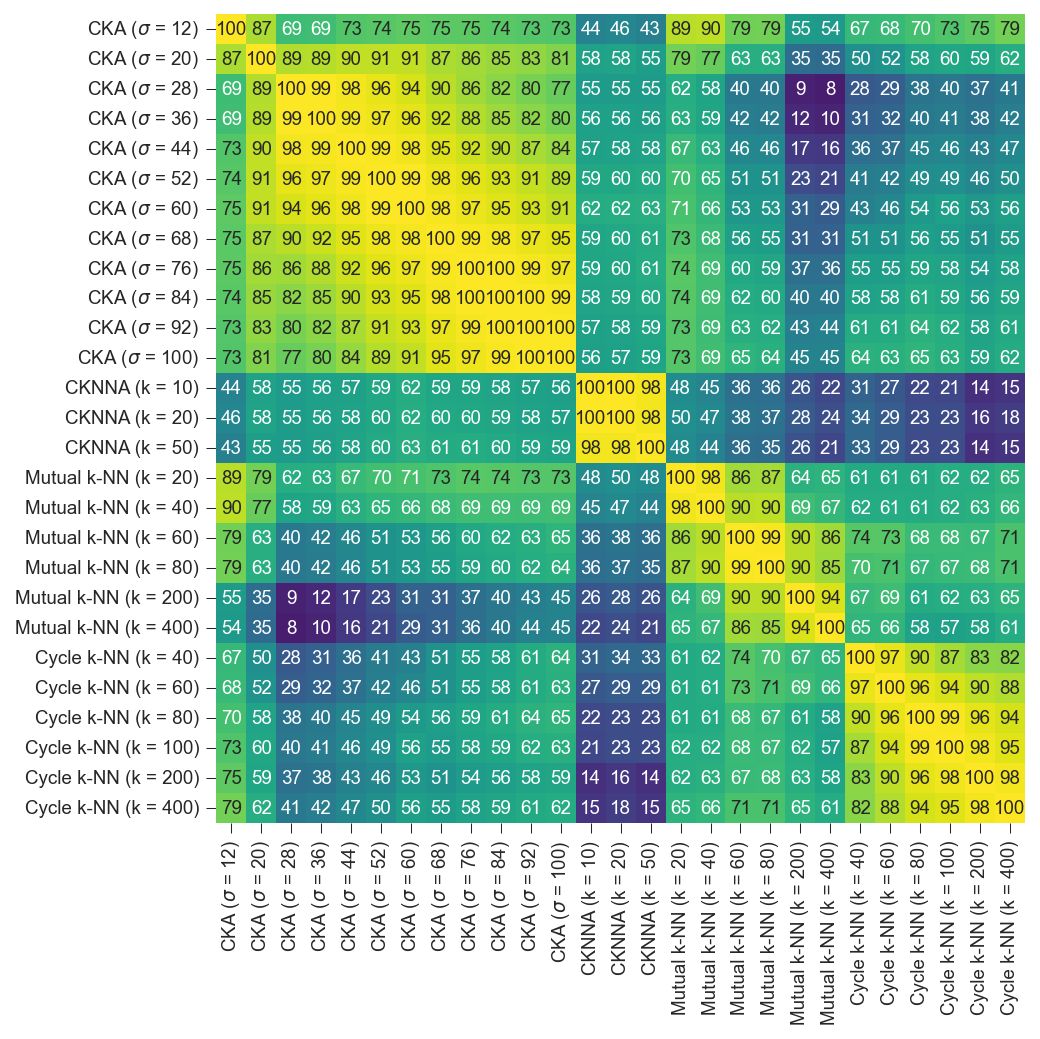

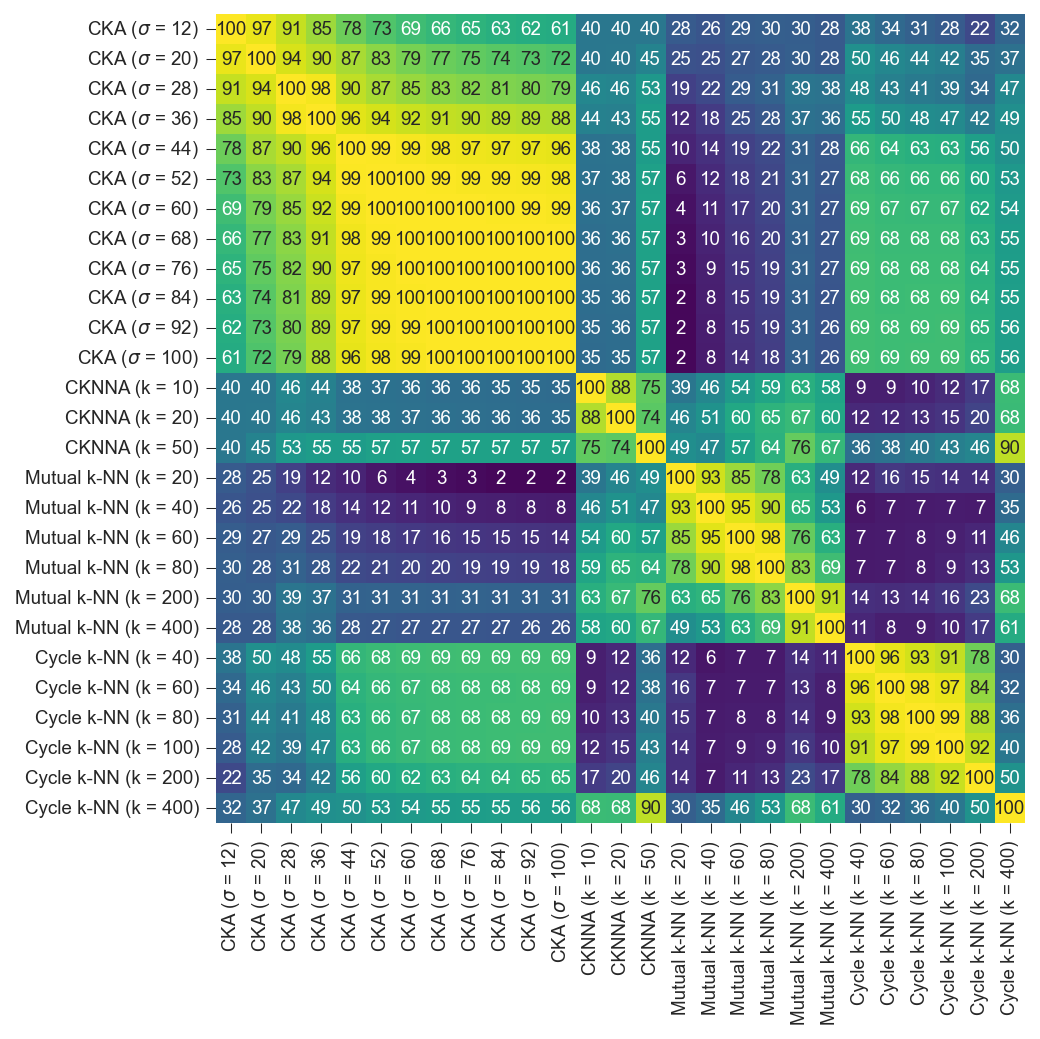

Kernel size consistency analysis completed and saved to CSV files and visualizations.


In [12]:
plt.rcParams['font.family'] = 'Arial' #
sns.reset_defaults()
sns.set_theme(context='paper', style='ticks', font='Arial')

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 300,
    'figure.dpi': 150,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})

plt.figure(figsize=(7, 7))
sns.heatmap(language_spearman, annot=True, cmap='viridis', vmin=0, vmax=100, fmt='.0f', cbar=False, square=True)
plt.savefig(f'{FIGURES_DIR}/statistic/metric/language_kernel_spearman_heatmap_wo_cbar.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 7))
sns.heatmap(vision_spearman, annot=True, cmap='viridis', vmin=0, vmax=100, fmt='.0f', cbar=False, square=True)
plt.savefig(f'{FIGURES_DIR}/statistic/metric/vision_kernel_spearman_heatmap_wo_cbar.pdf', bbox_inches='tight')
plt.show()

print("Kernel size consistency analysis completed and saved to CSV files and visualizations.")

## Consistency analysis of subjects

In [13]:
sigma = 36

print(f"Computing statistics for sigma {sigma}...")
sub_language_df = language_df[
    (language_df['metric'] == f'cka_{sigma}')
]

sub_leaderboard_df = sub_language_df.dropna(subset=['BBH'])
sub_arena_df = sub_language_df.dropna(subset=['elo'])

sub_vision_df = vision_df[
    (vision_df['metric'] == f'cka_{sigma}')
]

Computing statistics for sigma 36...


In [14]:
leaderboard_max_region_avg_subj_df = sub_leaderboard_df.groupby(
    [
        'relative_src_feature',
        'tgt_feature',
        'src_model',
        'tgt_model',
    ],
    as_index=False
)[[
    'score',
    'Average ⬆️',
    '#Params (B)',
    'elo',
    'IFEval',
    'BBH',
    'MATH Lvl 5',
    'GPQA',
    'MUSR',
    'MMLU-PRO'
]].mean()

leaderboard_max_region_avg_subj_df = (
    leaderboard_max_region_avg_subj_df.groupby(
        [
            'src_model',
            'tgt_model',
        ],
        as_index=False
    )[[
        'score',
        'Average ⬆️',
        '#Params (B)',
        'elo',
        'IFEval',
        'BBH',
        'MATH Lvl 5',
        'GPQA',
        'MUSR',
        'MMLU-PRO'
    ]]
    .apply(lambda x: x.nlargest(5, "score").mean())
    .reset_index(drop=True)
)


vision_max_region_avg_subj_df = sub_vision_df.groupby(
    [
        'relative_src_feature',
        'tgt_model',
        'tgt_feature',
        'src_model'
    ],
    as_index=False
)[[
    'score',
    '#Params (M)',
    'imagenet',
    'imagenet-a',
    'imagenet-a-clean',
    'imagenet-r',
    'imagenet-r-clean',
    'imagenet-real',
    'imagenetv2-matched-frequency',
    'sketch'
]].mean()

vision_max_region_avg_subj_df = (
    vision_max_region_avg_subj_df.groupby(
        [
            'src_model',
            'tgt_model',
        ],
        as_index=False
    )[[
        'score',
        '#Params (M)',
        'imagenet',
        'imagenet-a',
        'imagenet-a-clean',
        'imagenet-r',
        'imagenet-r-clean',
        'imagenet-real',
        'imagenetv2-matched-frequency',
        'sketch'
    ]].apply(lambda x: x.nlargest(5, "score").mean()).reset_index(drop=True)
)

vision_max_region_avg_subj_df['src_cls'] = vision_max_region_avg_subj_df['src_model'].apply(lambda row: row.split('_')[0].split('.')[0])

In [15]:
def extract_subject_dataframes(df, subject_list=['subj01', 'subj02', 'subj05', 'subj07']):

    subject_dfs = {}

    for subject in subject_list:
        subject_df = df[df['tgt_model'].str.contains(subject)]

        if len(subject_df) > 0:
            subject_df = subject_df.copy()
            subject_df['model_id'] = subject_df['src_model']
            subject_dfs[subject] = subject_df

    return subject_dfs

def analyze_subject_consistency(df_dict):

    subjects = list(df_dict.keys())
    n_subjects = len(subjects)

    pearson_corr = np.zeros((n_subjects, n_subjects))
    spearman_corr = np.zeros((n_subjects, n_subjects))
    pearson_p = np.zeros((n_subjects, n_subjects))
    spearman_p = np.zeros((n_subjects, n_subjects))
    n_models = np.zeros((n_subjects, n_subjects))

    for i, subj_i in enumerate(subjects):
        for j, subj_j in enumerate(subjects):
            if i == j:
                pearson_corr[i, j] = 1.0
                spearman_corr[i, j] = 1.0
                pearson_p[i, j] = 0.0
                spearman_p[i, j] = 0.0
                n_models[i, j] = len(df_dict[subj_i])
            else:
                df_i = df_dict[subj_i].copy()
                df_j = df_dict[subj_j].copy()

                df_i = df_i.rename(columns={'score': f'score_{subj_i}'})
                df_j = df_j.rename(columns={'score': f'score_{subj_j}'})

                merged_df = pd.merge(df_i[['model_id', f'score_{subj_i}']],
                                    df_j[['model_id', f'score_{subj_j}']],
                                    on='model_id', how='inner')

                if len(merged_df) >= 3:
                    p_corr, p_p = pearsonr(merged_df[f'score_{subj_i}'], merged_df[f'score_{subj_j}'])
                    s_corr, s_p = stats.spearmanr(merged_df[f'score_{subj_i}'], merged_df[f'score_{subj_j}'])

                    pearson_corr[i, j] = p_corr
                    spearman_corr[i, j] = s_corr
                    pearson_p[i, j] = p_p
                    spearman_p[i, j] = s_p
                    n_models[i, j] = len(merged_df)
                else:
                    pearson_corr[i, j] = np.nan
                    spearman_corr[i, j] = np.nan
                    pearson_p[i, j] = np.nan
                    spearman_p[i, j] = np.nan
                    n_models[i, j] = 0

    pearson_df = pd.DataFrame(pearson_corr, index=subjects, columns=subjects)
    spearman_df = pd.DataFrame(spearman_corr, index=subjects, columns=subjects)

    detailed_results = []
    p_values = []

    for i in range(n_subjects):
        for j in range(n_subjects):
            if i < j:
                result = {
                    'Subject 1': subjects[i],
                    'Subject 2': subjects[j],
                    'Models Compared': int(n_models[i, j]),
                    'Pearson r': pearson_corr[i, j],
                    'Pearson p-value': pearson_p[i, j],
                    'Spearman ρ': spearman_corr[i, j],
                    'Spearman p-value': spearman_p[i, j]
                }
                detailed_results.append(result)
                if not np.isnan(pearson_p[i, j]) and not np.isnan(spearman_p[i, j]):
                    p_values.extend([pearson_p[i, j], spearman_p[i, j]])

    if p_values:
        rejected, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')

        p_idx = 0
        for i, result in enumerate(detailed_results):
            if not np.isnan(result['Pearson p-value']) and not np.isnan(result['Spearman p-value']):
                result['Pearson p-value (FDR)'] = p_corrected[p_idx]
                p_idx += 1
                result['Spearman p-value (FDR)'] = p_corrected[p_idx]
                p_idx += 1
            else:
                result['Pearson p-value (FDR)'] = np.nan
                result['Spearman p-value (FDR)'] = np.nan

    detailed_df = pd.DataFrame(detailed_results)

    valid_pearson = [r['Pearson r'] for r in detailed_results if not np.isnan(r['Pearson r'])]
    valid_spearman = [r['Spearman ρ'] for r in detailed_results if not np.isnan(r['Spearman ρ'])]

    avg_metrics = {}
    if valid_pearson:
        avg_metrics['Average Pearson r'] = np.mean(valid_pearson)
        avg_metrics['Minimum Pearson r'] = np.min(valid_pearson)
        avg_metrics['Maximum Pearson r'] = np.max(valid_pearson)
        avg_metrics['Std Dev Pearson r'] = np.std(valid_pearson)
    else:
        avg_metrics['Average Pearson r'] = np.nan
        avg_metrics['Minimum Pearson r'] = np.nan
        avg_metrics['Maximum Pearson r'] = np.nan
        avg_metrics['Std Dev Pearson r'] = np.nan

    if valid_spearman:
        avg_metrics['Average Spearman ρ'] = np.mean(valid_spearman)
    else:
        avg_metrics['Average Spearman ρ'] = np.nan

    if not detailed_df.empty:
        for col in ['Pearson r', 'Spearman ρ']:
            if col in detailed_df.columns:
                detailed_df[col] = detailed_df[col].apply(lambda x: f"{x:.3f}" if not pd.isna(x) else "NA")

        def format_p(p):
            if pd.isna(p):
                return "NA"
            elif p < 0.001:
                return f"<{p:.1e}"
            else:
                return f"{p:.3f}"

        for col in ['Pearson p-value', 'Spearman p-value', 'Pearson p-value (FDR)', 'Spearman p-value (FDR)']:
            if col in detailed_df.columns:
                detailed_df[col] = detailed_df[col].apply(format_p)

    return pearson_df, detailed_df, avg_metrics

def plot_correlation_heatmap(correlation_matrix, title):

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                vmin=-1, vmax=1, square=True, linewidths=.5)
    plt.title(title)
    plt.tight_layout()
    return plt.gcf()

def create_subject_consistency_table(df, modality, subject_list=['subj01', 'subj02', 'subj05', 'subj07']):

    subject_dfs = extract_subject_dataframes(df, subject_list)

    available_subjects = list(subject_dfs.keys())
    if not available_subjects:
        print(f"Missing subject: {modality}")
        return None, None
    elif len(available_subjects) < len(subject_list):
        missing = set(subject_list) - set(available_subjects)
        print(f"Missing subject {modality}-{missing}")

    corr_matrix, detailed_df, avg_metrics = analyze_subject_consistency(subject_dfs)

    summary_stats = pd.DataFrame({
        'Metric': [
            'Modality',
            'Subjects Analyzed',
            'Average Inter-subject Pearson r',
            'Average Inter-subject Spearman ρ',
            'Min Pearson r',
            'Max Pearson r',
            'Std Dev of Pearson r'
        ],
        'Value': [
            modality,
            ', '.join(available_subjects),
            f"{avg_metrics['Average Pearson r']:.3f}" if not np.isnan(avg_metrics['Average Pearson r']) else "NA",
            f"{avg_metrics['Average Spearman ρ']:.3f}" if not np.isnan(avg_metrics['Average Spearman ρ']) else "NA",
            f"{avg_metrics['Minimum Pearson r']:.3f}" if not np.isnan(avg_metrics['Minimum Pearson r']) else "NA",
            f"{avg_metrics['Maximum Pearson r']:.3f}" if not np.isnan(avg_metrics['Maximum Pearson r']) else "NA",
            f"{avg_metrics['Std Dev Pearson r']:.3f}" if not np.isnan(avg_metrics['Std Dev Pearson r']) else "NA"
        ]
    })

    return detailed_df, summary_stats, corr_matrix

def analyze_all_modalities(language_df, vision_df, subject_list=['subj01', 'subj02', 'subj05', 'subj07']):

    lang_detailed, lang_summary, lang_corr = create_subject_consistency_table(
        language_df, "Language Models", subject_list
    )
    vision_detailed, vision_summary, vision_corr = create_subject_consistency_table(
        vision_df, "Vision Models", subject_list
    )

    # 合并汇总统计
    combined_summary = None
    if lang_summary is not None and vision_summary is not None:
        combined_summary = pd.concat([lang_summary, vision_summary])
    elif lang_summary is not None:
        combined_summary = lang_summary
    elif vision_summary is not None:
        combined_summary = vision_summary

    return combined_summary, lang_detailed, vision_detailed, lang_corr, vision_corr



In [16]:

combined_summary, lang_detailed, vision_detailed, lang_corr, vision_corr = analyze_all_modalities(
    leaderboard_max_region_avg_subj_df,
    vision_max_region_avg_subj_df,
    subject_list=['S01', 'S02', 'S05', 'S07']
)


combined_summary.to_csv(f"{FIGURES_DIR}/statistic/combined_summary.csv")
lang_detailed.to_csv(f"{FIGURES_DIR}/statistic/lang_detailed.csv")
vision_detailed.to_csv(f"{FIGURES_DIR}/statistic/vision_detailed.csv")
lang_corr.to_csv(f"{FIGURES_DIR}/statistic/lang_corr.csv")
vision_corr.to_csv(f"{FIGURES_DIR}/statistic/vision_corr.csv")

print(combined_summary, lang_detailed, vision_detailed, lang_corr, vision_corr)

                             Metric               Value
0                          Modality     Language Models
1                 Subjects Analyzed  S01, S02, S05, S07
2   Average Inter-subject Pearson r               0.999
3  Average Inter-subject Spearman ρ               0.995
4                     Min Pearson r               0.997
5                     Max Pearson r               1.000
6              Std Dev of Pearson r               0.001
0                          Modality       Vision Models
1                 Subjects Analyzed  S01, S02, S05, S07
2   Average Inter-subject Pearson r               0.986
3  Average Inter-subject Spearman ρ               0.988
4                     Min Pearson r               0.970
5                     Max Pearson r               0.999
6              Std Dev of Pearson r               0.013   Subject 1 Subject 2  Models Compared Pearson r Pearson p-value Spearman ρ  \
0       S01       S02               36     0.998        <4.8e-42      0.990   
1 

In [17]:
lang_corr

S01       S02       S05       S07
S01  1.000000  0.997911  0.999047  0.997116
S02  0.997911  1.000000  0.999573  0.999753
S05  0.999047  0.999573  1.000000  0.999155
S07  0.997116  0.999753  0.999155  1.000000

## Layer-wise Analysis (CKA-36)

In [18]:
sigma = 36
sub_language_df = language_df[language_df['metric'] == f'cka_{sigma}']
sub_vision_df = vision_df[vision_df['metric'] == f'cka_{sigma}']


### Ranking

/tmp/ipykernel_213228/2033015907.py:97: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.

/tmp/ipykernel_213228/2033015907.py:97: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.

/tmp/ipykernel_213228/2033015907.py:97: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.

/tmp/ipykernel_213228/2033015907.py:97: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



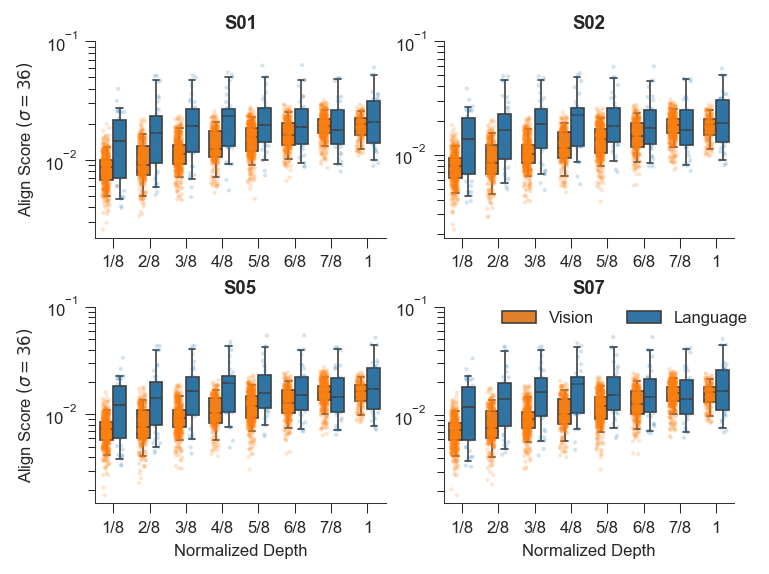

/tmp/ipykernel_213228/2033015907.py:187: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



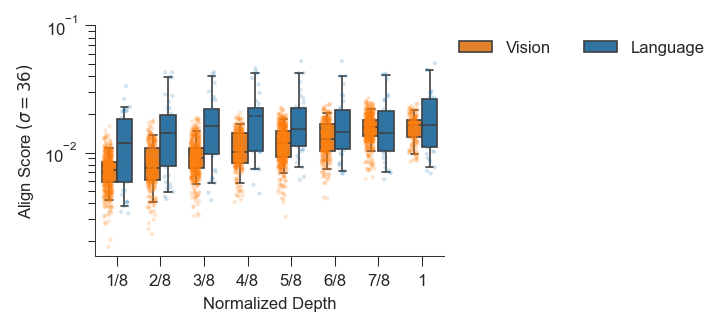

In [19]:
plt.rcParams['font.family'] = 'Arial' #
sns.reset_defaults()
sns.set_theme(context='paper', style='ticks', font='Arial')

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 9,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'axes.linewidth': 0.5,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.0,
    'legend.frameon': False,
    'savefig.dpi': 300,
    'figure.dpi': 150,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5
})

subj_dict = {
    f"S{x}": f'subject 0{x}' for x in [1, 2, 5, 7]
}

all_subjects = sorted(sub_language_df['tgt_model'].unique())
palette = {"Language": "#1f77b4", "Vision": "#ff7f0e"}
fig = plt.figure(figsize=(5.5, 4))
spec = GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[1, 1], height_ratios=[1, 1], hspace=0.35, wspace=0.2)

for i, subj in enumerate(all_subjects):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(spec[row, col])

    vision_per_subj_df = sub_vision_df[(sub_vision_df['tgt_model'] == subj)]
    vision_per_subj_df = vision_per_subj_df.groupby(['relative_src_feature', 'tgt_model', 'src_model'],  # , 'src_feature'
                                               as_index=False)[['score']].mean()

    language_per_subj_df = sub_language_df[(sub_language_df['tgt_model'] == subj)]
    language_per_subj_df = language_per_subj_df.groupby(['relative_src_feature', 'tgt_model', 'src_model'],  # , 'src_feature'
                                                  as_index=False)[['score']].mean()

    vision_per_subj_df['Modality'] = 'Vision'
    language_per_subj_df['Modality'] = 'Language'
    subj_df = pd.concat([vision_per_subj_df, language_per_subj_df], ignore_index=True)

    sns.stripplot(
        data=subj_df,
        y='score',
        x='relative_src_feature',
        hue='Modality',
        dodge=True,
        size=2,
        alpha=0.2,
        palette=palette,
        log_scale=(False, True),
        ax=ax,
        jitter=0.2,
        legend=False  # Disable stripplot legend
    )

    # Then create boxplot on top with semi-transparency
    boxplot = sns.boxplot(
        data=subj_df,
        y='score',
        x='relative_src_feature',
        hue='Modality',
        orient='v',
        palette=palette,
        width=0.7,  # Slightly narrower boxes
        linewidth=0.8,
        showfliers=False,  # Hide outliers for cleaner look
        log_scale=(False, True),

        whis=[5, 95],  # Set whiskers at 5% and 95% percentiles
        ax=ax,
        # alpha=0.7  # Add semi-transparency to the boxplot
    )

    # Keep only the boxplot legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], frameon=False, loc='upper right')

    # Set axis labels with consistent styling
    ax.set_ylabel(f"Align Score $(\sigma={sigma})$" if (i == 0 or i == 2) else "")
    ax.set_xlabel("Normalized Depth" if (i == 2 or i == 3) else "")
    ax.set_title(subj, fontsize=9, fontweight='bold')

    # Set x and y ticks
    ax.set_xticks(list(range(8)))
    ax.set_xticklabels([f"{i}/8" for i in range(1, 8)] + ['1'])

    ax.set_ylim(0., 0.10)

    if i != 3:
        ax.get_legend().remove()
    else:
        ax.legend(
            frameon=False,
            bbox_to_anchor=(0.15, 0.825),
            ncol=2,
        )

    sns.despine()
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_color('#333333')
    ax.spines['bottom'].set_color('#333333')

os.makedirs(f"{FIGURES_DIR}/layer_wise", exist_ok=True)
plt.savefig(f"{FIGURES_DIR}/layer_wise/vision_language_comparison_per_subject.pdf", bbox_inches='tight', dpi=300)
plt.show()

# --------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

# Process the data
vision_per_subj_df = sub_vision_df[(sub_vision_df['tgt_model'] == subj)]
vision_per_subj_df = vision_per_subj_df.groupby(['relative_src_feature', 'tgt_model', 'src_model'],  #, 'src_feature'
                                           as_index=False)[['score']].mean()

language_per_subj_df = sub_language_df[(sub_language_df['tgt_model'] == subj)]
language_per_subj_df = language_per_subj_df.groupby(['relative_src_feature', 'tgt_model', 'src_model'],  #, 'src_feature'
                                              as_index=False)[['score']].mean()

# Add modality column and merge data
vision_per_subj_df['Modality'] = 'Vision'
language_per_subj_df['Modality'] = 'Language'
subj_df = pd.concat([vision_per_subj_df, language_per_subj_df], ignore_index=True)

# First add strip plot for data points (will be underneath)
sns.stripplot(
    data=subj_df,
    y='score',
    x='relative_src_feature',
    hue='Modality',
    dodge=True,
    size=2,
    alpha=0.2,
    palette=palette,
    log_scale=(False, True),
    ax=ax,
    jitter=0.2,
    legend=False  # Disable stripplot legend
)

# Then create boxplot on top with semi-transparency
boxplot = sns.boxplot(
    data=subj_df,
    y='score',
    x='relative_src_feature',
    hue='Modality',
    orient='v',
    palette=palette,
    width=0.7,
    linewidth=0.8,
    showfliers=False,
    log_scale=(False, True),
    # alpha=0.7,  # Semi-transparent boxplot
    whis=[5, 95],
    ax=ax
)

# Keep only boxplot legend
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.0, 1.0),
    ncol=2,
)

# Set axis labels with consistent styling
ax.set_ylabel(f"Align Score $(\sigma={sigma})$")
ax.set_xlabel("Normalized Depth")

# Set x and y ticks
ax.set_xticks(list(range(8)))
ax.set_xticklabels([f"{i}/8" for i in range(1, 8)] + ['1'])

# yticks = np.linspace(0, 0.03, 4)
# ax.set_yticks(yticks)
# ax.set_yticklabels([f"{tick:.2f}" for tick in yticks])
ax.set_ylim(0., 0.10)  # Add slight padding at top

# Add subtle grid lines
# ax.grid(axis='y', linestyle='-', linewidth=0.3, color='#dddddd', alpha=0.7)

# Use Nature-style spines (only bottom and left)
sns.despine()
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_color('#333333')
ax.spines['bottom'].set_color('#333333')

# Adjust layout and save
# plt.tight_layout()
os.makedirs(f"{FIGURES_DIR}/layer_wise", exist_ok=True)
plt.savefig(f"{FIGURES_DIR}/layer_wise/vision_language_comparison_all_subject.pdf", bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_213228/3629275098.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_213228/3629275098.py:40: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_213228/3629275098.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation.

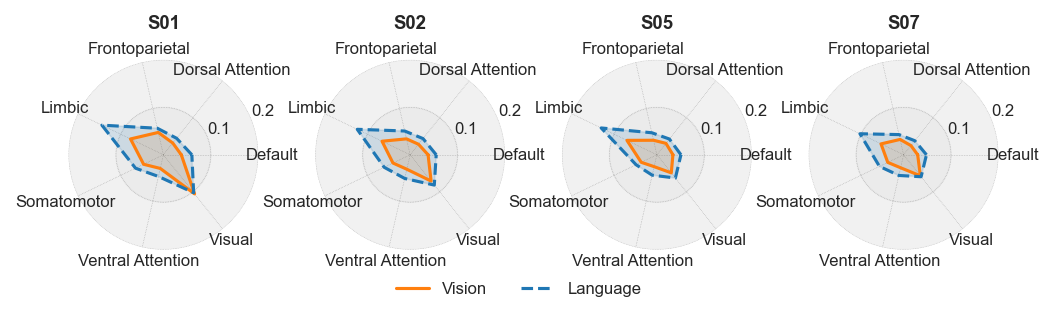

/tmp/ipykernel_213228/3629275098.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_213228/3629275098.py:40: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_213228/3629275098.py:26: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation.

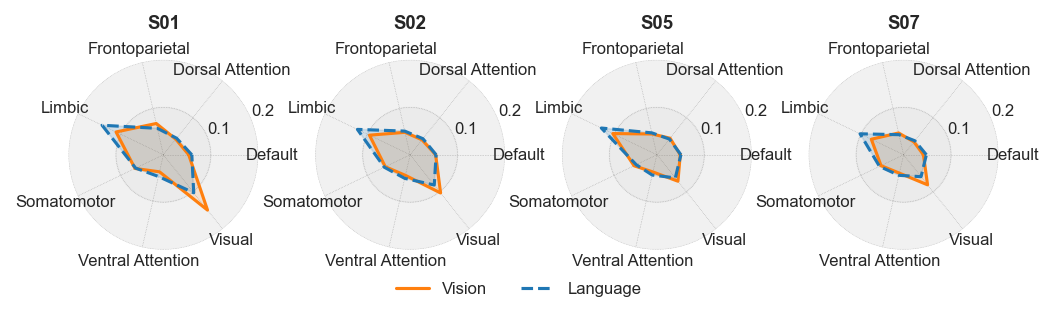

In [20]:

all_subjects = sorted(sub_language_df['tgt_model'].unique())
yeo7_labels = sorted(sub_language_df['yeo7'].unique())


colors = {"Language": "#1f77b4", "Vision": "#ff7f0e"}

for layer in [2, 6]: #range(8)

    fig = plt.figure(figsize=(8, 1.75))
    spec = GridSpec(ncols=len(all_subjects), nrows=1, figure=fig, wspace=0.3, hspace=0.1)

    # Process each subject
    for subj_idx, subj in enumerate(all_subjects):
        ax = fig.add_subplot(spec[subj_idx], polar=True)

        # Process vision data
        vision_per_subj_df = sub_vision_df[
            (sub_vision_df['tgt_model'] == subj)
            & (sub_vision_df['relative_src_feature'] == layer)
        ]
        # vision_per_subj_df = vision_per_subj_df.groupby(['yeo7', 'tgt_feature'], as_index=False)['score'].max()
        vision_per_subj_df = vision_per_subj_df.groupby(['yeo7'], as_index=False)['score'].max()

        top_5_percent_avg = (
            vision_per_subj_df.groupby('yeo7')
            .apply(lambda x: x.nlargest(max(1, int(len(x) * 0.05)), 'score')['score'].mean())
            .reset_index(name='score')
        )
        vision_per_subj_df = vision_per_subj_df[['yeo7']].drop_duplicates().merge(top_5_percent_avg, on='yeo7', how='left')


        # Process language data
        language_per_subj_df = sub_language_df[
            (sub_language_df['tgt_model'] == subj)
            & (sub_language_df['relative_src_feature'] == layer)
        ]

        top_5_percent_avg = (
            language_per_subj_df.groupby('yeo7')
            .apply(lambda x: x.nlargest(max(1, int(len(x) * 0.10)), 'score')['score'].mean())
            .reset_index(name='score')
        )
        language_per_subj_df = language_per_subj_df[['yeo7']].drop_duplicates().merge(top_5_percent_avg, on='yeo7', how='left')


        # Calculate mean scores for each yeo7 region
        vision_scores = vision_per_subj_df.set_index('yeo7')['score'].reindex(yeo7_labels, fill_value=0)
        language_scores = language_per_subj_df.set_index('yeo7')['score'].reindex(yeo7_labels, fill_value=0)

        # Prepare angles for radar chart
        angles = np.linspace(0, 2 * np.pi, len(yeo7_labels), endpoint=False).tolist()
        angles += angles[:1]  # Close the radar plot

        # Plot vision data with improved styling
        vision_values = vision_scores.values.tolist() + [vision_scores.values[0]]
        ax.plot(angles, vision_values, color=colors['Vision'], linewidth=1.5, linestyle='-', zorder=3)
        ax.fill(angles, vision_values, color=colors['Vision'], alpha=0.15, zorder=1)

        # Plot language data with improved styling
        language_values = language_scores.values.tolist() + [language_scores.values[0]]
        ax.plot(angles, language_values, color=colors['Language'], linewidth=1.5, linestyle='--', zorder=3)
        ax.fill(angles, language_values, color=colors['Language'], alpha=0.15, zorder=2)

        # Improve angle labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(yeo7_labels)
        ax.tick_params(pad=-5)
        # Set consistent y-axis limits and ticks
        # yticks = np.linspace(0, .5, 6)
        yticks = [0.0, 0.1, 0.2, 0.3]
        ax.set_yticks(yticks)
        ax.set_yticklabels([""] + [f"{tick:.1f}" for tick in yticks[1:]])
        ax.set_ylim(0, .2)
        # ax.semilogy()

        # Add more refined gridlines
        ax.grid(color='gray', linestyle=':', linewidth=0.3, alpha=0.7, zorder=0)

        # Add title with careful positioning
        ax.set_title(subj,  fontweight='bold') # pad=10,

        # Clean up spines
        ax.spines['polar'].set_visible(False)

        # Add subtle background circular grid highlight
        for ytick in yticks[1:]:
            ax.fill(np.linspace(0, 2*np.pi, 100),
                   np.ones(100) * ytick,
                   color='gray', alpha=0.05, zorder=0)

    # Add legend outside the subplots
    legend_elements = [
        plt.Line2D([0], [0], color=colors['Vision'], lw=1.5, label='Vision'),
        plt.Line2D([0], [0], color=colors['Language'], lw=1.5, label='Language', linestyle='--')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.07),
              ncol=2, frameon=False)

    os.makedirs(f"{FIGURES_DIR}/layer_wise/yeo7", exist_ok=True)
    plt.savefig(f"{FIGURES_DIR}/layer_wise/yeo7/{layer}.pdf", bbox_inches='tight', dpi=300)
    plt.show()

## Kernel Size

In [21]:
relative_src_feature = 6

sub_language_df = language_df[(language_df['relative_src_feature'] == relative_src_feature) & (language_df['metric'] != 'cka_12')]
sub_vision_df = vision_df[(vision_df['relative_src_feature'] == relative_src_feature) & (vision_df['metric'] != 'cka_12')]

language-28-68
Qwen_Qwen1.5-0.5B-Chat

=== Subject Consistency Analysis ===
Total subjects: 4
Average sign consistency across regions (raw): 1.0000
Average sign consistency across regions (normalized): 0.8208

Most consistent brain regions (by normalized sign consistency):
  1 (Somatomotor) - Sign Consistency: 1.0000, CV: 0.2284
  PreS (Visual) - Sign Consistency: 1.0000, CV: 0.6012
  PoI1 (Ventral Attention) - Sign Consistency: 1.0000, CV: 0.3403
  Pir (Limbic) - Sign Consistency: 1.0000, CV: 0.5935
  PeEc (Limbic) - Sign Consistency: 1.0000, CV: 0.2984

Least consistent brain regions (by normalized sign consistency):
  MST (Visual) - Sign Consistency: 0.2500, CV: 2.1331
  6v (Somatomotor) - Sign Consistency: 0.2500, CV: 9.9533
  a9-46v (Frontoparietal) - Sign Consistency: 0.2500, CV: 2.4499
  TPOJ3 (Dorsal Attention) - Sign Consistency: 0.2500, CV: 3.6585
  p32pr (Ventral Attention) - Sign Consistency: 0.2500, CV: 4.3837


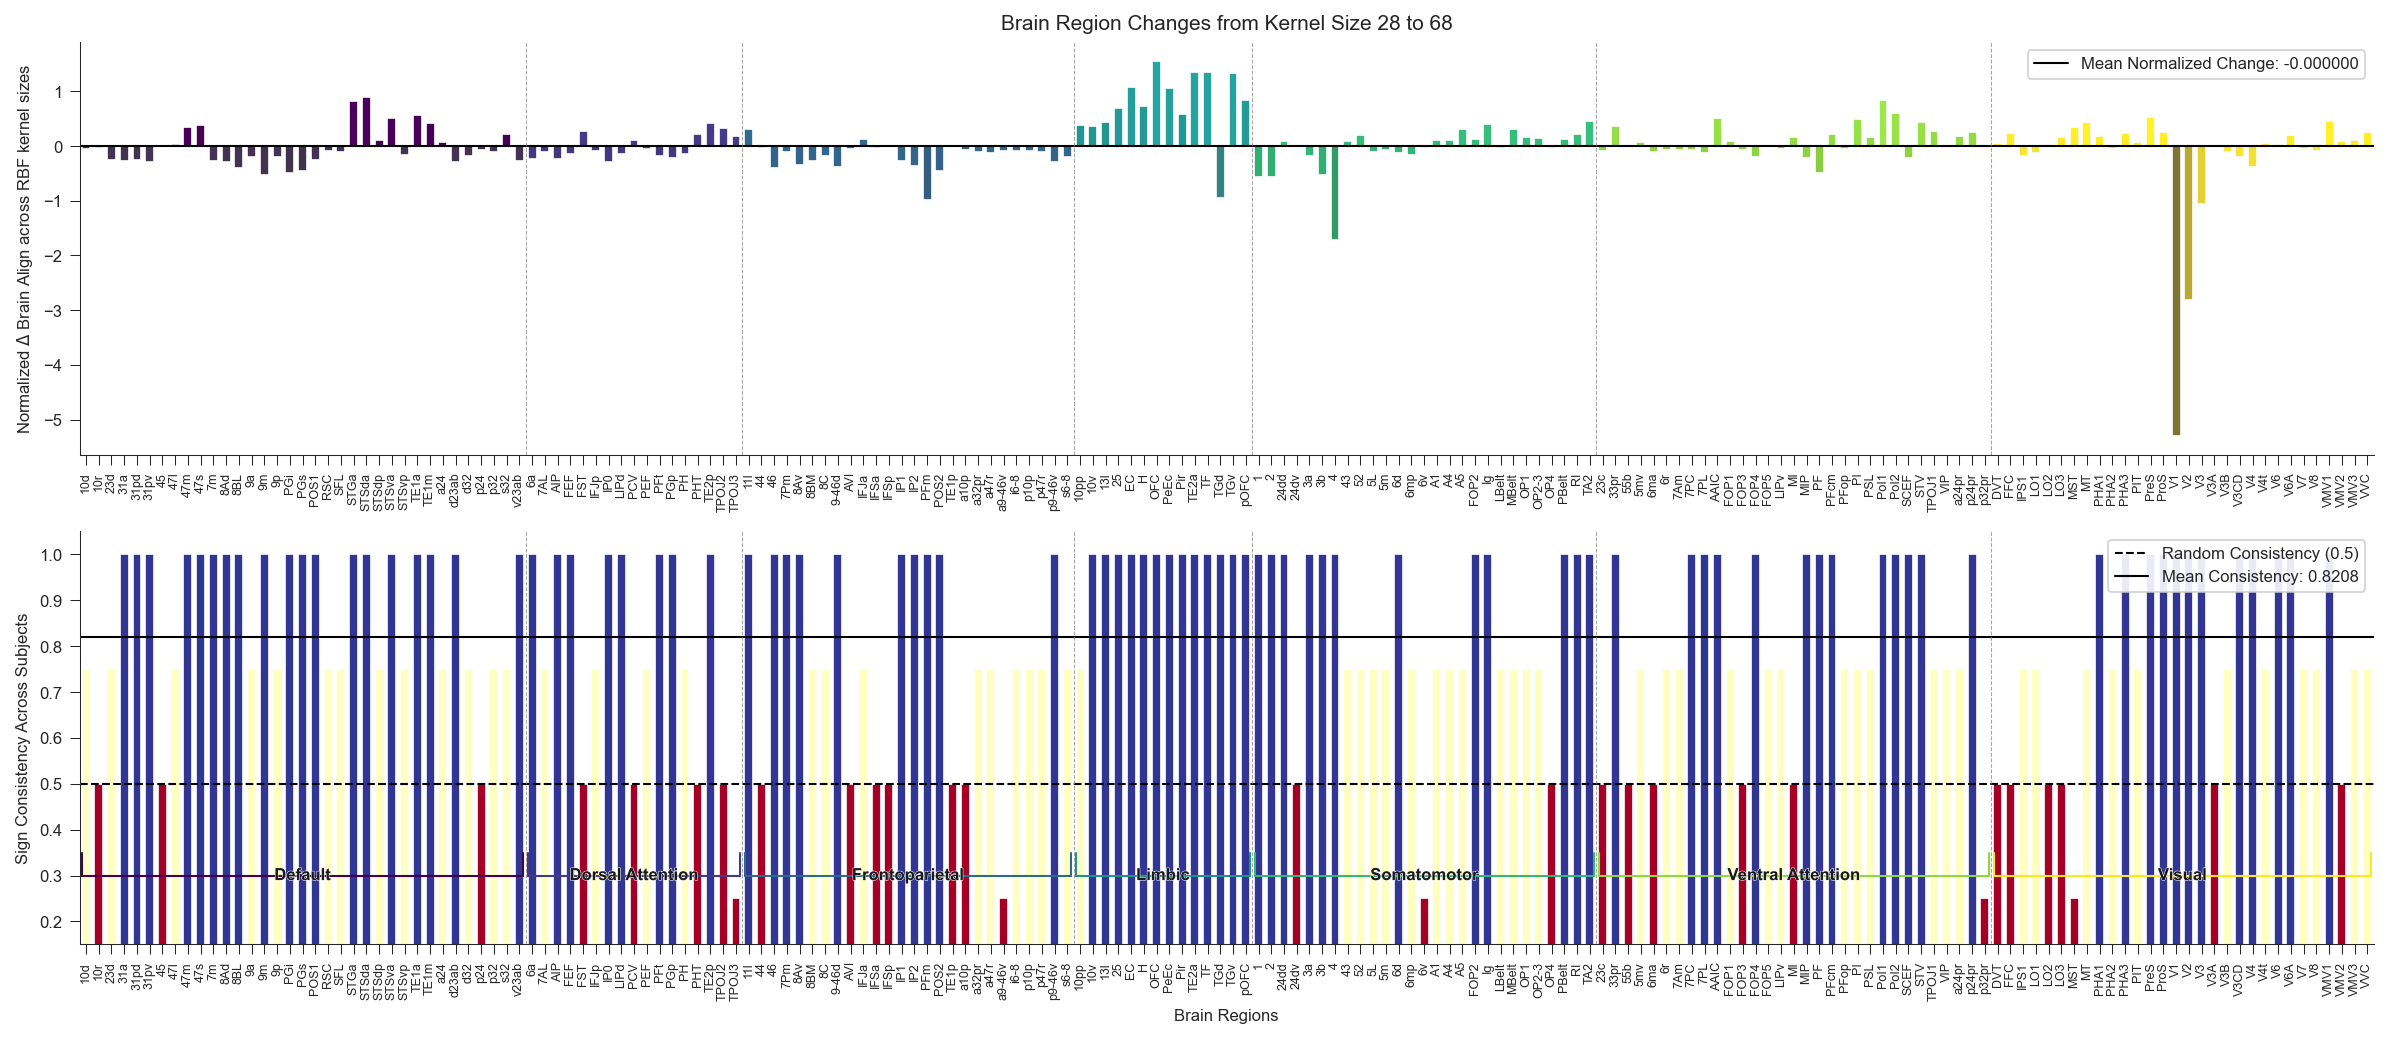

vision-28-68
beit_base_patch16_224.in22k_ft_in22k_in1k

=== Subject Consistency Analysis ===
Total subjects: 4
Average sign consistency across regions (raw): 1.0000
Average sign consistency across regions (normalized): 0.8181

Most consistent brain regions (by normalized sign consistency):
  1 (Somatomotor) - Sign Consistency: 1.0000, CV: 0.2030
  RI (Somatomotor) - Sign Consistency: 1.0000, CV: 0.5401
  PreS (Visual) - Sign Consistency: 1.0000, CV: 0.4925
  PoI2 (Ventral Attention) - Sign Consistency: 1.0000, CV: 0.4021
  PoI1 (Ventral Attention) - Sign Consistency: 1.0000, CV: 0.3428

Least consistent brain regions (by normalized sign consistency):
  MST (Visual) - Sign Consistency: 0.2500, CV: 3.0243
  TPOJ3 (Dorsal Attention) - Sign Consistency: 0.2500, CV: 65.8330
  TPOJ2 (Dorsal Attention) - Sign Consistency: 0.2500, CV: 3.4127
  VIP (Ventral Attention) - Sign Consistency: 0.2500, CV: 8.4548
  6v (Somatomotor) - Sign Consistency: 0.2500, CV: 61.7877


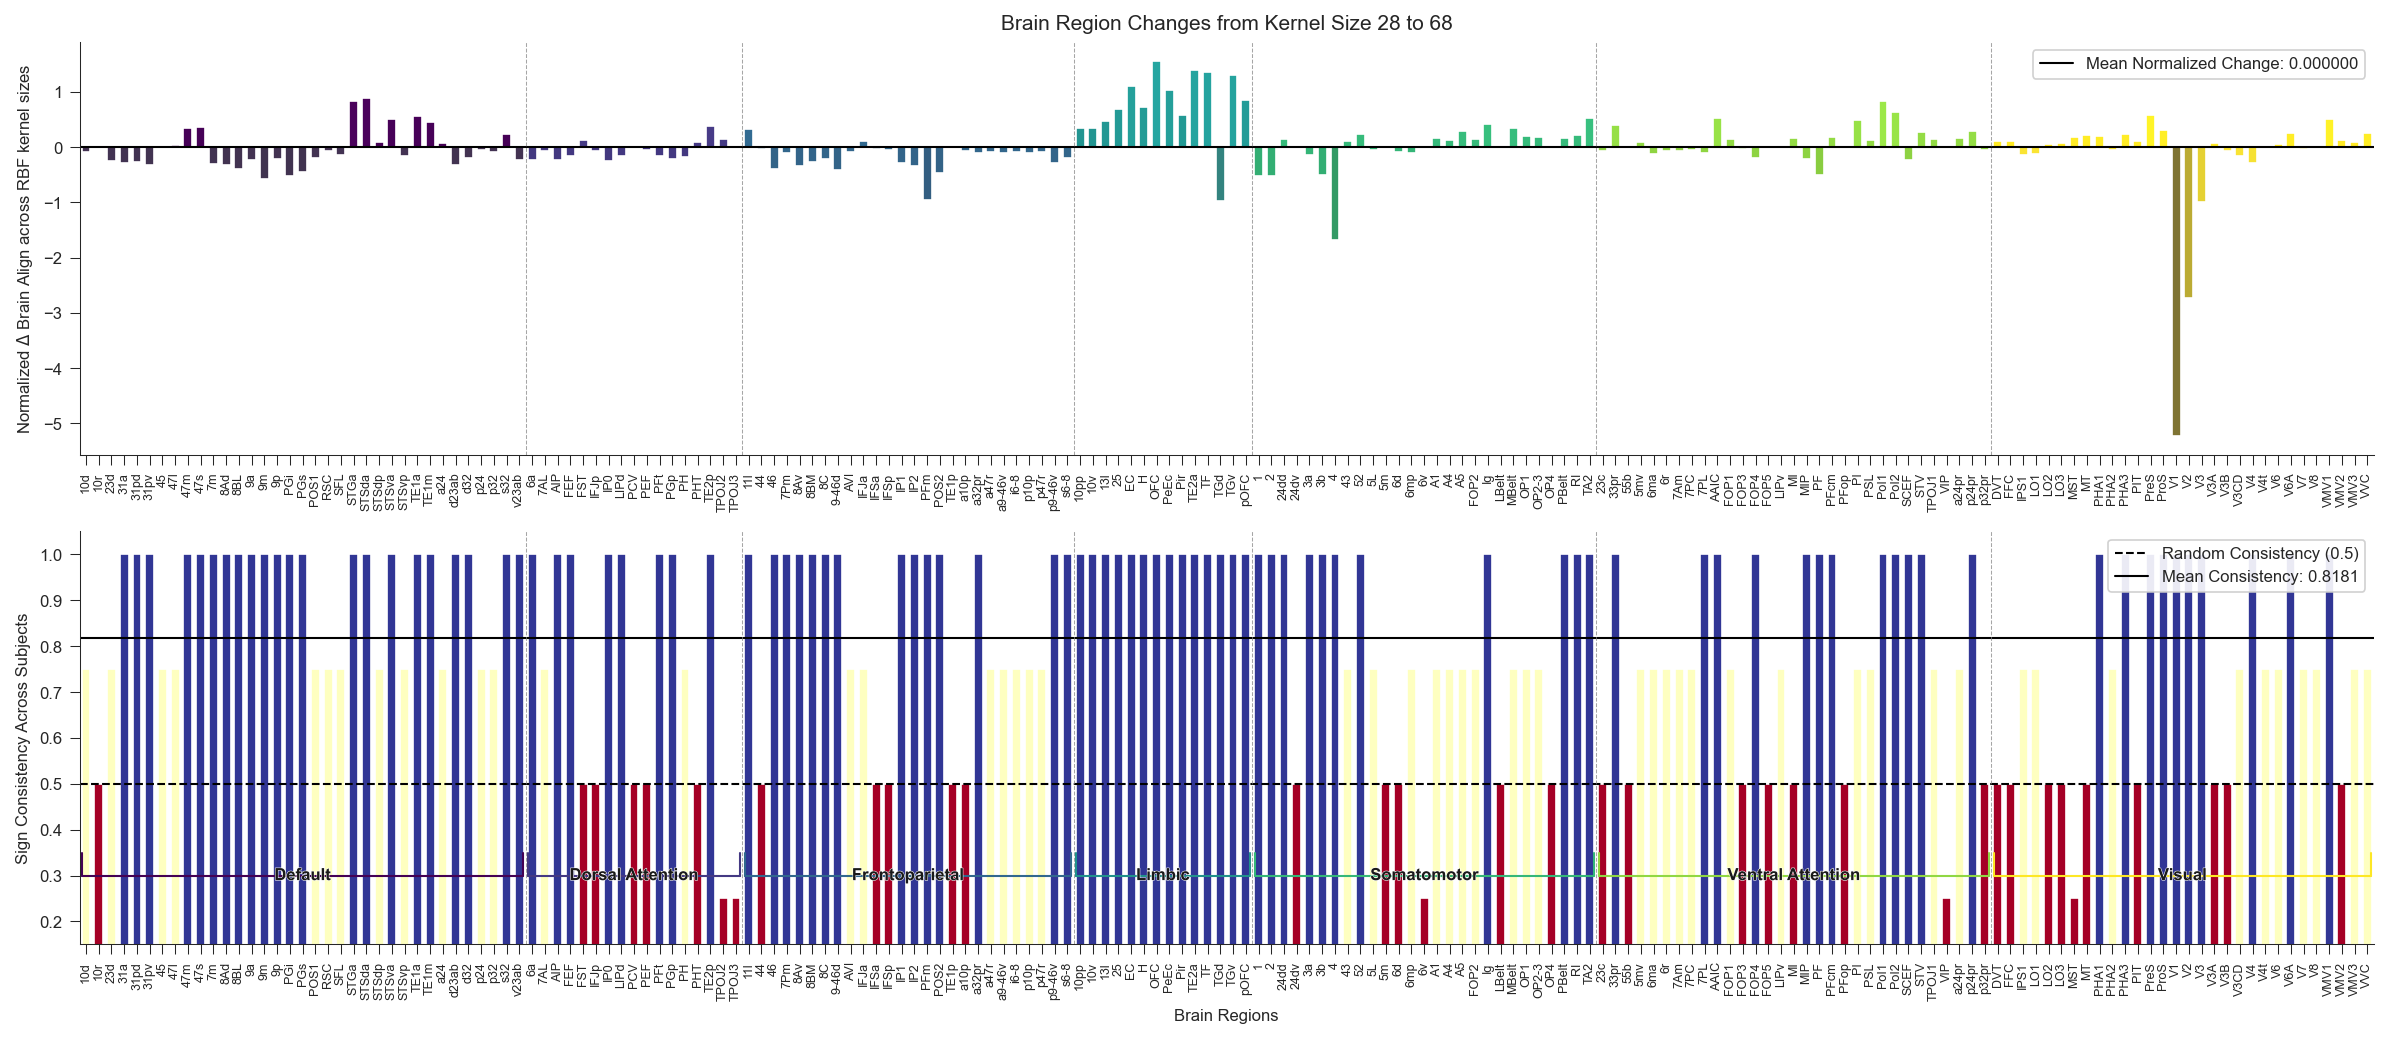

In [22]:
# 定义变量

# for head in [20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100]:
#     for tail in [20, 28, 36, 44, 52, 60, 68, 76, 84, 92, 100]:
for head in [28]:
    for tail in [68]:
        for modality, sub_df in zip(['language', 'vision'], [sub_language_df, sub_vision_df]):
            if head >= tail:
                continue

            print(f"{modality}-{head}-{tail}")
            print(sub_df['src_model'].unique()[0])

            ks_begin = f'cka_{head}'
            ks_end = f'cka_{tail}'

            all_subjects = sorted(sub_df['tgt_model'].unique())
            all_score_changes = []

            region_subject_changes = {}

            for subj in all_subjects:
                subj_df = sub_df[
                    (sub_df['tgt_model'] == subj)
                    & (
                        (sub_df['metric'] == ks_begin)
                        | (sub_df['metric'] == ks_end)
                    )
                ]

                avg_df = subj_df.groupby(['metric', 'tgt_feature', 'yeo7'], as_index=False)[['score']].mean()

                for metric in [ks_begin, ks_end]:
                    metric_scores = avg_df[avg_df['metric'] == metric]['score']
                    mean_score = metric_scores.mean()
                    std_score = metric_scores.std()
                    avg_df.loc[avg_df['metric'] == metric, 'normalized_score'] = (avg_df.loc[avg_df['metric'] == metric, 'score'] - mean_score) / std_score

                pivot_df = avg_df.pivot(index=['tgt_feature', 'yeo7'], columns='metric', values=['score', 'normalized_score'])

                pivot_df = pivot_df.reset_index()

                new_columns = []
                for col in pivot_df.columns:
                    if isinstance(col, tuple) and len(col) == 2:
                        if col[1].startswith('cka_'):
                            new_columns.append(f"{col[1]}_{col[0]}")
                        else:
                            new_columns.append(col[0])
                    else:
                        new_columns.append(col)

                pivot_df.columns = new_columns

                pivot_df['subject'] = subj
                pivot_df['score_change'] = pivot_df[f'{ks_end}_score'] - pivot_df[f'{ks_begin}_score']
                pivot_df['normalized_score_change'] = pivot_df[f'{ks_end}_normalized_score'] - pivot_df[f'{ks_begin}_normalized_score']

                all_score_changes.append(pivot_df)

                for _, row in pivot_df.iterrows():
                    region_key = (row['tgt_feature'], row['yeo7'])
                    if region_key not in region_subject_changes:
                        region_subject_changes[region_key] = {
                            'raw_changes': [],
                            'norm_changes': []
                        }

                    region_subject_changes[region_key]['raw_changes'].append(row['score_change'])
                    region_subject_changes[region_key]['norm_changes'].append(row['normalized_score_change'])

            combined_changes = pd.concat(all_score_changes)

            avg_score_change = combined_changes.groupby(['tgt_feature', 'yeo7'])[['score_change', 'normalized_score_change']].mean().reset_index()

            consistency_stats = []
            for region_key, changes in region_subject_changes.items():
                tgt_feature, yeo7 = region_key

                raw_std = np.std(changes['raw_changes'])
                norm_std = np.std(changes['norm_changes'])

                raw_mean = np.mean(changes['raw_changes'])
                norm_mean = np.mean(changes['norm_changes'])

                raw_cv = raw_std / abs(raw_mean) if abs(raw_mean) > 1e-6 else float('inf')
                norm_cv = norm_std / abs(norm_mean) if abs(norm_mean) > 1e-6 else float('inf')

                raw_sign = np.sign(changes['raw_changes'])
                norm_sign = np.sign(changes['norm_changes'])

                raw_sign_consistency = np.mean(raw_sign == np.sign(raw_mean)) if raw_mean != 0 else 0.5
                norm_sign_consistency = np.mean(norm_sign == np.sign(norm_mean)) if norm_mean != 0 else 0.5

                consistency_stats.append({
                    'tgt_feature': tgt_feature,
                    'yeo7': yeo7,
                    'raw_mean': raw_mean,
                    'norm_mean': norm_mean,
                    'raw_std': raw_std,
                    'norm_std': norm_std,
                    'raw_cv': raw_cv,
                    'norm_cv': norm_cv,
                    'raw_sign_consistency': raw_sign_consistency,
                    'norm_sign_consistency': norm_sign_consistency,
                    'num_subjects': len(changes['raw_changes'])
                })

            consistency_df = pd.DataFrame(consistency_stats)

            print("\n=== Subject Consistency Analysis ===")
            print(f"Total subjects: {len(all_subjects)}")
            print(f"Average sign consistency across regions (raw): {consistency_df['raw_sign_consistency'].mean():.4f}")
            print(f"Average sign consistency across regions (normalized): {consistency_df['norm_sign_consistency'].mean():.4f}")

            print("\nMost consistent brain regions (by normalized sign consistency):")
            most_consistent = consistency_df.sort_values('norm_sign_consistency', ascending=False).head(5)
            for _, row in most_consistent.iterrows():
                print(f"  {row['tgt_feature']} ({row['yeo7']}) - Sign Consistency: {row['norm_sign_consistency']:.4f}, CV: {row['norm_cv']:.4f}")

            print("\nLeast consistent brain regions (by normalized sign consistency):")
            least_consistent = consistency_df.sort_values('norm_sign_consistency').head(5)
            for _, row in least_consistent.iterrows():
                print(f"  {row['tgt_feature']} ({row['yeo7']}) - Sign Consistency: {row['norm_sign_consistency']:.4f}, CV: {row['norm_cv']:.4f}")

            avg_score_change = avg_score_change.merge(
                consistency_df[['tgt_feature', 'yeo7', 'raw_std', 'norm_std', 'raw_cv', 'norm_cv', 'raw_sign_consistency', 'norm_sign_consistency']],
                on=['tgt_feature', 'yeo7']
            )

            mean_norm_change = avg_score_change['normalized_score_change'].mean()

            avg_score_change['deviation'] = avg_score_change['normalized_score_change'] - mean_norm_change

            avg_score_change = avg_score_change.sort_values(['yeo7', 'tgt_feature'])

            def add_bracket(ax, xmin, xmax, y, text, p=0.05, fc='k', ec='k', color='k'):

                xmin, xmax = xmin + p, xmax - p
                bracket_x = [xmin, xmin, xmax, xmax]
                bracket_y = [y, y-p, y-p, y]

                ax.plot([xmin, xmin], [y, y-p/2], color=ec, lw=1.0)
                ax.plot([xmin, xmax], [y-p/2, y-p/2], color=ec, lw=1.0)
                ax.plot([xmax, xmax], [y-p/2, y], color=ec, lw=1.0)

                text_x = (xmin + xmax) / 2
                text_y = y - 0.5 * p
                txt = ax.text(text_x, text_y, text, ha='center', va='center', color=color, fontweight='bold', fontsize=8)  # , fontsize=11
                txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='white')])

            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 7))

            regions = avg_score_change['tgt_feature'].tolist()
            raw_changes = avg_score_change['score_change'].tolist()
            norm_changes = avg_score_change['normalized_score_change'].tolist()
            deviations = avg_score_change['deviation'].tolist()
            yeo7_groups = avg_score_change['yeo7'].tolist()
            consistencies = avg_score_change['norm_sign_consistency'].tolist()

            cmap = plt.cm.RdYlBu

            mean_raw_change = avg_score_change['score_change'].mean()
            raw_deviations = avg_score_change['score_change'] - mean_raw_change
            raw_norm = plt.Normalize(min(raw_deviations), max(raw_deviations))
            raw_colors = cmap(raw_norm(raw_deviations))

            norm_norm = plt.Normalize(min(deviations), max(deviations))

            yeo7_unique = sorted(list(set(yeo7_groups)))
            yeo7_colors = plt.cm.viridis(np.linspace(0, 1, len(yeo7_unique)))
            yeo7_color_map = {yeo7: color for yeo7, color in zip(yeo7_unique, yeo7_colors)}


            bar_colors = []
            for region_idx, (yeo7, dev) in enumerate(zip(yeo7_groups, deviations)):
                base_color = yeo7_color_map[yeo7]

                normalized_deviation = dev / max(abs(min(deviations)), abs(max(deviations)))

                if normalized_deviation > 0:
                    adjusted_color = base_color * (1 + 0.5 * normalized_deviation)
                    adjusted_color = np.minimum(adjusted_color, [1, 1, 1, 1])
                else:
                    adjusted_color = base_color * (1 + 0.5 * normalized_deviation)
                    adjusted_color = np.maximum(adjusted_color, [0.2, 0.2, 0.2, 1])

                bar_colors.append(adjusted_color)

            norm_bars = ax1.bar(
                x=range(len(regions)),
                height=deviations,
                color=bar_colors,
                width=0.7
            )

            ax1.axhline(y=0, color='black', linestyle='-', linewidth=1.0,
                       label=f'Mean Normalized Change: {mean_norm_change:.6f}')

            ax1.set_xticks(range(len(regions)))
            ax1.set_xticklabels(regions, rotation=90, fontsize=6)
            ax1.set_xlim(-0.5, len(regions)-0.5)
            ax1.set_ylabel('Normalized $\Delta$ Brain Align across RBF kernel sizes', fontsize=8)
            ax1.set_title(f'Brain Region Changes from Kernel Size {head} to {tail}', fontsize=10)

            ax1.spines['top'].set_visible(False)
            ax1.spines['right'].set_visible(False)

            ax1.grid(False)

            consistency_norm = plt.Normalize(0.5, 1.0)
            consistency_colors = plt.cm.RdYlBu(consistency_norm(consistencies))

            consistency_bars = ax2.bar(
                x=range(len(regions)),
                height=consistencies,
                color=consistency_colors,
                width=0.7
            )

            ax2.axhline(y=0.5, color='black', linestyle='--', linewidth=1.0,
                       label='Random Consistency (0.5)')

            avg_consistency = np.mean(consistencies)
            ax2.axhline(y=avg_consistency, color='black', linestyle='-', linewidth=1.0,
                       label=f'Mean Consistency: {avg_consistency:.4f}')

            ax2.set_xticks(range(len(regions)))
            ax2.set_xticklabels(regions, rotation=90, fontsize=6)
            ax2.set_xlim(-0.5, len(regions)-0.5)
            ax2.set_ylim(0.4, 1.05)
            ax2.set_ylabel('Sign Consistency Across Subjects', fontsize=8)
            ax2.set_xlabel('Brain Regions', fontsize=8)

            ax2.spines['top'].set_visible(False)
            ax2.spines['right'].set_visible(False)

            ax2.grid(False)

            unique_yeo7 = []
            group_indices = {}
            group_boundaries = []

            for i, yeo7 in enumerate(yeo7_groups):
                if yeo7 not in unique_yeo7:
                    unique_yeo7.append(yeo7)
                    group_indices[yeo7] = {'start': i}
                    if i > 0:
                        group_boundaries.append(i - 0.5)
                group_indices[yeo7]['end'] = i

            for boundary in group_boundaries:
                ax1.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=0.5)
                ax2.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7, linewidth=0.5)

            bracket_y = ax2.get_ylim()[0] - 0.05
            offset = 0

            for yeo7 in unique_yeo7:
                start = group_indices[yeo7]['start']
                end = group_indices[yeo7]['end']

                yeo7_color = yeo7_color_map[yeo7]
                add_bracket(ax2, start-0.4, end+0.4, bracket_y - offset, yeo7, p=0.1, ec=yeo7_color)

            y_min, y_max = ax2.get_ylim()
            ax2.set_ylim(bracket_y - 0.2, y_max)

            legend_elements = [Patch(facecolor=yeo7_color_map[yeo7], edgecolor='black',
                                     label=f'{yeo7}') for yeo7 in unique_yeo7]

            ax2.legend(
                handles=legend_elements,
                loc='lower left',
                frameon=False,
                bbox_to_anchor=(0.01, 0.053),
                edgecolor='lightgray'
            )

            ax1.legend(loc='upper right', frameon=True, framealpha=0.9)

            ax2.legend(loc='upper right', frameon=True, framealpha=0.9)

            plt.tight_layout()

            os.makedirs(f"{FIGURES_DIR}/kernel_size/{modality}", exist_ok=True)
            avg_score_change.to_csv(f"{FIGURES_DIR}/kernel_size/{modality}/{head}_{tail}.csv")
            consistency_df.to_csv(f"{FIGURES_DIR}/kernel_size/{modality}/{head}_{tail}_consistency.csv")

            plt.savefig(f"{FIGURES_DIR}/kernel_size/{modality}/{head}_{tail}_with_consistency.pdf", bbox_inches='tight')
            plt.show()

In [23]:
sub_language_df = language_df[(language_df['metric'] != 'cka_12')]
sub_vision_df = vision_df[(vision_df['metric'] != 'cka_12')]

In [24]:
results = []

for df in [sub_language_df, sub_vision_df]:
    avg_df = df.groupby(['metric', 'tgt_feature', 'yeo7', 'tgt_model'], as_index=False)[['score']].mean()

    for subj in avg_df['tgt_model'].unique():
        for metric in avg_df['metric'].unique():
            metric_scores = avg_df[avg_df['metric'] == metric]['score']
            mean_score = metric_scores.mean()
            std_score = metric_scores.std()
            avg_df.loc[(avg_df['metric'] == metric) & (avg_df['tgt_model'] == subj), 'normalized_score']\
                = (avg_df.loc[avg_df['metric'] == metric, 'score'] - mean_score) / std_score

    results.append(avg_df)

os.makedirs(f"{FIGURES_DIR}/brain_regions/kernel_size", exist_ok=True)

results[0].to_csv(f"{FIGURES_DIR}/brain_regions/kernel_size/language.csv")
results[1].to_csv(f"{FIGURES_DIR}/brain_regions/kernel_size/vision.csv")

## Comprehensive Analysis

In [25]:
columns_to_keep = ['src_model', 'src_feature', 'tgt_feature', 'tgt_model',
                  'relative_src_feature', 'score', 'modality', 'performance', 'metric']

language_df['modality'] = 'language'
vision_df['modality'] = 'vision'

language_df['performance'] = language_df['Average ⬆️']
vision_df['performance'] = vision_df['imagenet']

sub_language_df = language_df[language_df['metric'].str.contains('cka')]
sub_vision_df = vision_df[vision_df['metric'].str.contains('cka')]


merged_df = pd.concat([
    sub_language_df[columns_to_keep],
    sub_vision_df[columns_to_keep],
], ignore_index=True)


In [26]:
# Step 1: Transform the DataFrame into a feature matrix
def create_model_feature_matrix(df):
    # Pivot the DataFrame to create a feature matrix
    # Each row will be a source model, columns will be combinations of target model, feature, and layer

    # First, let's average across src_feature for each combination
    avg_df = df.groupby(['src_model', 'tgt_model', 'tgt_feature', 'relative_src_feature', 'modality', 'metric']).agg({
        'score': 'mean'
    }).reset_index()

    # Create a unique feature identifier by combining tgt_model, tgt_feature, and relative_src_feature
    avg_df['feature_id'] = (
            avg_df['tgt_model']
            + '_'
            + avg_df['tgt_feature']
            + '_'
            + avg_df['relative_src_feature'].astype(str)
            + '_'
            + avg_df['metric']
    )


    # Pivot to create the matrix
    pivot_df = avg_df.pivot_table(
        index=['src_model', 'modality'],
        columns='feature_id',
        values='score'
    ).reset_index()

    # Create separate lists for model names and modalities
    model_names = pivot_df['src_model'].tolist()
    modalities = pivot_df['modality'].tolist()

    # Remove the model names and modality columns to get just the feature matrix
    feature_matrix = pivot_df.drop(['src_model', 'modality'], axis=1).values

    return feature_matrix, model_names, modalities

# Step 2: Calculate Align between models
# Alternative Align metrics to consider
def calculate_model_Align(feature_matrix, metric='cosine'):
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
    from scipy.spatial.distance import pdist, squareform
    from scipy.stats import spearmanr, pearsonr

    # Replace NaN with 0 (or use another imputation strategy)
    feature_matrix_filled = np.nan_to_num(feature_matrix)

    if metric == 'cosine':
        # Cosine Align (focuses on direction, not magnitude)
        Align_matrix = cosine_similarity(feature_matrix_filled)

    elif metric == 'correlation':
        # Pearson correlation (linear relationships)
        Align_matrix = np.zeros((feature_matrix_filled.shape[0], feature_matrix_filled.shape[0]))
        for i in range(feature_matrix_filled.shape[0]):
            for j in range(feature_matrix_filled.shape[0]):
                if i == j:
                    Align_matrix[i, j] = 1.0
                else:
                    # Calculate correlation, ignoring NaN values
                    mask = ~(np.isnan(feature_matrix_filled[i]) | np.isnan(feature_matrix_filled[j]))
                    if np.sum(mask) > 1:  # Need at least 2 valid points
                        Align_matrix[i, j] = pearsonr(
                            feature_matrix_filled[i][mask],
                            feature_matrix_filled[j][mask]
                        )[0]
                    else:
                        Align_matrix[i, j] = 0

    elif metric == 'spearman':
        # Spearman rank correlation (monotonic relationships, more robust to outliers)
        Align_matrix = np.zeros((feature_matrix_filled.shape[0], feature_matrix_filled.shape[0]))
        for i in range(feature_matrix_filled.shape[0]):
            for j in range(feature_matrix_filled.shape[0]):
                if i == j:
                    Align_matrix[i, j] = 1.0
                else:
                    # Calculate correlation, ignoring NaN values
                    mask = ~(np.isnan(feature_matrix_filled[i]) | np.isnan(feature_matrix_filled[j]))
                    if np.sum(mask) > 1:
                        Align_matrix[i, j] = stats.spearmanr(
                            feature_matrix_filled[i][mask],
                            feature_matrix_filled[j][mask]
                        )[0]
                    else:
                        Align_matrix[i, j] = 0

    elif metric == 'euclidean':
        # Euclidean distance (convert to Align)
        distances = euclidean_distances(feature_matrix_filled)
        # Convert distance to Align (smaller distance = higher Align)
        Align_matrix = 1 / (1 + distances)
        np.fill_diagonal(Align_matrix, 1.0)  # Set diagonal to 1

    else:
        raise ValueError(f'Invalid metric argument: {metric}')

    return Align_matrix

feature_matrix, model_names, modalities = create_model_feature_matrix(merged_df)
# sns.heatmap(feature_matrix @ feature_matrix.T, cmap="YlGnBu")
# plt.show()

Align_matrix = calculate_model_Align(feature_matrix, 'cosine')  # cosine, euclidean, spearman, correlation,
# sns.heatmap(Align_matrix)
# plt.show()

In [27]:
def export_model_info_to_csv(Align_matrix, model_names, modalities, output_path):

    import pandas as pd
    import numpy as np
    from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
    import os

    # Step 1: Create a dataframe with basic model information
    model_data = []
    for i, (name, modality) in enumerate(zip(model_names, modalities)):
        category = get_model_category(name, modality)
        avg_score = np.mean(Align_matrix[i])
        model_data.append({
            'model_id': i,
            'model_name': name,
            'modality': modality,
            'architecture_type': category,
            'avg_align_score': avg_score
        })

    model_df = pd.DataFrame(model_data)

    # Step 2: Calculate hierarchical clustering
    Z = linkage(Align_matrix, 'ward')

    # Create different cluster granularities (snapshots)
    n_clusters_options = [3, 5, 7, 10]  # Different levels of clustering granularity
    for n_clusters in n_clusters_options:
        clusters = fcluster(Z, n_clusters, criterion='maxclust')
        model_df[f'cluster_{n_clusters}'] = clusters

    # Step 3: Extract the complete hierarchical structure
    # Generate dendrogram data
    ddata = dendrogram(Z, no_plot=True)

    # Get leaf ordering - this gives the order of models as they appear in the dendrogram
    leaf_idx = ddata['leaves']
    ordered_models = [model_names[i] for i in leaf_idx]

    # Create a mapping from model to its position in the dendrogram
    model_to_position = {model: i for i, model in enumerate(ordered_models)}

    # Create a structured representation of the hierarchical tree
    tree_data = []
    n_samples = len(model_names)

    # Process each merge in the linkage matrix
    for i, (left, right, dist, _) in enumerate(Z):
        # Convert indices to model names or cluster IDs
        node_id = n_samples + i  # ID for this merge (cluster)

        # Determine if children are leaf nodes (models) or clusters
        if left < n_samples:
            left_name = model_names[int(left)]
            left_type = "model"
        else:
            left_name = f"cluster_{int(left)}"
            left_type = "cluster"

        if right < n_samples:
            right_name = model_names[int(right)]
            right_type = "model"
        else:
            right_name = f"cluster_{int(right)}"
            right_type = "cluster"

        # Add information about this merge
        tree_data.append({
            'cluster_id': node_id,
            'left_child': left_name if left_type == "model" else f"cluster_{int(left)}",
            'right_child': right_name if right_type == "model" else f"cluster_{int(right)}",
            'left_child_type': left_type,
            'right_child_type': right_type,
            'distance': dist,
            'merge_level': i + 1  # 1-indexed merge level
        })

    hierarchy_df = pd.DataFrame(tree_data)

    # Step 4: Calculate pairwise similarities (most similar models)
    similarity_data = []
    for i in range(len(model_names)):
        # Find top 5 most similar models
        similarities = Align_matrix[i]
        # Set self-similarity to -inf to exclude
        similarities_no_self = similarities.copy()
        similarities_no_self[i] = -np.inf

        # Get indices of top 5 most similar
        top_indices = np.argsort(similarities_no_self)[-5:][::-1]

        for rank, idx in enumerate(top_indices):
            similarity_data.append({
                'model_name': model_names[i],
                'similar_model': model_names[idx],
                'similarity_rank': rank + 1,  # 1-based ranking
                'align_score': similarities[idx]
            })

    similarity_df = pd.DataFrame(similarity_data)

    # Step 5: Create a "sibling" matrix showing direct relationships in the tree
    sibling_data = []

    # Process the linkage matrix to find siblings
    for i, (left, right, dist, _) in enumerate(Z):
        # Convert indices and add bidirectional relationships
        node_id = n_samples + i

        # Handle the left child
        if left < n_samples:  # If it's a leaf node (model)
            left_name = model_names[int(left)]
            if right < n_samples:  # If right is also a leaf node
                right_name = model_names[int(right)]
                # Add sibling relationship (both directions)
                sibling_data.append({
                    'model_1': left_name,
                    'model_2': right_name,
                    'relationship': 'direct_sibling',
                    'distance': dist,
                    'parent_cluster': f"cluster_{node_id}"
                })
                sibling_data.append({
                    'model_1': right_name,
                    'model_2': left_name,
                    'relationship': 'direct_sibling',
                    'distance': dist,
                    'parent_cluster': f"cluster_{node_id}"
                })
            else:  # Right is a cluster
                # Find all models in the right cluster
                models_in_right = get_models_in_cluster(right, Z, model_names, n_samples)
                for model in models_in_right:
                    sibling_data.append({
                        'model_1': left_name,
                        'model_2': model,
                        'relationship': 'cluster_sibling',
                        'distance': dist,
                        'parent_cluster': f"cluster_{node_id}"
                    })
                    sibling_data.append({
                        'model_1': model,
                        'model_2': left_name,
                        'relationship': 'cluster_sibling',
                        'distance': dist,
                        'parent_cluster': f"cluster_{node_id}"
                    })

        elif right < n_samples:  # If only right is a leaf node
            right_name = model_names[int(right)]
            # Find all models in the left cluster
            models_in_left = get_models_in_cluster(left, Z, model_names, n_samples)
            for model in models_in_left:
                sibling_data.append({
                    'model_1': right_name,
                    'model_2': model,
                    'relationship': 'cluster_sibling',
                    'distance': dist,
                    'parent_cluster': f"cluster_{node_id}"
                })
                sibling_data.append({
                    'model_1': model,
                    'model_2': right_name,
                    'relationship': 'cluster_sibling',
                    'distance': dist,
                    'parent_cluster': f"cluster_{node_id}"
                })

        else:  # Both are clusters
            # This would create too many entries - skip for clarity
            pass

    sibling_df = pd.DataFrame(sibling_data)

    # Step 6: Save all datasets to separate CSV files
    base_name = os.path.splitext(output_path)[0]

    model_csv_path = f"{base_name}_models.csv"
    similarity_csv_path = f"{base_name}_similarities.csv"
    hierarchy_csv_path = f"{base_name}_hierarchy.csv"
    sibling_csv_path = f"{base_name}_siblings.csv"

    model_df.to_csv(model_csv_path, index=False)
    similarity_df.to_csv(similarity_csv_path, index=False)
    hierarchy_df.to_csv(hierarchy_csv_path, index=False)
    sibling_df.to_csv(sibling_csv_path, index=False)

    # Create a JSON representation of the tree structure (Newick format)
    tree_json_path = f"{base_name}_tree.json"
    export_tree_as_json(Z, model_names, tree_json_path)

    # Step 7: Create a summary file with additional information about the visualization
    with open(f"{base_name}_summary.txt", 'w') as f:
        f.write("# Model Similarity Visualization Summary\n\n")
        f.write(f"Total models: {len(model_names)}\n")
        f.write(f"Models by modality:\n")
        for modality, count in model_df['modality'].value_counts().items():
            f.write(f"  - {modality}: {count}\n")

        f.write(f"\nModels by architecture type:\n")
        for arch, count in model_df['architecture_type'].value_counts().items():
            f.write(f"  - {arch}: {count}\n")

        f.write(f"\nCluster analysis:\n")
        for n_clusters in n_clusters_options:
            f.write(f"  - {n_clusters} clusters: Distribution: {dict(model_df[f'cluster_{n_clusters}'].value_counts())}\n")

        f.write(f"\nAlign score statistics:\n")
        f.write(f"  - Min: {model_df['avg_align_score'].min():.4f}\n")
        f.write(f"  - Max: {model_df['avg_align_score'].max():.4f}\n")
        f.write(f"  - Mean: {model_df['avg_align_score'].mean():.4f}\n")
        f.write(f"  - Median: {model_df['avg_align_score'].median():.4f}\n")

        f.write(f"\nData files created:\n")
        f.write(f"  - {os.path.basename(model_csv_path)}: Contains model information\n")
        f.write(f"  - {os.path.basename(similarity_csv_path)}: Contains pairwise similarity information\n")
        f.write(f"  - {os.path.basename(hierarchy_csv_path)}: Contains hierarchical clustering structure\n")
        f.write(f"  - {os.path.basename(sibling_csv_path)}: Contains sibling relationships in the tree\n")
        f.write(f"  - {os.path.basename(tree_json_path)}: Contains JSON representation of the tree\n")

    print(f"Model information saved to: {model_csv_path}")
    print(f"Similarity information saved to: {similarity_csv_path}")
    print(f"Hierarchy information saved to: {hierarchy_csv_path}")
    print(f"Sibling relationships saved to: {sibling_csv_path}")
    print(f"Tree structure saved to: {tree_json_path}")
    print(f"Summary saved to: {base_name}_summary.txt")

    return model_csv_path, similarity_csv_path, hierarchy_csv_path, sibling_csv_path, tree_json_path


# Helper function to get all models in a cluster
def get_models_in_cluster(cluster_idx, Z, model_names, n_samples):
    """
    Recursively find all models in a cluster.

    Parameters:
    - cluster_idx: Index of the cluster in the linkage matrix
    - Z: Linkage matrix
    - model_names: List of model names
    - n_samples: Number of samples (models)

    Returns:
    - List of model names in the cluster
    """
    # If the index is less than n_samples, it's a leaf node (model)
    if cluster_idx < n_samples:
        return [model_names[int(cluster_idx)]]

    # Otherwise, it's a cluster - get its children
    cluster_pos = int(cluster_idx - n_samples)
    left, right = Z[cluster_pos, 0], Z[cluster_pos, 1]

    # Recursively get models from both children and combine
    left_models = get_models_in_cluster(left, Z, model_names, n_samples)
    right_models = get_models_in_cluster(right, Z, model_names, n_samples)

    return left_models + right_models


# Helper function to export the tree structure as JSON
def export_tree_as_json(Z, model_names, output_path):
    """
    Export the hierarchical clustering tree as a JSON file.

    Parameters:
    - Z: Linkage matrix
    - model_names: List of model names
    - output_path: Path to save the JSON file
    """
    import json

    def build_tree(node_idx, Z, model_names, n_samples):
        """Build a nested dictionary representing the tree structure"""
        if node_idx < n_samples:
            # Leaf node (model)
            return {
                "name": model_names[int(node_idx)],
                "type": "model",
                "id": int(node_idx)
            }

        # Internal node (cluster)
        cluster_pos = int(node_idx - n_samples)
        left, right = Z[cluster_pos, 0], Z[cluster_pos, 1]
        distance = Z[cluster_pos, 2]

        return {
            "name": f"cluster_{node_idx}",
            "type": "cluster",
            "id": int(node_idx),
            "distance": float(distance),
            "children": [
                build_tree(left, Z, model_names, n_samples),
                build_tree(right, Z, model_names, n_samples)
            ]
        }

    n_samples = len(model_names)
    # Root is the last cluster formed
    root_idx = n_samples + len(Z) - 1
    tree = build_tree(root_idx, Z, model_names, n_samples)

    with open(output_path, 'w') as f:
        json.dump(tree, f, indent=2)


# Export the model information to CSV for LLM processing
os.makedirs(f"{FIGURES_DIR}/overview", exist_ok=True)
output_csv_path = f"{FIGURES_DIR}/overview/model_analysis_data.csv"
model_csv, similarity_csv, hierarchy_csv, sibling_csv, tree_json = export_model_info_to_csv(
    Align_matrix,
    model_names,
    modalities,
    output_csv_path
)

print(f"Exported model information for LLM analysis to {model_csv} and {similarity_csv}")

Model information saved to: /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_models.csv
Similarity information saved to: /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_similarities.csv
Hierarchy information saved to: /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_hierarchy.csv
Sibling relationships saved to: /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_siblings.csv
Tree structure saved to: /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_tree.json
Summary saved to: /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_summary.txt
Exported model information for LLM analysis to /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_models.csv and /mnt/home/floyed/code_for_brain_align/figures/overview/model_analysis_data_similarities.csv


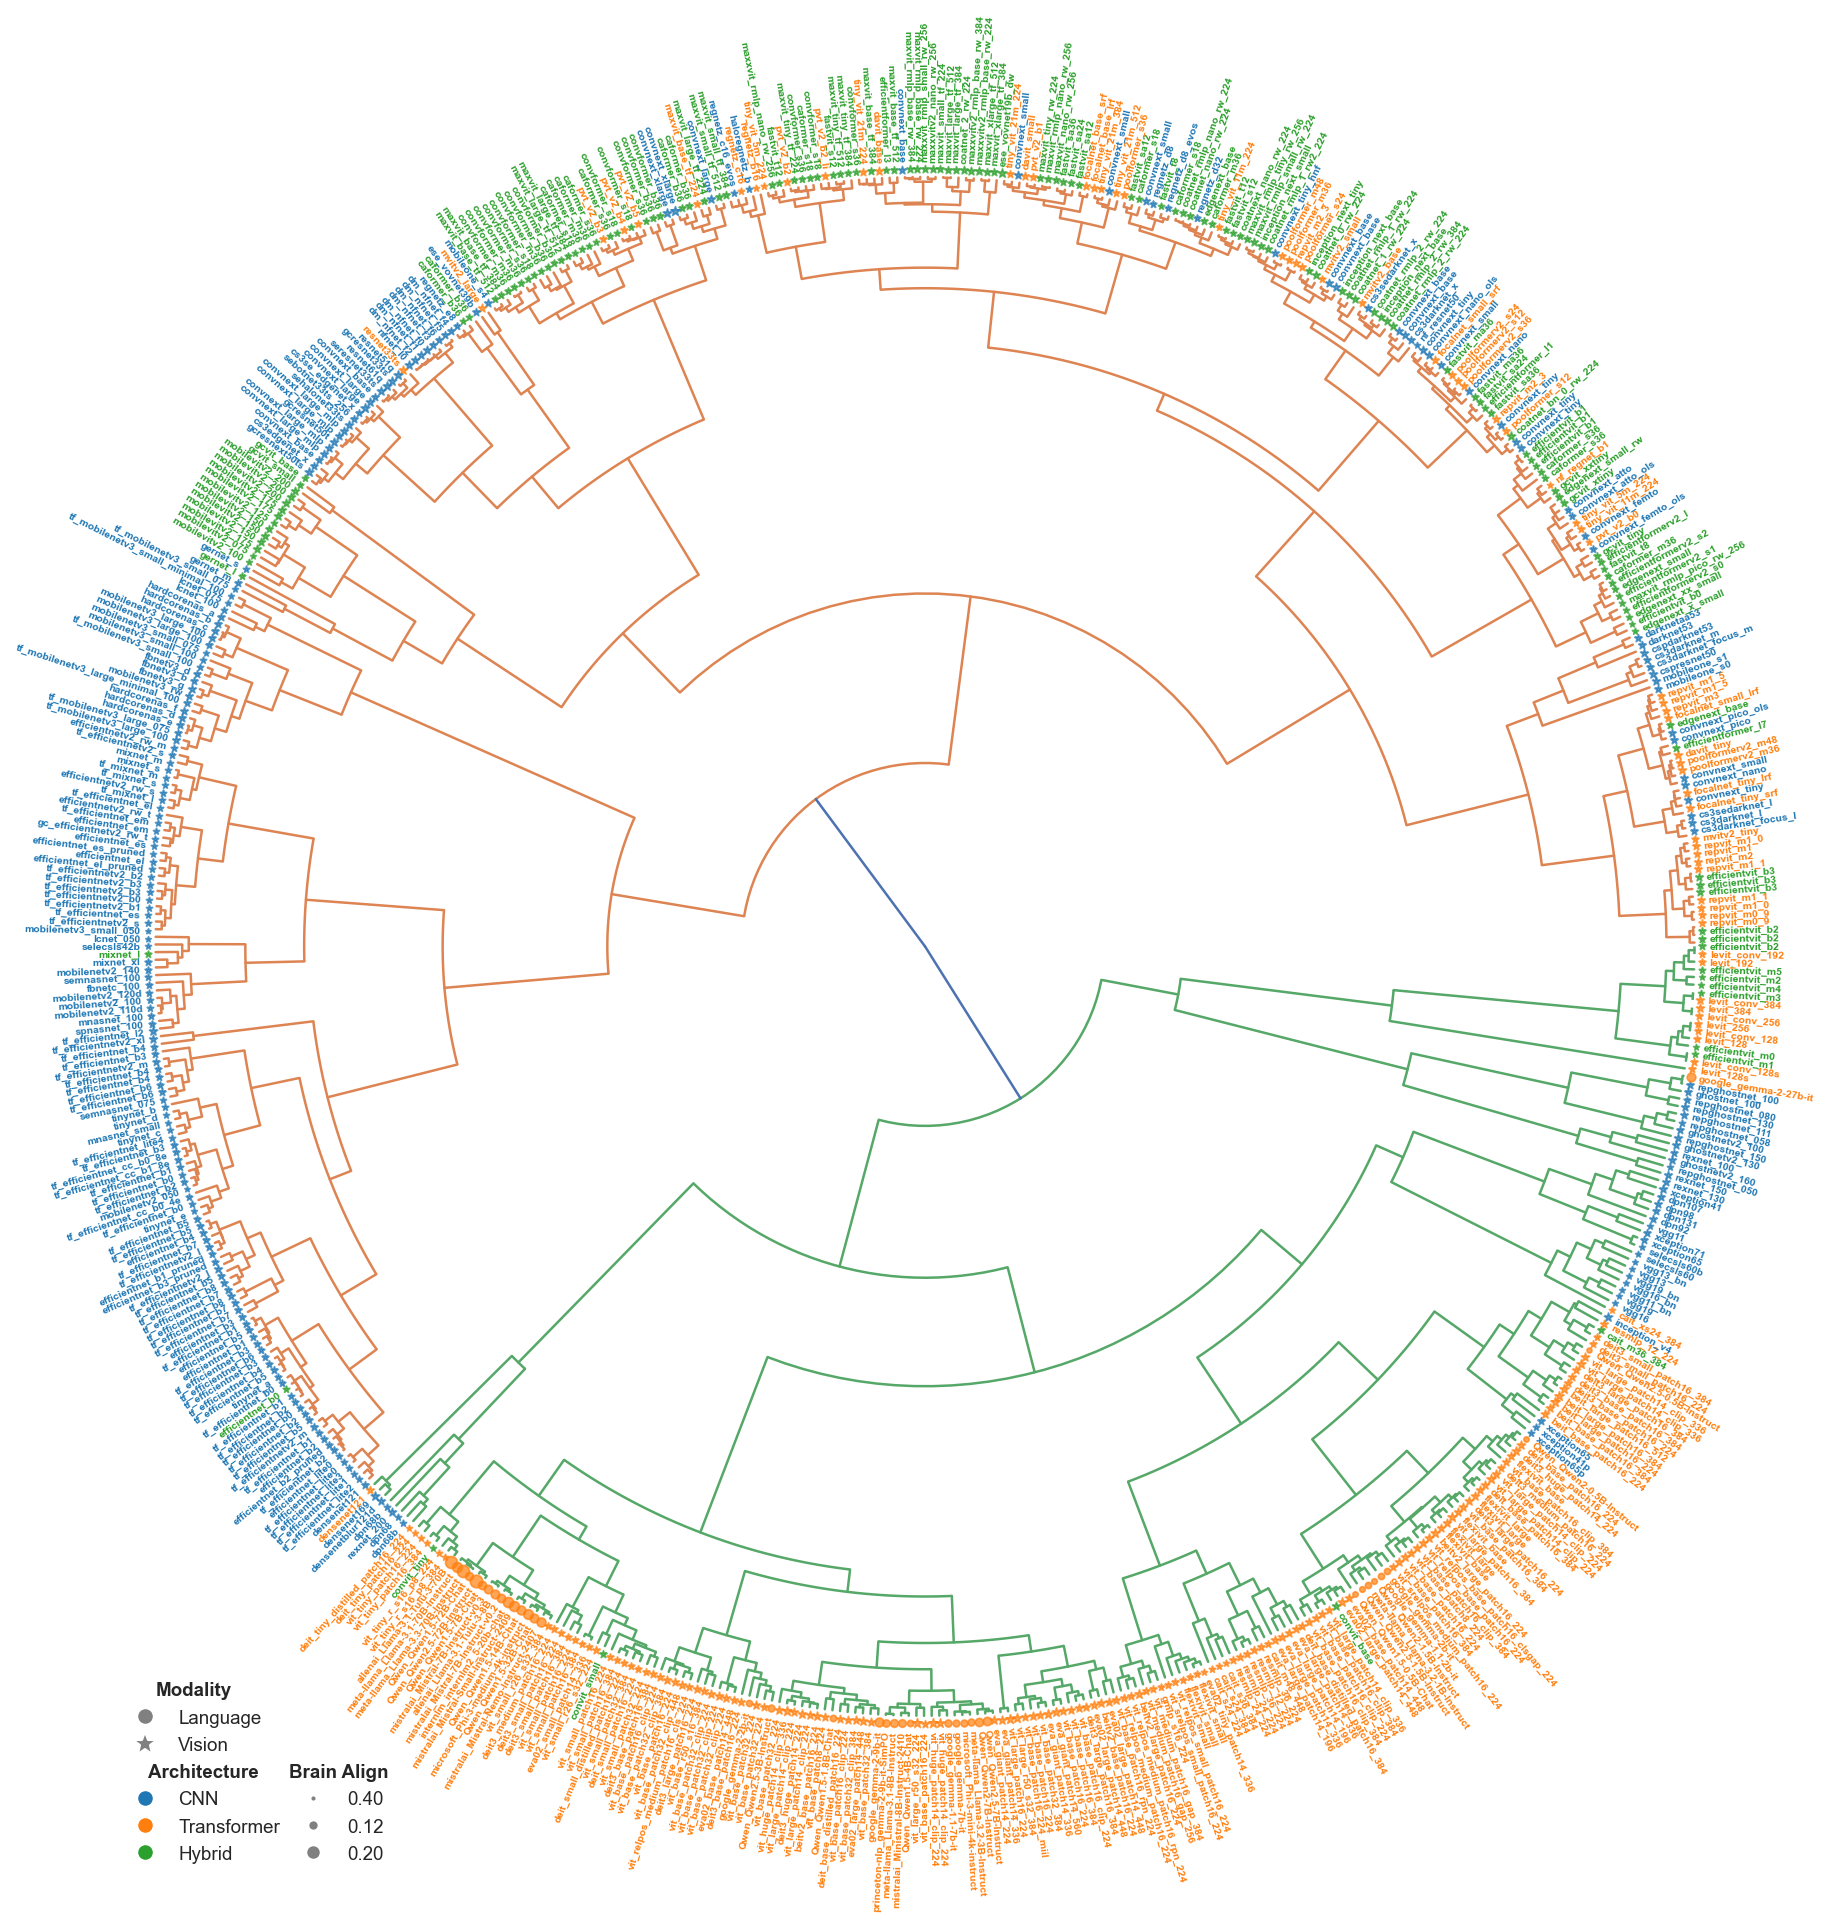

In [28]:
def create_circular_tree(Align_matrix, model_names, modalities,
                        figsize=(16, 16), bg_color='white',
                        label_spacing=1.0, min_radius=.233, max_radius=1.):
    """
    Create a circular tree visualization of model similarities with enhanced categorization
    and score representation.

    Parameters:
    - Align_matrix: matrix of Align scores between models
    - model_names: list of model names
    - modalities: list of modalities (language or vision)
    - figsize: figure size
    - bg_color: background color
    - label_spacing: spacing between labels
    - min_radius: minimum radius for the circular tree
    - max_radius: maximum radius for the circular tree

    Returns:
    - fig, ax: the matplotlib figure and axes objects
    """
    from scipy.cluster.hierarchy import linkage, dendrogram
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.path import Path
    import matplotlib.patheffects as PathEffects
    from matplotlib.colors import to_rgba, LinearSegmentedColormap
    import re


    # Determine categories for all models
    model_categories = [get_model_category(name, mod) for name, mod in zip(model_names, modalities)]

    # Calculate average Align score for each model (to represent node size)
    # avg_scores = np.mean(Align_matrix, axis=1)
    #
    # # Normalize scores for visual representation
    # min_score, max_score = np.min(avg_scores), np.max(avg_scores)
    # normalized_scores = (avg_scores - min_score) / (max_score - min_score) if max_score > min_score else np.ones_like(avg_scores) * 0.5
    # print(normalized_scores)

    # Define size range for nodes based on scores

    min_size, max_size = 1, 16
    # node_sizes = min_size + normalized_scores * (max_size - min_size)

    Z = linkage(Align_matrix, 'ward')

    fig = plt.figure(figsize=figsize, facecolor=bg_color)
    ax = fig.add_subplot(111, polar=True)

    # ax.set_facecolor(bg_color)

    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ddata = dendrogram(Z, no_plot=True)

    icoord = np.array(ddata['icoord'])
    dcoord = np.array(ddata['dcoord'])
    color_list = ddata['color_list']

    max_d = np.max(dcoord)
    min_d = np.min(dcoord)

    def depth_to_radius(depth, max_depth, min_depth):
        normalized_depth = (max_depth - depth) / (max_depth - min_depth)

        transformed = normalized_depth ** 11

        radius = min_radius + transformed * (max_radius - min_radius)
        return radius

    def to_polar(x, y, max_x):
        theta = (x / max_x) * 2 * np.pi
        r = depth_to_radius(y, max_d, min_d)
        return theta, r

    line_alpha = 1.

    for xs, ys, c in zip(icoord, dcoord, color_list):
        rgba_color = to_rgba(c, alpha=line_alpha)

        for i in range(0, len(xs) - 1):
            x1, y1 = xs[i], ys[i]
            x2, y2 = xs[i + 1], ys[i + 1]

            theta1, r1 = to_polar(x1, y1, np.max(icoord))
            theta2, r2 = to_polar(x2, y2, np.max(icoord))

            if i in [0, 2]:
                ax.plot([theta1, theta1], [r1, r2], color=rgba_color, linewidth=1.2,)
            else:
                if r1 < min_radius + 1e-7:

                    center_point = 0
                    ax.plot([theta1, theta1], [center_point, r1], color=rgba_color, linewidth=1.2)
                    ax.plot([theta2, theta2], [center_point, r1], color=rgba_color, linewidth=1.2)
                else:

                    arc = np.linspace(theta1, theta2, 30)
                    r_arc = np.ones_like(arc) * r1
                    points = np.column_stack((arc, r_arc))
                    path = Path(points, [Path.MOVETO] + [Path.LINETO] * (len(points) - 1))
                    patch = patches.PathPatch(path, edgecolor=rgba_color, facecolor='none', linewidth=1.2)
                    ax.add_patch(patch)

    leaf_positions = ddata['leaves']

    leaf_count = len(leaf_positions)

    cluster_sizes = {}
    for i in range(len(Z)):
        cluster_sizes[i + leaf_count] = Z[i][3]

    leaf_cluster_ids = list(range(leaf_count))

    for i, merge in enumerate(Z):
        a, b = int(merge[0]), int(merge[1])
        new_cluster_id = i + leaf_count

        for j in range(leaf_count):
            if leaf_cluster_ids[j] == a or leaf_cluster_ids[j] == b:
                leaf_cluster_ids[j] = new_cluster_id

    angle_ranges = {}
    for i, cluster_id in enumerate(leaf_cluster_ids):
        if cluster_id not in angle_ranges:
            angle_ranges[cluster_id] = []
        angle_ranges[cluster_id].append(i)

    leaf_angles = []

    base_angle_step = 2 * np.pi / leaf_count

    current_angle = 0
    for i in range(leaf_count):
        leaf_idx = leaf_positions[i]
        category = model_categories[leaf_idx]
        angle_step = base_angle_step * label_spacing

        leaf_angles.append(current_angle)
        current_angle += angle_step

    leaf_angles = np.array(leaf_angles) * (2 * np.pi / leaf_angles[-1]) * (38 + 592) / (38 + 593)

    leaf_radius = max_radius

    architecture_colors = {
        "CNN": "#1f77b4",
        "Transformer": "#ff7f0e",
        "Hybrid": "#2ca02c",
    }

    modality_markers = {
        "language": "o",
        "vision": "*",
    }

    max_score = 0.
    for i, leaf_idx in enumerate(leaf_positions):
        angle = leaf_angles[i]
        model_name = model_names[leaf_idx]
        modality = modalities[leaf_idx]
        category = model_categories[leaf_idx]

        color = architecture_colors.get(category, '#ff7f0e')
        marker = modality_markers.get(modality, 'D')

        if modality == "vision":
            score = vision_max_region_avg_subj_df[vision_max_region_avg_subj_df['src_model'] == model_name]['score'].values[0]
        elif modality == "language":
            if model_name in leaderboard_max_region_avg_subj_df['src_model'].unique().tolist():
                score = leaderboard_max_region_avg_subj_df[leaderboard_max_region_avg_subj_df['src_model'] == model_name]['score'].values[0]
            else:
                score = arena_max_region_avg_subj_df[arena_max_region_avg_subj_df['src_model'] == model_name]['score'].values[0]

        node_size = score / 0.125 * (max_size - min_size) * (1.5 if modality == 'vision' else 1.0) + min_size

        max_score = max(node_size, max_score)
        # print(max_score)
        text_angle = np.degrees(angle)
        if 90 < text_angle < 270:
            text_angle += 180
            ha = 'right'
        else:
            ha = 'left'

        ax.scatter(angle, leaf_radius + .01, s=node_size, marker=marker,
                   color=color, alpha=0.7, #edgecolor='white', linewidth=1,
                   zorder=5)

        display_name = model_name

        if '.' in display_name and category != 'Language':
            display_name = '.'.join(model_name.split('.')[:-1])


        text = ax.text(
            angle,
            leaf_radius + 0.02,
            display_name,
            rotation=text_angle,
            rotation_mode='anchor',
            horizontalalignment=ha,
            verticalalignment='center',
            fontsize=5,
            color=color,
            fontweight='bold'
        )


    from matplotlib.lines import Line2D
    import matplotlib.gridspec as gridspec
    from matplotlib.transforms import Bbox

    fig.subplots_adjust(bottom=0.2)

    modality_legend = []
    architecture_legend = []
    Align_legend = []


    for architecture, color in architecture_colors.items():
        modality_legend.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                   markersize=8, label=f'{architecture}')
        )


    for modality, marker in modality_markers.items():
        if modality != 'Other':
            if marker == '*':
                markersize = 12
            else:
                markersize = 8
            architecture_legend.append(
                Line2D([0], [0], marker=marker, color='w', markerfacecolor='gray',
                       markersize=markersize, label=f'{modality.capitalize()}')
            )

    score_min, score_mid, score_max = 0.4, 0.12, 0.20
    score_min_rounded = round(score_min, 2)
    score_mid_rounded = round(score_mid, 2)
    score_max_rounded = round(score_max, 2)

    Align_legend.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=3, label=f'{score_min_rounded:.2f}')
    )
    Align_legend.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=5, label=f'{score_mid_rounded:.2f}')
    )
    Align_legend.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=7, label=f'{score_max_rounded:.2f}')
    )

    leg1 = ax.legend(handles=modality_legend, loc='upper left',
                    bbox_to_anchor=(0.00, 0.01), frameon=False, fontsize=9,
                    title='Architecture', title_fontsize=9)
    ax.add_artist(leg1)

    leg2 = ax.legend(handles=architecture_legend, loc='upper left',
                    bbox_to_anchor=(0.00, 0.06), frameon=False, fontsize=9,
                    ncol=1, title='Modality', title_fontsize=9)
    ax.add_artist(leg2)

    leg3 = ax.legend(handles=Align_legend, loc='upper left',
                    bbox_to_anchor=(0.10, 0.01), frameon=False, fontsize=9,
                    title='Brain Align', title_fontsize=9)

    for legend in [leg1, leg2, leg3]:
        legend.get_title().set_fontweight('bold')

    ax.spines['polar'].set_visible(False)

    return fig, ax


fig, ax = create_circular_tree(Align_matrix, model_names, modalities)
os.makedirs(f"{FIGURES_DIR}/overview", exist_ok=True)
plt.savefig(f"{FIGURES_DIR}/overview/model_analysis.pdf", bbox_inches='tight')
plt.show()